![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Advanced Methods in Natural Language Processing - Final Project
## Emotion Classification

### by Maëlys Boudier, Natalia Beltran, Miguel Handt Fueyo, Clarice Mottet

0. **[Part 0: Dataset Selection](#part0)**
- **Objective**: Choose a unique dataset for text classification from the HuggingFace hub.

1. **[Part 1: Setting Up the Problem (1.5 points)](#part1)**
- **Objective**: Understand and establish the baseline for your chosen dataset.
- **Tasks:**
  - a. Bibliography and SOA (0.25 points): Present briefly your task by researching and documenting the main objective, a potential business case and the current state of the art for your dataset's task. Include relevant benchmarks and methodologies. You can look at google scholar, NLP index or papers with code.
  - b. Dataset Description (0.5 points): Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics.
  - c. Random Classifier Performance (0.25 points): Calculate the expected performance of a random classifier for your dataset to set a benchmark. The calculation should include an implementation.
  - d. Baseline Implementation (0.5 points): Develop a rule-based classifier as a baseline. Discuss its performance in the context of the dataset's complexity and compare it with human-level performance if available.
2. **[Part 2: Data Scientist Challenge (3.5 points)](#part2)**
- **Objective**: Explore different techniques to enhance model performance with limited labeled data. You will be limited to 32 labeled examples in your task. The rest can be viewed as unlabelled data.
- **Tasks:**
  - a. BERT Model with Limited Data (0.5 points): Train a BERT-based model using only 32 labeled examples and assess its performance.
  - b. Dataset Augmentation (1 point): Experiment with an automated technique to increase your dataset size without using LLMs. Evaluate the impact on model performance.
  - c. Zero-Shot Learning with LLM (0.5 points): Apply a large language model in a zero-shot learning setup. Document the performance.
  - d. Data Generation with LLM (1 point): Use a large language model to generate new, labeled dataset points. Analyze how this impacts model metrics.
  - e. Optimal Technique Application (0.5 points): Based on the previous experiments, apply the most effective technique(s) to further improve your model's performance. Comment your results.
3. **[Part 3: State of the Art Comparison (2 points)](#part3)**
- **Objective**: Benchmark your model against the SOA with the full dataset now available.
- **Tasks:**
  - a. Full Dataset Training (0.25 points): Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.
  - b. Learning Curve (0.25 points): Plot a learning curve based on the training data percentages.
  - c. Technique Comparison (0.5 points): Incorporate the techniques tested in Part 2 into your training schema for comparison.
  - d. Methodology Analysis (1 point): Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.
4. **[Part 4: Model Distillation (3 points)](#part4)**
- **Objective**: Reduce the computational requirements for deploying your model.
- **Tasks:**
  - a. Model Distillation (1.5 point): Distill your best-performing model into a lighter model. Document the process and tools used.
  - b. Performance and Speed Comparison (0.5 points): Evaluate the distilled model's performance and inference speed compared to the original. Highlight key findings.
  - c. Analysis and Improvements (1 point): Analyze deficiencies in the student model's learning. Suggest potential improvements or further research directions.

**Submission Guidelines:**
- Document your analysis, code, and findings in on or several Jupyter notebooks.
- Make an executive summary of your main findings and results. Don't abuse on chatGPT :).
- Add a random seed at the beginning of your code so I can be able to reproduce the code.
- Use markdown cells to elaborate on your decision-making process and insights at each step.
- Submit the completed notebook via the course's designated submission portal by the specified deadline.

### General Overview of Findings:

**Part 0:** 
* Dataset Summary: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise
* Dataset Source: https://huggingface.co/datasets/dair-ai/emotion


**Part 1:** 
* Data Description: We found a class imbalance across the six basic emotions with the highest representation being "Joy" at about 33% and "Suprise" being least represented at 3.5%. The Twitter Messages have been previously preprocessed, everything is lower case and contains no special characters. The number of terms across sentiments is generally consistent as well as the 'Parts-of-Speech' that make up the Twitter Messages.
* Random Classification: A random guess yields about 16% accuracy as we would expect with six classifications to guess and class imbalance.
* Rules-Based Classification: Creating a rules-based classifier using Spacy, we found that unique terms to a sentiment were not fully representative of the sentiment population and more general terms were common across multiple sentiments.

**Part 2:** 
* Data Augmentation: Using multiple data augmentation techniques, we found little change from our initial model trained on only 32 data points.
* Zero-Shot: Employing this method to predict sentiment, we saw a large improvement from the models trained on only 32 labeled twitter messages and the data augmented model.
* GPT-3 - Generating Data: With using multiple different prompt options we found varying results in generating new data. While still an improvement from the first two models, we only were able to match performance and not exceed zero-shot learning prediction as we had hoped and expected.

**Part 3:** 
* Incremental Training: When training our model at different increments of data, we found that our best model performed when 100% of the data was used. 
* Technique Comparison: We employed the same technique of generating data from multiple prompts, we found that this technique yielded similar but slightly lower performance compared to the full data trained model. 
* Methodology Analysis: The additional technique model reduced the misclassification of one of the certain labels that was prompted but led to an overall minor decrease in accurately classified data compared to the full trained model. The additional technique relies on prompts to generate the data, so the model is dependent on the effectiveness of our prompts which limits its potential. 

**Part 4:**
* Distillation: We use the best model so far as a teacher model to distill a student model that performs almost as well but with considerably less parameters, reducing the computational cost. 
* Performance comparison: We see that indeed we manage to keep most of the predictive ability: 99.7% of the teacher model's accuracy while reducing the prediction time of the test dataset by 43.26%
* While we are satisfied with the overall performance of our best models, we still find some error patterns that might be improved through further feature engineering.

### Set-Up

We begin by importing relevant standard libraries into our programming environment, define a class of metrics for frequently used performance metrics, define file paths for saving information and performing analysis checks and we load our Twitter Message sentiment data from hugging face.

In [1]:
#Libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
np.random.seed(123)

import random
random.seed(123)

#for zero shot learning and LLM data generation
from transformers import set_seed
set_seed(42)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.num_classes = None
        self.results = {}
        self.labels = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
        self.colors = ['#66b3ff', '#ffa500', '#ff99cc', '#ff6666', '#c2c2f0', '#99ff99']

    def run(self, y_true, y_pred, method_name, average='macro'):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        if self.num_classes is None:
            self.num_classes = len(np.unique(y_true))

        # Calculate metrics for each class
        for label in range(self.num_classes):
            y_true_label = (y_true == label).astype(int)
            y_pred_label = (y_pred == label).astype(int)
            accuracy = accuracy_score(y_true_label, y_pred_label)
            precision = precision_score(y_true_label, y_pred_label)
            recall = recall_score(y_true_label, y_pred_label)
            f1 = f1_score(y_true_label, y_pred_label)

            # Store results
            if label not in self.results:
                self.results[label] = {}
            if method_name not in self.results[label]:
                self.results[label][method_name] = {}
            self.results[label][method_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
            }

        # Calculate overall metrics
        overall_accuracy = accuracy_score(y_true, y_pred)
        overall_precision = precision_score(y_true, y_pred, average='macro')
        overall_recall = recall_score(y_true, y_pred, average='macro')
        overall_f1 = f1_score(y_true, y_pred, average='macro')

        # Store overall results
        if 'Overall' not in self.results:
            self.results['Overall'] = {}
        if method_name not in self.results['Overall']:
            self.results['Overall'][method_name] = {}
        self.results['Overall'][method_name] = {
            'accuracy': overall_accuracy,
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1,
        }
        

    def plot_val(self):
        # Create subplots
        fig, axs = plt.subplots(self.num_classes + 1, 4, figsize=(15, 3*(self.num_classes + 1)))

        # Plot each metric for each class
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            for j in range(self.num_classes):
                ax = axs[j, i]
                values = [res[metric] * 100 for res in self.results[j].values()]
                ax.bar(self.results[j].keys(), values, color=self.colors[j])
                ax.set_title(f"{metric} - {self.labels[j]}")
                ax.set_ylim(0, 100)
                # ax.set_xticklabels(self.results[j].keys(), rotation=45)
                ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
                ax.set_xticklabels(self.results[j].keys(), rotation=45)

                # Add values on the bars
                for k, v in enumerate(values):
                    ax.text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

            # Plot overall metrics
            ax = axs[-1, i]
            if 'Overall' in self.results:
                values = [res[metric] * 100 for res in self.results['Overall'].values()]
                ax.bar(self.results['Overall'].keys(), values, color='black')
                ax.set_title(f"{metric} - Overall")
                ax.set_ylim(0, 100)
                # ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)
                ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
                ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)
                # Add values on the bars
                for k, v in enumerate(values):
                    ax.text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot(self):
        fig, axs = plt.subplots(1, 4, figsize=(15, 3))

        # Plot overall metrics
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            values = [res[metric] * 100 for res in self.results['Overall'].values()]
            axs[i].bar(self.results['Overall'].keys(), values, color='black')
            axs[i].set_title(f"{metric} - Overall")
            axs[i].set_ylim(0, 100)
            # axs[i].set_xticklabels(self.results['Overall'].keys(), rotation=45)
            axs[i].xaxis.set_major_locator(ticker.FixedLocator(axs[i].get_xticks()))
            axs[i].set_xticklabels(self.results['Overall'].keys(), rotation=45)
            # Add values on the bars
            for k, v in enumerate(values):
                axs[i].text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

def confusion_matrix_display(df, col):

    # Mapping the sentiment to the label number
    label_names = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
    # colors = ['#66b3ff', '#ffa500', '#ff99cc', '#ff6666', '#c2c2f0', '#99ff99']

    # Creating the confusion matrix
    cm = confusion_matrix(df['label'], df[col])

    # Update the plotting code to use sentiment names and specific colors
    plt.figure(figsize=(10, 7))
    # sns.heatmap(cm, annot=True, fmt="d", cmap=sns.color_palette(colors), xticklabels=label_names.values(), yticklabels=label_names.values())
    sns.heatmap(cm, annot=True, fmt="d", cmap='Greys', xticklabels=label_names.values(), yticklabels=label_names.values())
    plt.title('Confusion Matrix with Sentiment Labels - '+col)
    plt.xlabel('Predicted Labels - '+col)
    plt.ylabel('True Labels')
    plt.show()

def misclassifications_display(df_, list_true, col, int_miss):

    df_specific = df_[(df_['label'].isin(list_true))&(df_[col].isin([int_miss]))].copy().reset_index(drop = True)

    labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

    # Initialize empty lists for each label
    example_texts = {label: [] for label in labels}

    # Iterate through each row in df_sample and append 'text' to the corresponding label list
    for index, row in df_specific.iterrows():
        label = row['label']
        text = row['text']
        example_texts[label].append(text)

    # Print the lists
    for label, text_list in example_texts.items():
        if len(text_list) > 0:
            print(f"Misclassified {label} ({labels[label]}) as {int_miss} ({labels[int_miss]}) Examples:")
            print(text_list[0:5])
            print()


In [3]:
# Change Path Before you Run ! 
path_out_ = r'/Users/...'
path_models_ = r'/Users/...'

In [4]:
from datasets import load_dataset

#load data into programming environment
dataset = load_dataset("dair-ai/emotion", trust_remote_code=True)

#three datasets: one training (16000 rows), one validation (2000 rows), one test (2000 rows)
#each have two columns ['text','label']
print("Datasets imported in:", dataset.keys())

df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

Datasets imported in: dict_keys(['train', 'validation', 'test'])


## <a id='part1'>Part 1: Setting Up the Problem</a>
- **Objective**: Understand and establish the baseline for your chosen dataset.
- **Tasks:**
  - a. Bibliography and SOA (0.25 points): Present briefly your task by researching and documenting the main objective, a potential business case and the current state of the art for your dataset's task. Include relevant benchmarks and methodologies. You can look at google scholar, NLP index or papers with code.
  - b. Dataset Description (0.5 points): Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics.
  - c. Random Classifier Performance (0.25 points): Calculate the expected performance of a random classifier for your dataset to set a benchmark. The calculation should include an implementation.
  - d. Baseline Implementation (0.5 points): Develop a rule-based classifier as a baseline. Discuss its performance in the context of the dataset's complexity and compare it with human-level performance if available.


### 1.a Bibliography and SOA
*Present briefly your task by researching and documenting the main objective, a potential business case and the current state of the art for your dataset's task. Include relevant benchmarks and methodologies. You can look at google scholar, NLP index or papers with code.*

**Main Objective**: The primary goal is to categorize English Twitter messages into on basic emotions: anger, fear, joy, love, sadness, and surprise.

**Data**: https://huggingface.co/datasets/dair-ai/emotion

**Business Case**: Classifying Twitter tweets based on emotions would benefit brand reputation management. By promptly identifying and addressing negative sentiment, companies can minimize potential PR crises and uphold a positive brand image. Additionally, this approach provides valuable insights into customer sentiment towards products, services, or the brand itself. These insights enable businesses to assess overall customer satisfaction, pinpoint areas for enhancement, and adjust marketing strategies accordingly.

**Current State of the Art**: https://huggingface.co/Vasanth/bert-base-uncased-finetuned-emotion

**Benchmarks and Methodologies**:
| Base Model                           | Loss   | Accuracy | F1     | Links                                                |
|--------------------------------------|--------|----------|--------|------------------------------------------------------|
| bert-base-uncased                    | 0.1476 | 0.9454   | 0.9458 | [bert-base-uncased-finetuned-emotion](https://huggingface.co/Vasanth/bert-base-uncased-finetuned-emotion) |
| distilroberta-base                   | 0.1496 | 0.9435   | -      | [distilroberta-emotion-intent](https://huggingface.co/gokuls/distilroberta-emotion-intent) |
| distilbert-base-uncased              | 0.1611 | 0.9425   | 0.9424 | [distilbert-base-uncased-finetuned-emotion](https://huggingface.co/BellaAndBria/distilbert-base-uncased-finetuned-emotion) |

Each of the base models were then finetuned on the emotion dataset. The bert-base-uncased-finetuned-emotion trained based on bert-base-uncased is considered the state-of-the-art and will be used as our benchmark.


### 1.b Dataset Description
*Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics.*

#### Overview of Dataset: Data and Size

Upon import we have three datasets. A 'Train' dataset for model training with 16,000 Twitter Messages contained in the 'text' field and a corresponding integer representation of sentiment in the 'label' field, and a 'Validation' and 'Test' dataset each with 2,000 Twitter Messages given with the same field names.

In [5]:
# pandas dataframe columns are ['Train','Test']
# rows will be ['Number of Twitter Messages']
dict_size = {'Train':[len(df_train['text'])], 'Val':[len(df_val['text'])], 'Test':[len(df_test['text'])]}
df_p1_tb_size = pd.DataFrame(dict_size, index = ['Number of Twitter Messages'])
print(df_p1_tb_size)

                            Train   Val  Test
Number of Twitter Messages  16000  2000  2000


#### Distribution of Labels

We find that with six sentiments, defined in the below dictionary, we have a class imbalance among labels. "Joy" and "Sadness" represent the majority (62.7%) of the training data at 33.5% and 29.2% respectively while "Love" at 8.2% and "Surprise" at only 3.6% are least represented. In the middle we have "Anger" representing 13.5% and "Fear" at 12.1% of the training data. A balanced class distribution would mean each sentiment would represent approximately 16% of the training data. Because we have a labels, such as "Joy" representing 33.5% of the data and "Surprise" at only 3.6%, a large divergence away from 16%, we have data with a fairly strong class imbalance.

In [6]:
#Sentiment Labels

labels = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'} 

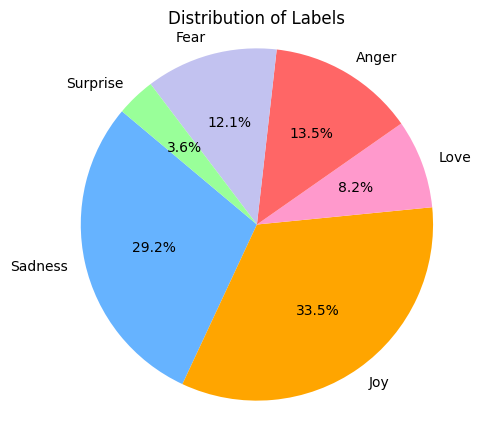

In [7]:
# Count occurrences of each label
label_counts = {}
for label in df_train['label']:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Custom color palette: 
#66b3ff: Blue (corresponds to Sadness)
#ffa500: Orange (corresponds to Joy)
#ff99cc: Pink (corresponds to Love)
#ff6666: Red (corresponds to Anger)
#c2c2f0: Purple (corresponds to Fear)
#99ff99: Green (corresponds to Surprise)

colors = ['#66b3ff', '#ffa500', '#ff99cc', '#ff6666', '#c2c2f0', '#99ff99']

# Create a pie chart
sizes = [label_counts[label] for label in range(len(labels))]
labels_str = [labels[label] for label in range(len(labels))]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels_str, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Labels')
plt.show()


#### Examples from each label

In looking through examples for each label, we noticed that our data has been previously pre-processed where all characters are lowercase and special characters are removed. We conducted data checks and ensured this was the case for all of the data and not just the examples printed below.

In [8]:
# Grouping by label and printing the first 2 examples from each label
for label, group in df_train.groupby('label'):
    print(f"Examples for label '{labels[label]}':")
    for index, row in group.head(2).iterrows():
        print('-', row['text'])
    print()

Examples for label 'Sadness':
- i didnt feel humiliated
- i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake

Examples for label 'Joy':
- i have been with petronas for years i feel that petronas has performed well and made a huge profit
- i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter

Examples for label 'Love':
- i am ever feeling nostalgic about the fireplace i will know that it is still on the property
- i feel romantic too

Examples for label 'Anger':
- im grabbing a minute to post i feel greedy wrong
- i am feeling grouchy

Examples for label 'Fear':
- i feel as confused about life as a teenager or as jaded as a year old man
- i now feel compromised and skeptical of the value of every unit of work i put in

Examples for label 'Surprise':
- ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny
- 

In [9]:
#Ensure that previous pre-processing is consistent for all data

df_check = df_train.copy()
df_check['text_check'] = df_train['text'].str.lower().str.replace('[^\w\s]', '', regex=True)
df_check = df_check[df_check['text_check']!=df_check['text']]
print("     Train: Twitter Messages inconsistent",len(df_check['text']))

df_check = df_val.copy()
df_check['text_check'] = df_check['text'].str.lower().str.replace('[^\w\s]', '', regex=True)
df_check = df_check[df_check['text_check']!=df_check['text']]
print("Validation: Twitter Messages inconsistent",len(df_check['text']))

df_check = df_test.copy()
df_check['text_check'] = df_check['text'].str.lower().str.replace('[^\w\s]', '', regex=True)
df_check = df_check[df_check['text_check']!=df_check['text']]
print("      Test: Twitter Messages inconsistent",len(df_check['text']))

     Train: Twitter Messages inconsistent 0
Validation: Twitter Messages inconsistent 0
      Test: Twitter Messages inconsistent 0


#### Length of Texts

As an initial check, we wanted to see if the number of words in Twitter Messages was consistent between the various sentiments. With a minimum number of words between 2-3, a maximum between 60-66 and an average of between 18-21, the number of words in Twitter Messages across sentiment is fairly evenly distributed.

In [10]:
# Calculate word counts for each label

summary_data = []
for label, group in df_train.groupby('label'):
    word_counts = group['text'].apply(lambda x: len(x.split()))
    min_words = word_counts.min()
    max_words = word_counts.max()
    average_words = int(round(word_counts.mean()))
    summary_data.append({'Label': label, 'Label Name': labels[label], 'Minimum word count': min_words, 'Maximum word count': max_words, 'Average word count': average_words})

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

summary_df

Label Label Name  Minimum word count  Maximum word count  \
0      0    Sadness                   2                  66   
1      1        Joy                   2                  64   
2      2       Love                   3                  63   
3      3      Anger                   2                  62   
4      4       Fear                   2                  60   
5      5   Surprise                   3                  60   

   Average word count  
0                  18  
1                  19  
2                  21  
3                  19  
4                  19  
5                  20

#### Wordcloud

To visualize common terms within sentiment, we created WordClouds. Doing so, we found common terms among all the sentiments emerge such as 'feel', 'like', 'know', and 'think'. We removed the total population wide common terms and produced another WordCloud. Now we're able to grasp a better view of terms tied to specific sentiments such as 'weird' and 'amazed' for "Surprise", 'nervous' and 'strange' for "Fear" or 'sweet' and 'caring' for "Love".

Initial WordCloud where we see common terms across sentiments emerge.


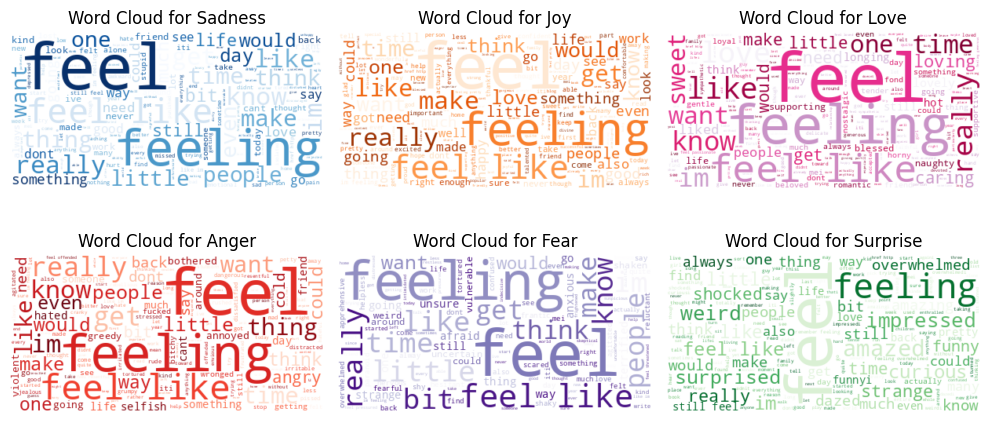

In [11]:
from collections import defaultdict
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Print Statement
print("Initial WordCloud where we see common terms across sentiments emerge.")

# Define labels
labels = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

# Define colors for each label
colors = {'Sadness': 'Blues', 'Joy': 'Oranges', 'Love': 'PuRd', 'Anger': 'Reds', 'Fear': 'Purples', 'Surprise': 'Greens'}

# Prepare data for word clouds
label_data = defaultdict(lambda: '')

df_train_view = df_train.copy()
df_train_view.sort_values(by = ['label'], inplace = True)

for index, row in df_train_view.iterrows():
    label = row['label']
    text = row['text']
    label_data[label] += text

# Set stopwords
stop_words = set(stopwords.words('english'))

# Generate and plot word clouds for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 5)) # Create subplots in a 2x3 grid
axs = axs.flatten()  # Flatten the axis array

for i, (label, text) in enumerate(label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', colormap=colors[labels[label]]).generate(text)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title('Word Cloud for {}'.format(labels.get(label, 'Unknown')))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Updated WordCloud with common terms across sentiments removed.


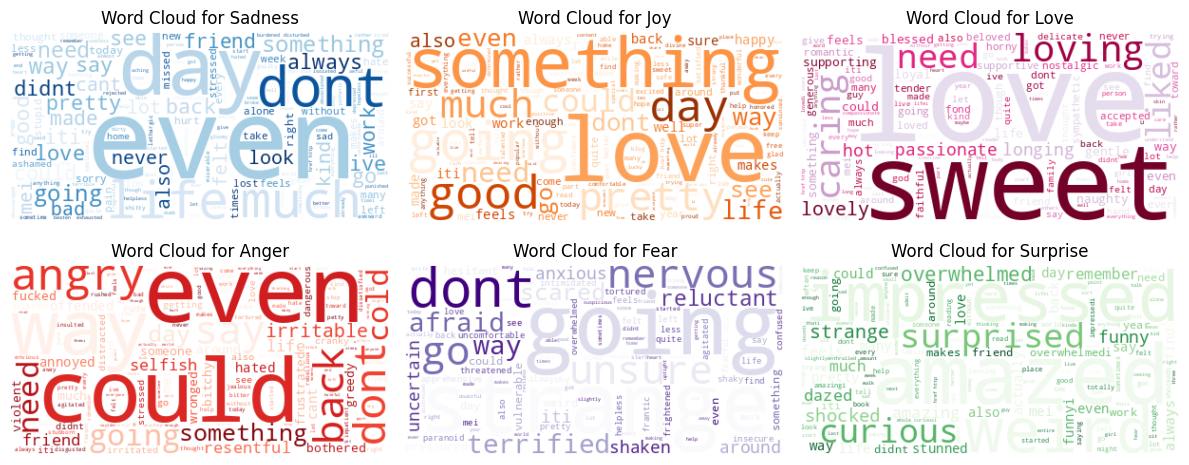

In [12]:
# Print Statement
print("Updated WordCloud with common terms across sentiments removed.")

# Set stopwords
stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stop_words = {'feel', 'feeling', 'feelings', 'like', 'im', 'really', 'know', 'would', 'get', 'time', 'think', 
                     'thing', 'make', 'one', 'want', 'bit', 'still', 'little', 'things', 'people'}
stop_words.update(custom_stop_words)

# Generate and plot word clouds for each label
fig, axs = plt.subplots(2, 3, figsize=(12, 5)) # Create subplots in a 2x3 grid
axs = axs.flatten()  # Flatten the axis array

for i, (label, text) in enumerate(label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', colormap=colors[labels[label]]).generate(text)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title('Word Cloud for {}'.format(labels.get(label, 'Unknown')))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

#### Parts-of-Speech Tagging

To further gain an understanding of the Twitter messages within each sentiment, we conducted an analysis of the distribution of 'Parts-of-Speech' or the extent to which a Twitter message is comprised of adjectives, nouns, or proper nouns by sentiment.

In general, we saw that the distribution of verbs in their base form (such as 'run' or 'walk'), adverbs (such as 'very'), coordinating conjuctions (such as 'and', or 'or'), and determiners (such as 'the') were evenly distributed amoung all sentiments.

Where we saw differences was in the 'Other' population, terms in categories we were generally uninterested in that would not aid in our rules'based classifier, ranging from 50% to 70% across sentiment. For sentiments "Love", "Joy" and "Surprise" we saw about 5% of terms were tagged as plural nouns (for example 'dogs' in 'two dogs'). For "Love" and "Anger" we saw about 10% of terms were modifying adjectives (for example 'beautiful' in 'beautiful day') and 5% of terms were personal pronouns (for example 'I' or 'You'). Only present in the sentiment "Fear" were present verbs at around 5% (for example 'running' or 'eating').

While generally we saw approximately 80% of terms in the Twitter messages had a similar 'Parts-of-Speech' distribution, the other 20% differed by the type of 'Parts-of-Speech' present and amount. We decided because of generally even distribution between the sentiments we are not going to move forward to using this information in our rules-based classifier.

In [13]:
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataliabeltran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nataliabeltran/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
# Initialize an empty dictionary to store parts of speech counts for each label
pos_counts = {label: nltk.defaultdict(int) for label in labels.values()}

# Function to get parts of speech counts
def get_pos_counts(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    for _, pos in tagged:
        pos_counts[label][pos] += 1

# Iterate through the DataFrame to calculate parts of speech counts for each label
for index, row in df_train.iterrows():
    label = labels[row['label']]
    text = row['text']
    get_pos_counts(text)

# Calculate total count for each label
total_counts = {label: sum(counts.values()) for label, counts in pos_counts.items()}

# Convert counts to percentages
pos_percentages = {label: {pos: (count / total_counts[label]) * 100 for pos, count in counts.items()} 
                   for label, counts in pos_counts.items()}

# Filter pos_percentages to keep only keys/values where the percent is above 4
pos_percentages_filtered = {label: {pos: count for pos, count in counts.items() if count > 4} 
                            for label, counts in pos_percentages.items()}

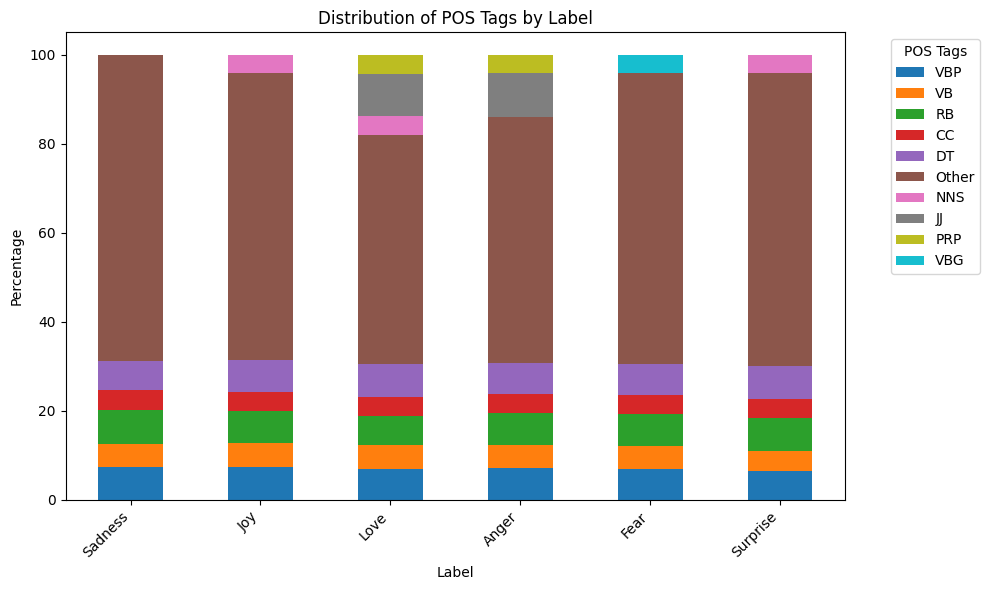

In [15]:
# Function to create 'other' category
def create_other(pos_dict, threshold=10):
    other = {}
    total = 100
    for pos, percentage in pos_dict.items():
        if percentage <= threshold:
            other[pos] = percentage
            total -= percentage
    if total > 0:
        other['Other'] = total
    return other

# Convert data to DataFrame
data = {label.capitalize(): create_other(pos_dict) for label, pos_dict in pos_percentages_filtered.items()}
df = pd.DataFrame(data)

# Plot bar chart
ax = df.T.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Percentage')
ax.set_xlabel('Label')
ax.set_title('Distribution of POS Tags by Label')
plt.xticks(rotation=45, ha='right')
plt.legend(title='POS Tags', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The full detailed definitions of **POS tags** with examples can be found below:
* VBP stands for "Verb, non-3rd person singular present" which includes verbs that do not agree with the third-person singular form in the present tense, such as "run" in "They run", "eat" in "We eat", etc.
* VB stands for "Verb, base form" which includes the infinitive form of the verb without "to", like "be" in "To be or not to be", "have" in "To have and to hold", etc.
* RB stands for "Adverb" which includes words that modify verbs, adjectives, or other adverbs, like "quickly" in "She moves quickly", "very" in "It is very big", etc.
* CC stands for "Coordinating conjunction" which includes words that link words, phrases, or clauses of equal rank, such as "and" in "You and I", "but" in "It is small but powerful", etc.
* DT stands for "Determiner" which includes words that introduce nouns, like "the" in "The book", "an" in "An apple", etc.
* NNS stands for "Noun, plural" which includes plural forms of nouns, like "dogs" in "Two dogs", "computers" in "Many computers", etc.
* JJ stands for "Adjective" which includes words that describe or modify nouns, like "beautiful" in "A beautiful day", "big" in "A big house", etc.
* PRP stands for "Personal pronoun" which includes pronouns that refer to specific people or things, like "I" in "I am here", "you" in "You are there", etc.
* VBG stands for "Verb, gerund or present participle" which includes verbs in their "-ing" form used as nouns, adjectives, or to form continuous tenses, such as "running" in "Running is fun", "eating" in "Eating apples is healthy", etc.

In [16]:
# clean up by deleting objects which take space
# %whos
del df_p1_tb_size, wordcloud, pos_percentages_filtered, pos_percentages, fig, summary_df, dataset, label_data, group, df_train_view

### 1.c Random Classifier Performance
*Calculate the expected performance of a random classifier for your dataset to set a benchmark. The calculation should include an implementation.*

A random guess of sentiment on the validation data and test data yielded an overall accuracy of around 16-17%, yet because we saw our sentiment distribution is unbalanced we look to the F1 score and find that at around 15-16% a random guess does a poor job of correctly guessing sentiment and has a high rate of false positives.

Typically the random guesses are going to be uniformly distributed across the six sentiments, yet because we have class imbalance, we expected the overall accuracy and F1 to be worse than 16% (1/6), as it would over-guess low represented sentiments and under-guess high represented sentiments.

Where we see the uniformity of the random guesses play out in the validation data is in the outsized accuracy performance of the sentiments making up the smallest proportion of the Twitter Message population, "Surprise" and "Love". With accuracy results higher than 70% and F1 scores around 10% indicating an high rate of false positives, we see the over-guessing of low represented sentiments due to random guessing's uniformity. In later development, we plan to prioritize F1 score performance in evaluating the efficacy of our models.

#### Validation Performance

In [17]:
# Generate the list with random integers between 0 and 5
valid_preds_rand = [random.randint(0, 5) for _ in range(len(df_val['text']))]

# Display the generated list
print("Random List First 5 Elements (for Val):")
print(valid_preds_rand[0:5])

Random List First 5 Elements (for Val):
[5, 0, 0, 5, 2]


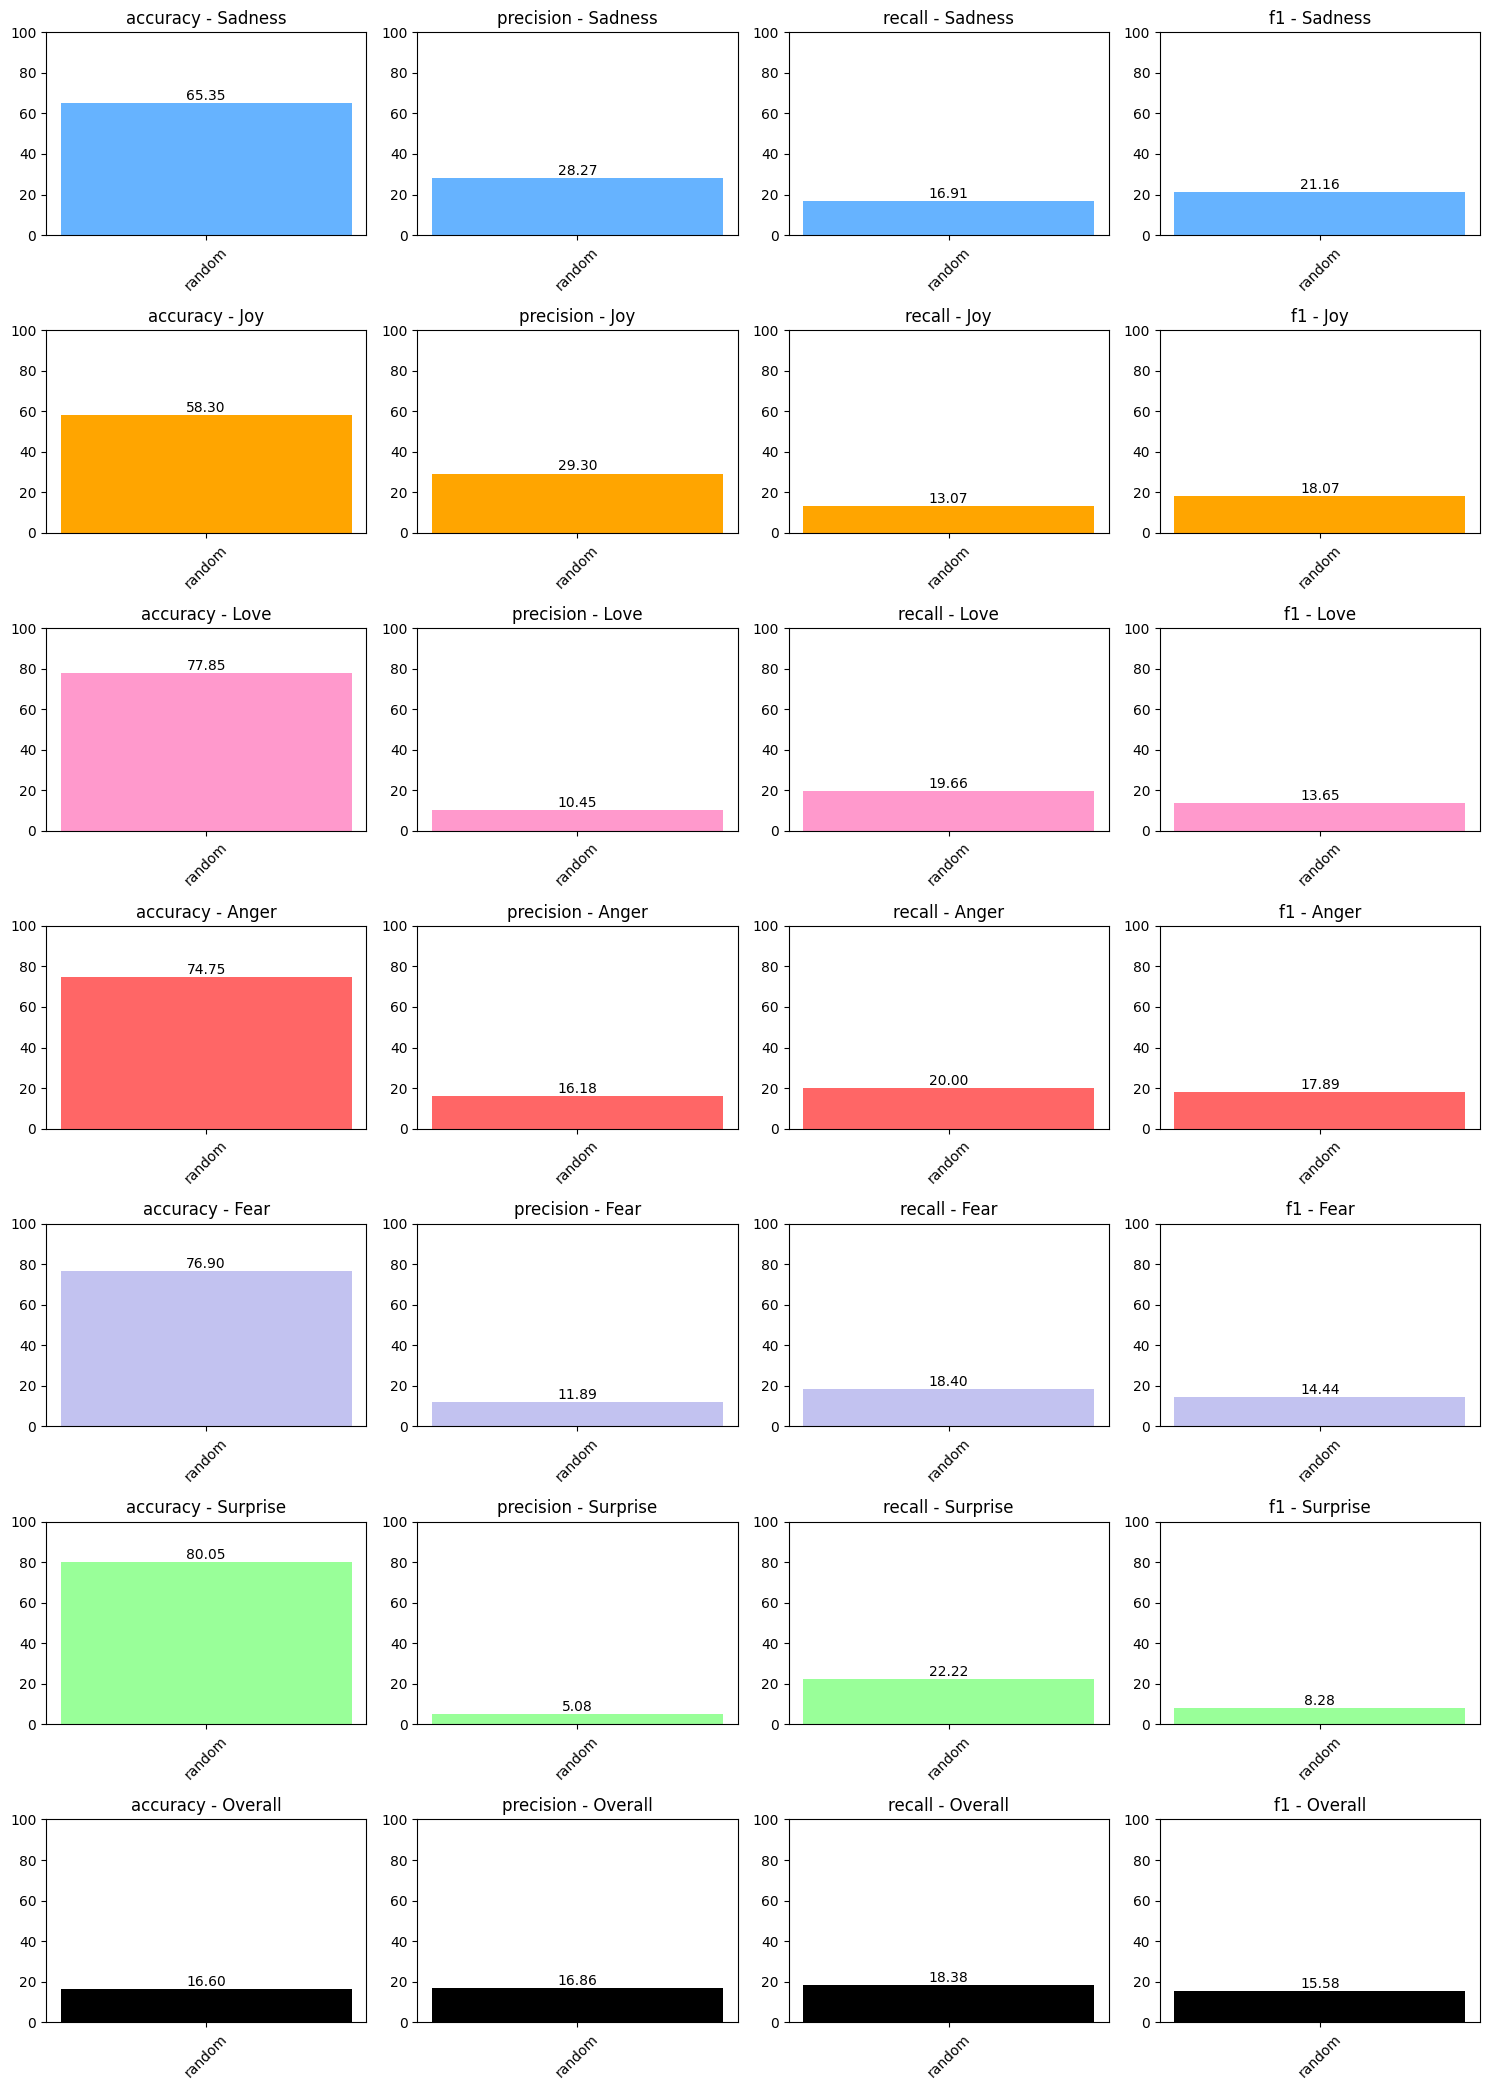

In [18]:
# get the final metrics
metrics_val= Metrics()
metrics_val.run(df_val['label'], valid_preds_rand, "random")
metrics_val.plot_val()

metrics_val_ai= Metrics()
metrics_val_ai.run(df_val['label'], valid_preds_rand, "random")

#### Test Performance

In [19]:
# Generate the list with random integers between 0 and 5
test_preds_rand = [random.randint(0, 5) for _ in range(len(df_test['text']))]

# Display the generated list
print("Random List First 5 Elements (for Test):")
print(test_preds_rand[0:5])

Random List First 5 Elements (for Test):
[1, 1, 1, 5, 4]


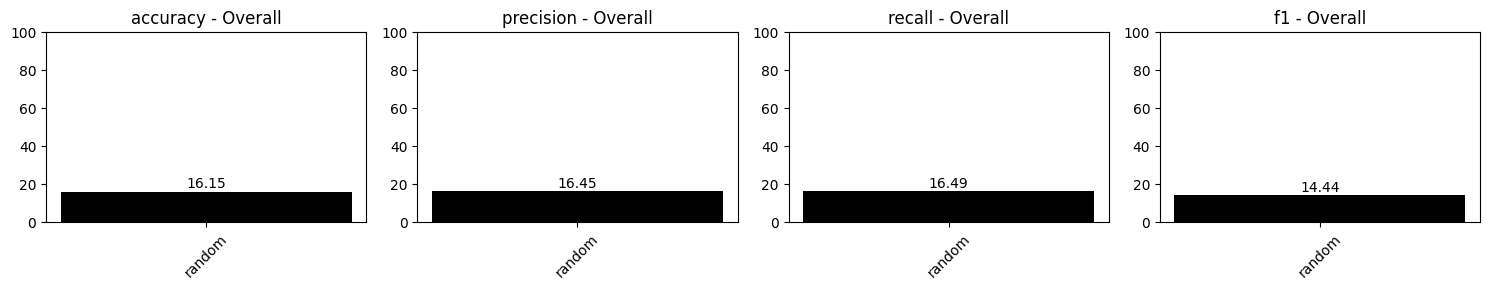

In [20]:
# get the final metrics
metrics_test= Metrics()
metrics_test.run(df_test['label'], test_preds_rand, "random")
metrics_test.plot()

metrics_test_ai= Metrics()
metrics_test_ai.run(df_test['label'], test_preds_rand, "random")

### 1.d Baseline Implementation
*Develop a rule-based classifier as a baseline. Discuss its performance in the context of the dataset's complexity and compare it with human-level performance if available.*

Using the insight derived from our previous WordCloud visualization, we developed a rule based classifier using Spacy. 

From our performance metrics, we see that when we classifiy a Twitter message as "Sadness", "Anger" and "Fear" our rules-based classifier struggles to fully cover the sentiment population but is precise when it does.

We capture the majority of "Joy" classifications but are generally over-classifying messages that are not "Joy" as "Joy". Using our confusion matrix to dive deeper, we see that the majority of misclassification are due to predicting a twitter message as "Joy" when it is another sentiment. Part of this issue could be that when we don't have a rule-base that pertains to a twitter message, we automatically classify it as "Joy" since this is the largest class of any of the sentiments. An example of misclassifying "Sadness" is "i feel dirty and ashamed for saying that" where none of these terms appear in our rule-based classifier and therefore we default categorize it as "Joy".

Overall we found that in building our rules-based classifier while we achieve better results than a random guess, identifying unique terms tied to a specific sentiment proved to be a challenge as terms such as 'love' or 'happy', commonly found in "Joy" Twitter messages, can frequently appear across many sentiments and that identifying unique terms such as 'discouraged' or 'resentful' for "Sadness" and "Anger" can lead to correct identification but are not general enough to capture the full sentiment population.

In [21]:
# label 0
sadness_words = ['hurt', 'sorry', 'stressed', 'lethargic', 'stupid', 'bad', 'hate', 'miss', 
                 'help', 'alone', 'sad', 'pathetic', 'burdened', 'hopeless', 'humiliated', 'melancholy',
                 'burden', 'defeated', 'discouraged', 'miserable', 'worthless', 'died', 'suffering',
                 'pain', 'suffer']

# label 1
joy_words = ['pretty', 'support', 'happy', 'love', 'confident', 'content']

# label 4
fear_words = ['strange', 'nervous', 'terrified', 'afraid', 'insecure', 'vulnerable', 'hesitant', 'shaky', 
              'apprehensive', 'suspicious', 'shaken', 'intimidated', 'anxious', 'unsure', 'shake', 'uncertain',
              'scared', 'overwhelmed', 'intimidate', 'shy', 'uncomfortable', 'intimidate', 'screaming', 'predicting']

# label 5
surprise_words = ['amazed', 'impressed', 'weird', 'shocked', 'curious', 'stunned', 'dazed', 
                  'overwhelmed', 'funny', 'surprised', 'daze', 'amazing', 'shock']

# label 3
anger_words = ['angry', 'irritated', 'offended', 'irritable', 'hate', 'need', 'fuck', 
               'resentful', 'selfish', 'violent', 'mad', 'dangerous', 'rude', 'dissatisfied', 
               'jealous', 'bitchy', 'cranky', 'greedy']

# label 2
love_words = ['love', 'support', 'care', 'sweet', 'passionate', 'suport', 'naughty', 'beloved',
               'horny', 'gentle', 'loyal', 'tender', 'hot', 'sympathetic', 'romantic', 'tender', 
               'fond', 'longing', 'generous', 'delicate', 'supporting', 'lovely', 'supportive']

In [22]:
unique_words_per_label = {0: sadness_words, 1: joy_words, 2: love_words, 3: anger_words, 4: fear_words, 5:surprise_words}

In [23]:
import spacy
from collections import Counter

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Function to match words with labels
def match_labels(text, unique_words_per_label):
    doc = nlp(text)
    label_counts = Counter()
    for token in doc:
        for label, words in unique_words_per_label.items():
            if token.text.lower() in words:
                label_counts[label] += 1
    if label_counts:
        return label_counts.most_common(1)[0][0]
    else:
        return 1 # return Joy if no matches since it's the majority class

In [24]:
# Match text with labels
valid_preds_rule = df_val['text'].apply(lambda x: match_labels(x, unique_words_per_label))
df_val['label_spacy'] = valid_preds_rule


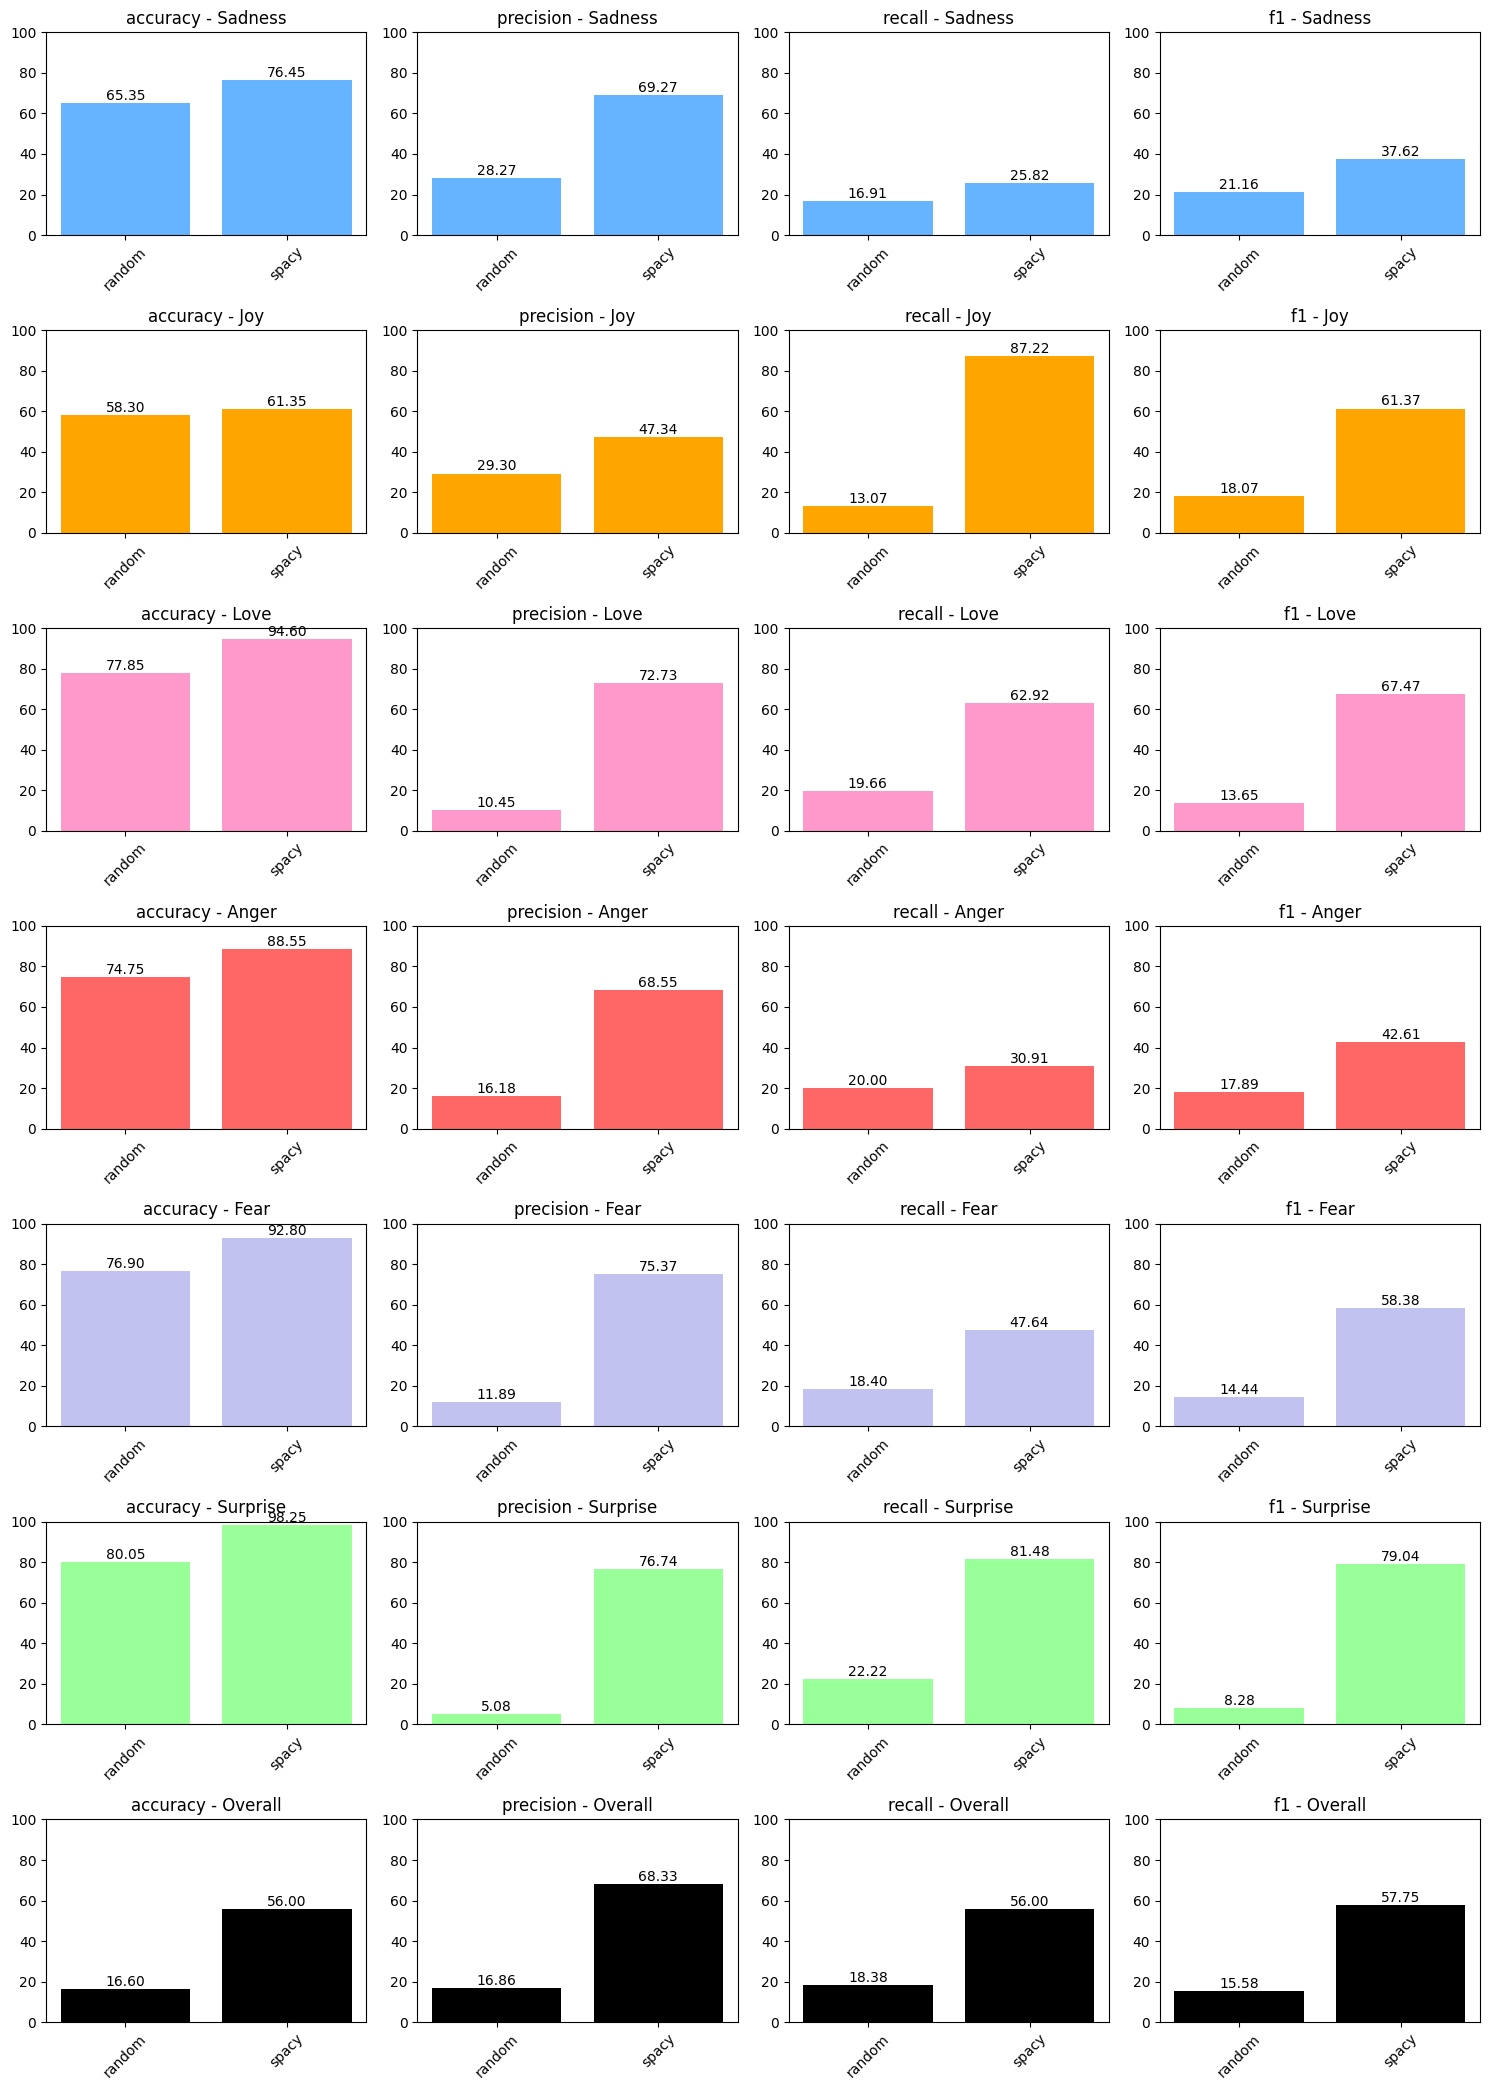

In [25]:
metrics_val.run(df_val['label'], valid_preds_rule, "spacy")
metrics_val.plot_val()

#### Confusion Matrix

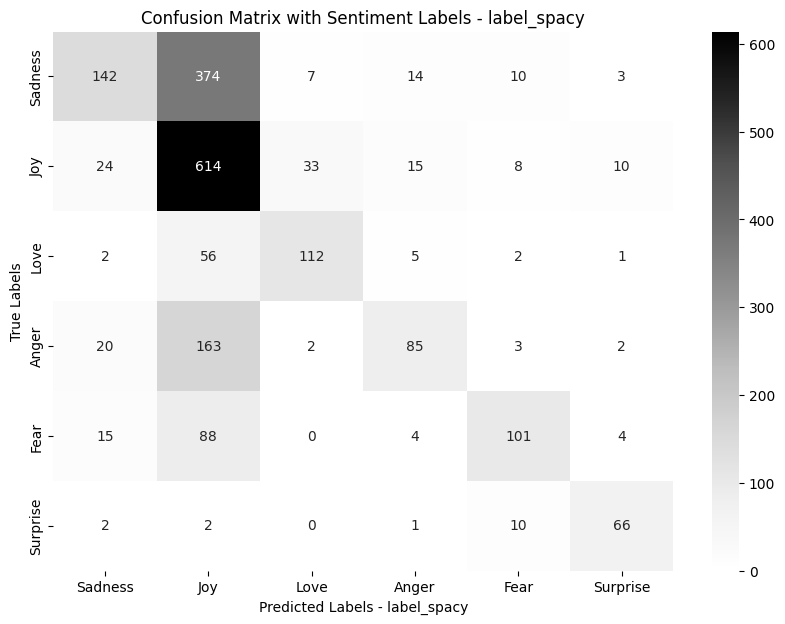

In [26]:
col = 'label_spacy'

confusion_matrix_display(df_val, col)

In [27]:
#Investigate instances where Sadness, Love, Anger, Fear are classified as Joy

col = 'label_spacy'

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
misclassifications_display(df_val, [0,2,3,4], col, 1)

Misclassified 0 (sadness) as 1 (joy) Examples:
['i feel like i am still looking at a blank canvas blank pieces of paper', 'i feel dirty and ashamed for saying that', 'i woke up often got up around am feeling pukey radiation and groggy', 'i was feeling sentimental', 'i walked out of there an hour and fifteen minutes later feeling like i had been beaten with a stick and then placed on the rack and stretched']

Misclassified 2 (love) as 1 (joy) Examples:
['i feel like a faithful servant', 'i also loved that you could really feel the desperation in these sequences and i especially liked the emotion between knight and squire as theyve been together in a similar fashion to batman and robin for a long time now', 'i feel like im caring about my body not in just an attempt to be the right size but to feel good and have a full life', 'i try to share what i bake with a lot of people is because i love people and i want them to feel loved', 'im feeling nostalgic cant beat the corys iframe allowfull

#### Test Metrics

In [28]:
# Match text with labels
test_preds_rule = df_test['text'].apply(lambda x: match_labels(x, unique_words_per_label))

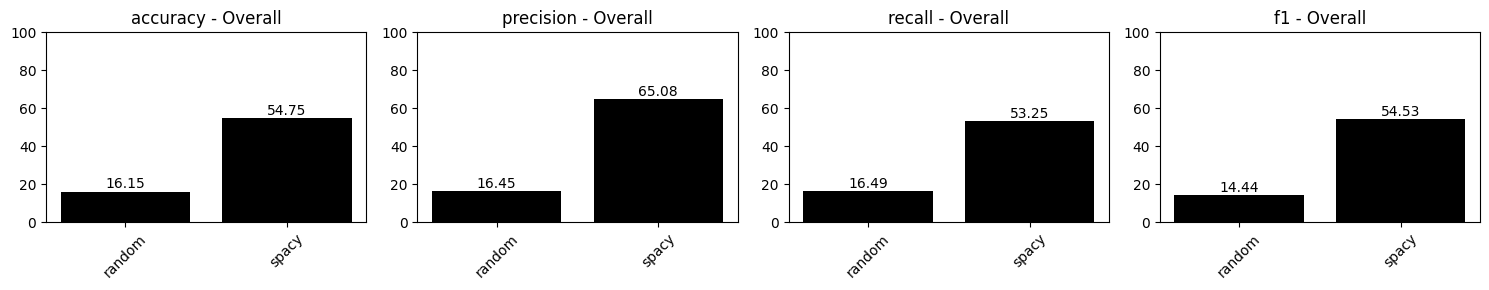

In [29]:
metrics_test.run(df_test['label'], test_preds_rule, "spacy")
metrics_test.plot()

## <a id='part2'>Part 2: Data Scientist Challenge</a>
- **Objective**: Explore different techniques to enhance model performance with limited labeled data. You will be limited to 32 labeled examples in your task. The rest can be viewed as unlabelled data.
- **Tasks:**
  - a. BERT Model with Limited Data (0.5 points): Train a BERT-based model using only 32 labeled examples and assess its performance.
  - b. Dataset Augmentation (1 point): Experiment with an automated technique to increase your dataset size without using LLMs. Evaluate the impact on model performance.
  - c. Zero-Shot Learning with LLM (0.5 points): Apply a large language model in a zero-shot learning setup. Document the performance.
  - d. Data Generation with LLM (1 point): Use a large language model to generate new, labeled dataset points. Analyze how this impacts model metrics.
  - e. Optimal Technique Application (0.5 points): Based on the previous experiments, apply the most effective technique(s) to further improve your model's performance. Comment your results.

#### Get 32 labeled examples for training

As we previously saw that our dataset with six sentiment labels was unbalanced, in the making of our 32 labeled dataset, we decided to create a balanced sample among the sentiment classification.

In [30]:
# Sample 5 examples for each label
balanced_sample = df_train.groupby('label').apply(lambda x: x.sample(5))

# Extract the index from the sampled DataFrame
sampled_index = balanced_sample.index.get_level_values(1)

# Assign the sampled index to balanced_sample as the index
balanced_sample.index = sampled_index

# Sample one extra example for labels 0 and 1
extra_example_0 = df_train[df_train['label'].isin([0])].sample(1)
extra_example_1 = df_train[df_train['label'].isin([1])].sample(1)

# Concatenate the sampled examples and extra examples
df_sample = pd.concat([balanced_sample, extra_example_0, extra_example_1])

# Shuffle the final samples
df_sample = df_sample.sample(frac=1)

df_sample.sort_values(by = ['label'], inplace = True)
df_sample.reset_index(drop = True, inplace = True)
df_sample.to_csv(path_out_+'df_sample.csv',index = False)

# Grouping by label and printing the first 2 examples from each label
for label, group in df_sample.groupby('label'):
    print(f"Data for label '{labels[label]}':")
    for index, row in group.iterrows():
        print('-', row['text'])
    print()

Data for label 'sadness':
- i feel highly disadvantaged
- i feel humiliated to introduce you to my colleagues as my wife
- i normally feel kind of awkward at birthday dinner parties since theres always someone i dont know but not this time
- i still miss him and feel rather weepy today
- im feeling so lousy they tried to cheer me up during school time and during choir practice
- i feel so worthless during those times i was struggling finding work

Data for label 'joy':
- i feel better now
- i feel very relaxed playing with carl clarke says
- i am so grateful to feel the energy of life within my body to feel the pleasant vibration in my hands feet body and head
- i feel so very honored that they asked little ol me
- i threw myself at him after all feeling genuinely pleased for him
- im feeling optimistic right now so ill project that out here

Data for label 'love':
- i mean fuck i feel like i was way more considerate with customers and concerned about appearance and sanitiation snoozel

/var/folders/tq/flmm8vn951n_wxd80fnf_vyh0000gn/T/ipykernel_18988/1808621021.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_sample = df_train.groupby('label').apply(lambda x: x.sample(5))


### 2.a BERT Model with Limited Data
*Train a BERT-based model using only 32 labeled examples and assess its performance.*

For the use of evaluating the varying data augmentation and generation techniques in the following tasks, we decided to build a basic BERT-model with a dropout layer to prevent overfitting and softmax output. We selected the pre-trained 'bert-base-uncased' as it is a more light weight BERT model to improve our run-times, and as we are performing a sentiment analysis, we assume there is no meaning tied to the case of characters, and therefore we use this BERT-model as it was trained solely on lowercased data, making it suitable to our lowercase data and sentiment purpose. 

When only using 32 labeled data points to train our model, on validation and test data, our sentiment classification performs only 10% better than a random guess, therefore very poorly. When looking at a confusion matrix of our predictions against the true labels, we see the biggest issues arise when we have a twitter message with a label that is "Joy" or "Sadness" and we predict it as "Fear".

Our performance metrics and confusion matrix lead us to believe that we do not have a sufficent amount of data to build a robust model that can classify sentiment well out of sample particularly for "Joy", "Sadness" and "Fear". In the following tasks, we hope to utilize data augmentation and data generation techniques that can increase our data size and therefore enhance our model performance.

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

def setup_bert(checkpoint="bert-base-uncased"):
    """
    Set up BERT tokenizer and model.

    Args:
        checkpoint (str): BERT model checkpoint name or path. Default is "bert-base-uncased".

    Returns:
        tokenizer: BERT tokenizer.
        model: BERT model.
    """
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = TFAutoModel.from_pretrained(checkpoint)
    return tokenizer, model

def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Create a generator that yields batches of tokenized text and corresponding labels.

    Args:
        X_train (np.array): Array of text data (features).
        y_train (np.array): Array of labels.
        tokenizer (AutoTokenizer): Tokenizer for text data.
        batch_size (int): Size of each batch.
        max_length (int): Maximum length of tokenized sequences.

    Yields:
        tuple: A tuple containing inputs and targets for each batch.
    """
    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

def build_bert_model(tokenizer, model, max_length, num_labels, rate):
    """
    Build a BERT model.

    Args:
        tokenizer (AutoTokenizer): BERT tokenizer.
        model (TFAutoModel): BERT model.
        max_length (int): Maximum length of tokenized sequences.
        num_labels (int): Number of output labels.
        rate (float): Dropout rate.

    Returns:
        tf.keras.Model: BERT model.
    """
    input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

    embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
    final_embedding_layer = embedding_layer[0]
    cls_token_embeddings = final_embedding_layer[:, 0, :]
    output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)
    output = tf.keras.layers.Dense(num_labels, kernel_initializer="glorot_uniform", activation='softmax')(output_layer)

    bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=output, name="bert_model_baseline")
    return bert_model

def train_bert_model(bert_model, batches, optimizer, num_epochs, steps_per_epoch):
    """
    Train the BERT model.

    Args:
        bert_model (tf.keras.Model): BERT model.
        batches: Batches of training data.
        optimizer: Optimizer for training.
        num_epochs (int): Number of epochs for training.
        steps_per_epoch (int): Number of steps per epoch.

    Returns:
        None
    """
    bert_model.compile(optimizer=optimizer,
                       metrics=[tf.keras.metrics.Recall(),
                                tf.keras.metrics.Precision()],
                       loss=tf.keras.losses.CategoricalCrossentropy())
    bert_model.fit(batches, epochs=num_epochs, steps_per_epoch=steps_per_epoch)

def save_model_weights(bert_model, filepath):
    """
    Save the weights of the BERT model.

    Args:
        bert_model (tf.keras.Model): BERT model.
        filepath (str): Filepath to save the weights.

    Returns:
        None
    """
    bert_model.save_weights(filepath)

def load_model_weights(tokenizer, model, max_length, num_labels, rate, filepath):
    """
    Load the weights of a BERT model.

    Args:
        tokenizer (AutoTokenizer): BERT tokenizer.
        model (TFAutoModel): BERT model.
        max_length (int): Maximum length of tokenized sequences.
        num_labels (int): Number of output labels.
        rate (float): Dropout rate.
        filepath (str): Filepath to load the weights from.

    Returns:
        tf.keras.Model: Loaded BERT model.
    """
    bert_model_loaded = build_bert_model(tokenizer, model, max_length, num_labels, rate)
    bert_model_loaded.load_weights(filepath)
    return bert_model_loaded

# Function to prepare X_train and y_train
def prepare_data(df_sample, tokenizer):
    """
    Prepare text data and labels for training.

    Args:
        df_sample (pd.DataFrame): DataFrame containing text data and labels.
        tokenizer (AutoTokenizer): Tokenizer for text data.

    Returns:
        tuple: Tuple containing X_train (text data) and y_train (labels).
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(np.array(df_sample['label']).reshape(-1, 1)).toarray()
    X_train = np.array(df_sample['text'])
    return X_train, y_train


In [59]:
def tokenize_and_predict(model, tokenizer, dataframe, max_length):
    inputs = tokenizer.batch_encode_plus(list(dataframe['text']),
                                         add_special_tokens=True, 
                                         max_length=max_length,
                                         padding='max_length', 
                                         return_attention_mask=True,
                                         return_token_type_ids=True, 
                                         truncation=True)

    inputs_data = [np.asarray(inputs['input_ids'], dtype='int32'),
                   np.asarray(inputs['attention_mask'], dtype='int32')]
    
    preds = model.predict(inputs_data)
    preds = np.argmax(preds, axis=1)
    
    return preds

### Build Model

In [36]:
tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
max_length = 64
num_labels = 6
rate = 0.5
train_batch_size = 32
learning_rate = 0.0001
num_epochs = 2

# X_train, y_train = prepare_data(df_sample, tokenizer)
# steps_per_epoch = int(len(X_train) / train_batch_size)
# batches = get_batches(X_train, y_train, tokenizer, train_batch_size, max_length)
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# bert_model = build_bert_model(tokenizer, model, max_length, num_labels, rate)
# train_bert_model(bert_model, batches, optimizer, num_epochs, steps_per_epoch)

# # Saving weights
# save_model_weights(bert_model, path_models_ + "bert_model_weights_32lab.h5")

# Loading weights
bert_model_32lab = load_model_weights(tokenizer, model, max_length, num_labels, rate, path_models_ + "bert_model_weights_32lab.h5")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

#### Validation Metrics

63/63 [==============================] - 144s 2s/step


/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


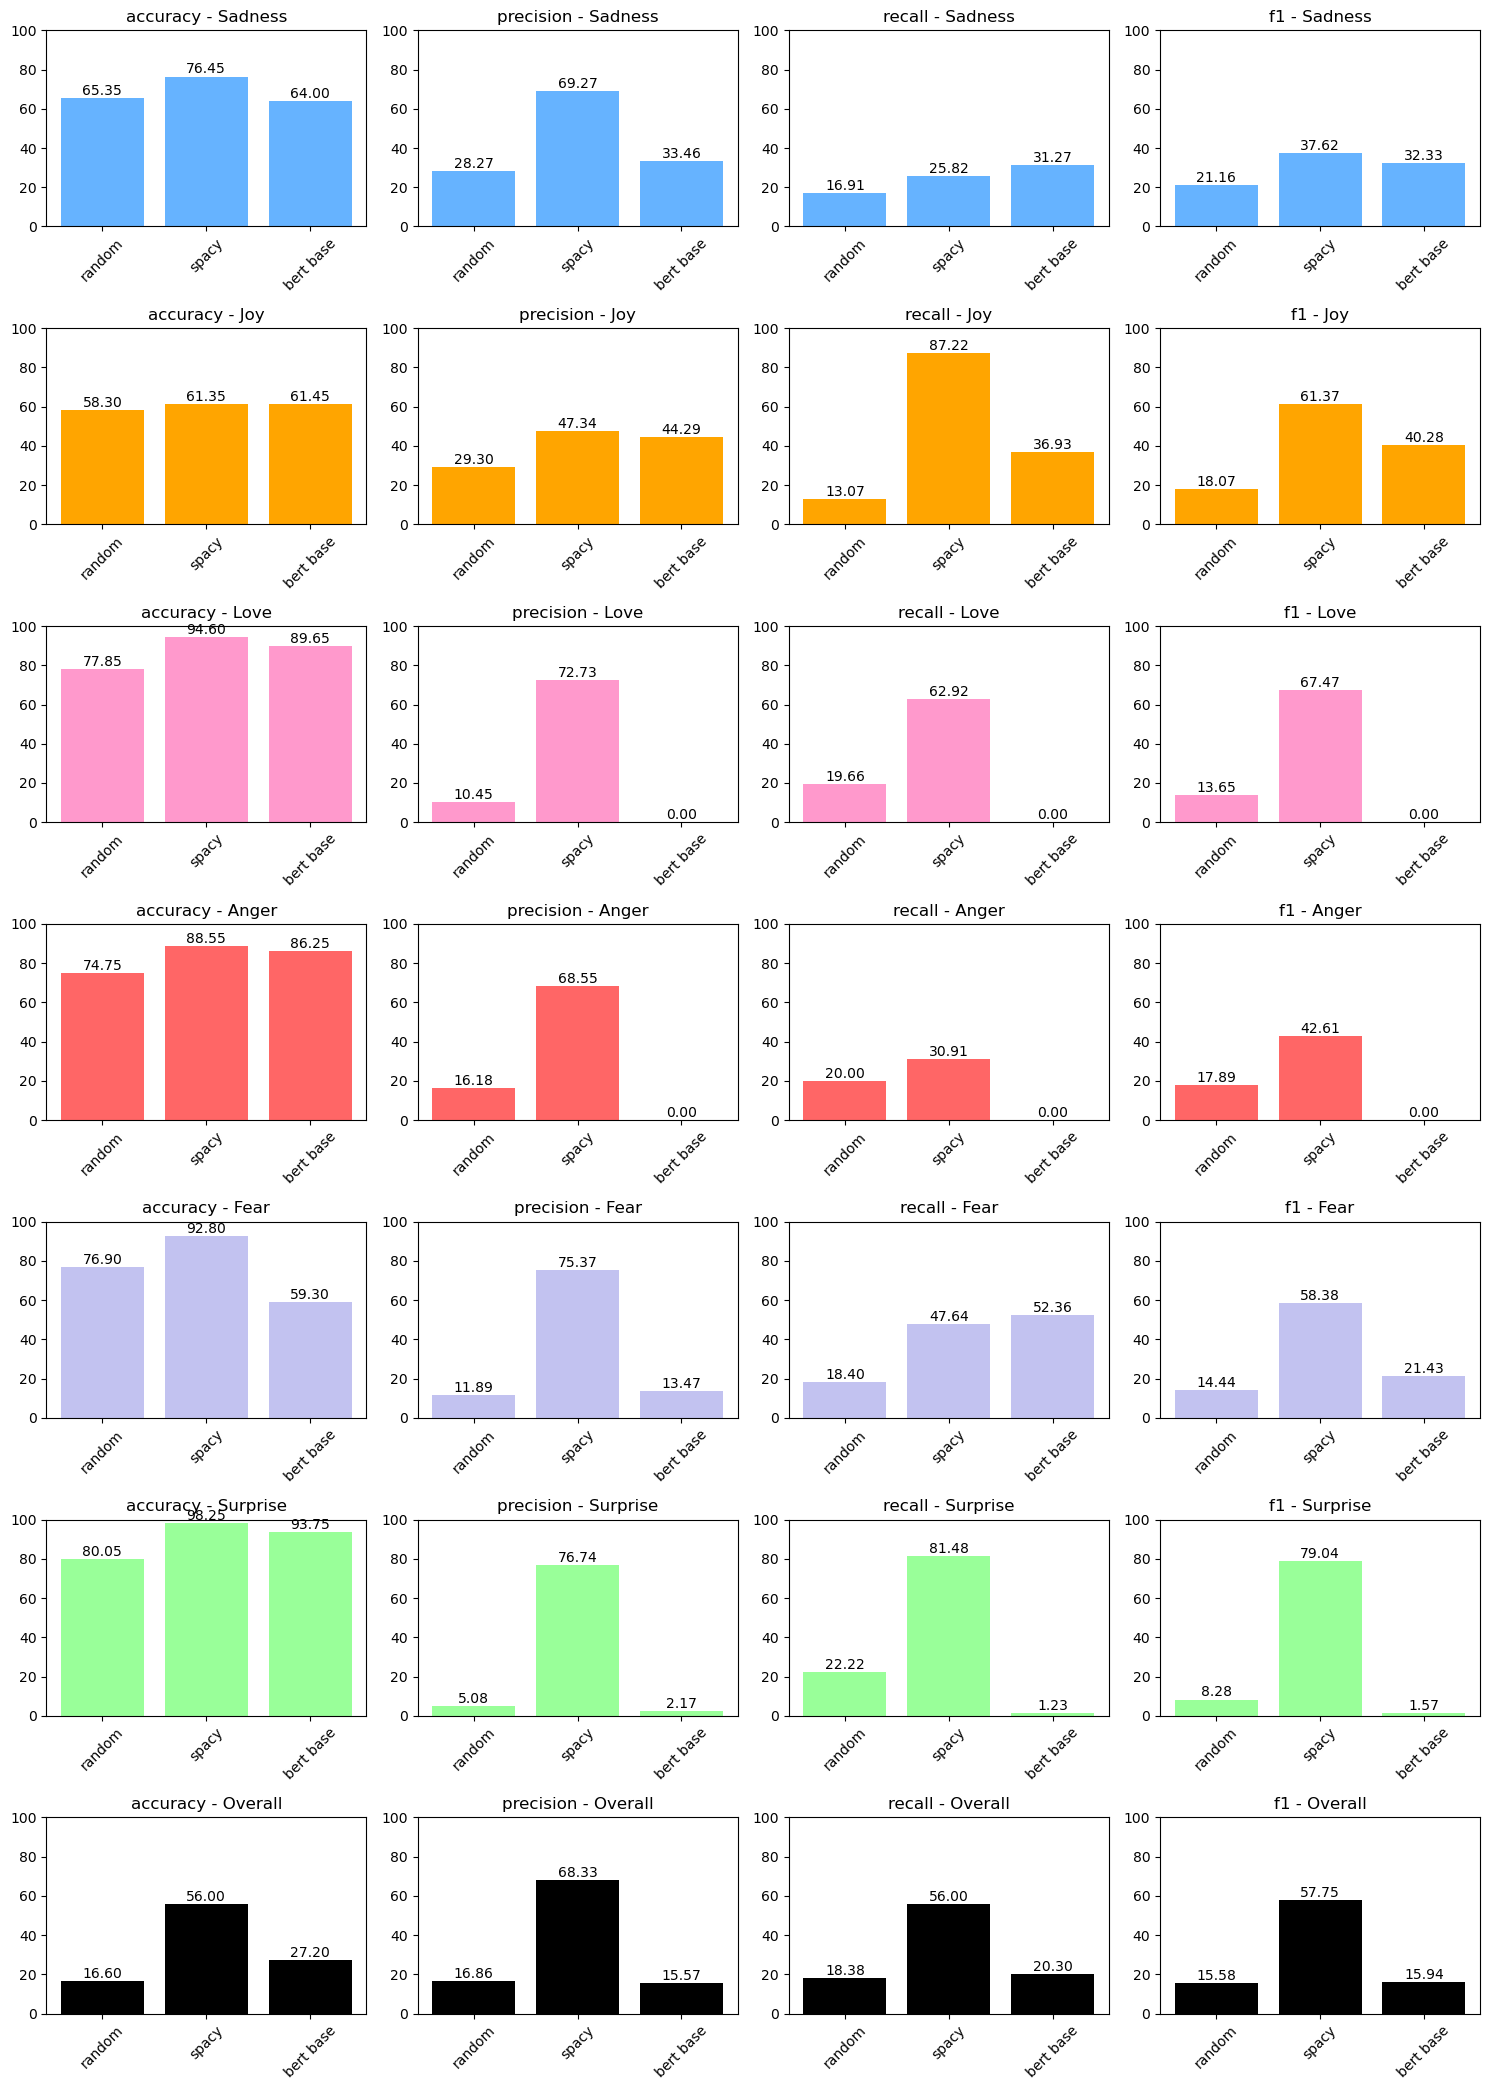

In [37]:
# Validation
valid_preds = tokenize_and_predict(bert_model_32lab, tokenizer, df_val, max_length)
df_val['label_32'] = valid_preds
metrics_val.run(df_val['label'], valid_preds, "bert base")
metrics_val.plot_val()

#### Confusion Matrix

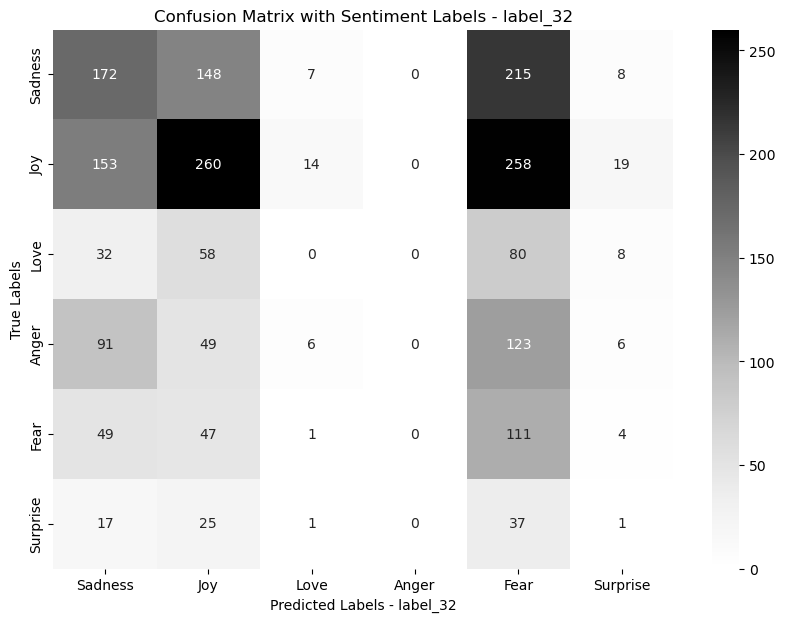

In [38]:
col = 'label_32'

confusion_matrix_display(df_val, col)

In [39]:
col = 'label_32'

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
misclassifications_display(df_val, [0,1,3], col, 4)

Misclassified 0 (sadness) as 4 (fear) Examples:
['i feel dirty and ashamed for saying that', 'i woke up often got up around am feeling pukey radiation and groggy', 'i walked out of there an hour and fifteen minutes later feeling like i had been beaten with a stick and then placed on the rack and stretched', 'i just feel like all my efforts are in vain and a waste of time', 'i would feel i missed out on a wealth of treasures if i did not read']

Misclassified 1 (joy) as 4 (fear) Examples:
['i can have for a treat or if i am feeling festive', 'i feel incredibly lucky just to be able to talk to her', 'i was dribbling on mums coffee table looking out of the window and feeling very happy', 'i never stop feeling thankful as to compare with others i considered myself lucky because i did not encounter ruthless pirates and i did not have to witness the slaughter of others', 'i feel that it is something that will never really be resolved']

Misclassified 3 (anger) as 4 (fear) Examples:
['i am ju

#### Test Metrics

63/63 [==============================] - 142s 2s/step


/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


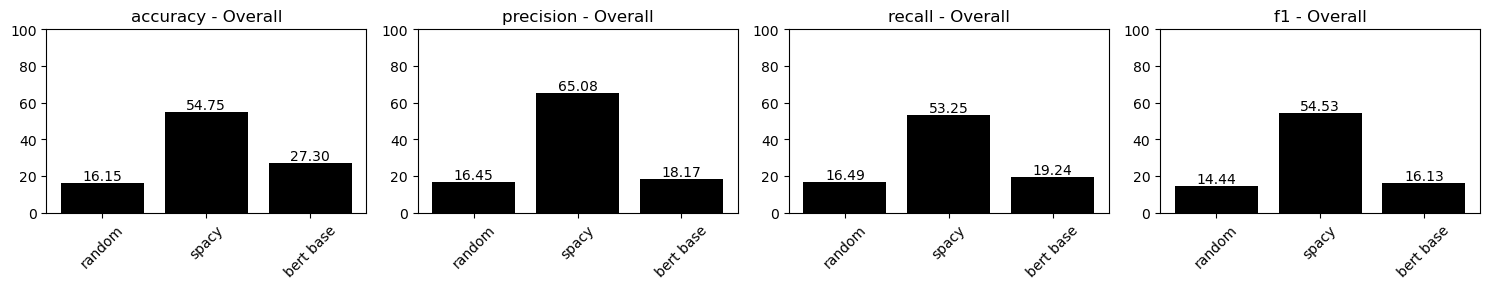

In [40]:
# Test
test_preds = tokenize_and_predict(bert_model_32lab, tokenizer, df_test, max_length)
metrics_test.run(df_test['label'], test_preds, "bert base")
metrics_test.plot()

### 2.b Dataset Augmentation
*Experiment with an automated technique to increase your dataset size without using LLMs. Evaluate the impact on model performance.*

The data augmentation techniques we investigated are synonym replacement, random insertion, random deletion and random swap. We tested these methods individually and multiple at the same time and found that using a combination of these techniques at the same time distorted grammer and in turn, overall meaning of a Twitter message too drastically. 

Previously we saw that with our base BERT-model performed worst for sentiments "Joy" and "Sadness", so we're going to test our data augmentation methods on examples from these categories and see if we can not only identify the best data augmentation techniques to increase our data size but hopefully resolve some false positives and false negatives.

We found that applying one technique at a time on the same Twitter messages and then appending all these augmented Twitter messages together into one dataset, 160 data augmented points with the original 32 for a total of 192, yielded only a minimal improvement from our base 32 data point model on out of sample performance. An unexpected consequence to this technique was seeing an increase in misclassifications across sentiments. Previously we saw misclassifications were only really over-predicting "Joy", "Sadness" and "Fear" but now we see our largest issue with "Joy" being predicted as "Love". 

In [41]:
import random
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# Function to perform synonym replacement
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

# Function to get synonyms of a word
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in 'abcdefghijklmnopqrstuvwxyz '])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

# Function to perform random insertion
def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

# Function to add a random word to the sentence
def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        if len(new_words) >= 1:
            random_word = new_words[random.randint(0, len(new_words)-1)]
            synonyms = get_synonyms(random_word)
            counter += 1
            if counter >= 10:
                return
    random_synonym = synonyms[random.randint(0, len(synonyms)-1)]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

# Function to perform random deletion
def random_deletion(words, p):
    if len(words) == 1:
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p, words))
    if len(remaining) == 0:
        return [random.choice(words)]
    return remaining

# Function to perform random swap
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

# Function to swap words in a sentence
def swap_word(new_words):
    if len(new_words) <= 1:
        return new_words
    idx1, idx2 = random.sample(range(len(new_words)), 2)
    new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

In [42]:
# Example usage from label 0 - Sadness
sentence = "i love it dont get me wrong i just dont want to keep feeling lame whilst i learn"
tokenized_sentence = word_tokenize(sentence)

# Perform augmentations
augmented_sentences = []
augmented_sentences.append(' '.join(synonym_replacement(tokenized_sentence,1)))
augmented_sentences.append(' '.join(random_insertion(tokenized_sentence,1)))
augmented_sentences.append(' '.join(random_deletion(tokenized_sentence,.2)))
augmented_sentences.append(' '.join(random_swap(tokenized_sentence,1)))

print("Evaluating techniques one at a time:")
print(f" Original sentence  : {sentence}")

# Print augmented sentences
for i, sent in enumerate(augmented_sentences):
    print(f"Augmented sentence {i+1}: {sent}")

Evaluating techniques one at a time:
 Original sentence  : i love it dont get me wrong i just dont want to keep feeling lame whilst i learn
Augmented sentence 1: i love it dont get me wrong i just dont want to bread and butter feeling lame whilst i learn
Augmented sentence 2: i love it maine dont get me wrong i just dont want to keep feeling lame whilst i learn
Augmented sentence 3: i love dont me just dont to feeling lame whilst i learn
Augmented sentence 4: i love it dont get me wrong i want dont just to keep feeling lame whilst i learn


In [44]:
# Example usage from label 1 - Joy
sentence = "i only need to feel respected and safe"
tokenized_sentence = word_tokenize(sentence)

# Perform augmentations
augmented_sentences = []
augmented_sentences.append(' '.join(synonym_replacement(tokenized_sentence,1)))
augmented_sentences.append(' '.join(random_insertion(tokenized_sentence,1)))
augmented_sentences.append(' '.join(random_deletion(tokenized_sentence,.2)))
augmented_sentences.append(' '.join(random_swap(tokenized_sentence,1)))

print("Evaluating techniques one at a time:")
print(f" Original sentence  : {sentence}")

# Print augmented sentences
for i, sent in enumerate(augmented_sentences):
    print(f"Augmented sentence {i+1}: {sent}")

Evaluating techniques one at a time:
 Original sentence  : i only need to feel respected and safe
Augmented sentence 1: i only need to feel prise and safe
Augmented sentence 2: i only need palpate to feel respected and safe
Augmented sentence 3: i only need to respected and safe
Augmented sentence 4: to only need i feel respected and safe


In [45]:
# Create a new DataFrame to store augmented data
augmented_data = {'text': [], 'label': []}

# Iterate through each row in df_sample
for index, row in df_sample.iterrows():
    original_text = row['text']
    label = row['label']
    augmented_sentences = []
    augmented_sentences.append(' '.join(synonym_replacement(word_tokenize(original_text),1)))
    augmented_sentences.append(' '.join(random_insertion(word_tokenize(original_text),1)))
    augmented_sentences.append(' '.join(random_deletion(word_tokenize(original_text),.2)))
    augmented_sentences.append(' '.join(random_swap(word_tokenize(original_text),1)))
    
    # Add original text and its corresponding label
    augmented_data['text'] += augmented_sentences
    augmented_data['label'] += [label] * len(augmented_sentences)

# Create a DataFrame from the augmented data
df_augmented = pd.DataFrame(augmented_data)

df_augmented = pd.concat([df_sample, df_augmented], ignore_index=True)

# Save the augmented data as a CSV file
df_augmented.to_csv(path_models_+'augmented_data_update.csv', index=False)

print("Augmented data saved successfully.")

Augmented data saved successfully.


In [46]:
df_augmented.head()

text  label
0  i am feeling sorry for myself because someone ...      0
1  i want other sufferers to be able to find me i...      0
2  i never thought id feel at peace about our tra...      0
3  i was a bit too nervous to focus on the faces ...      0
4  i wake up already feeling listless and have be...      0

#### Build Model

In [47]:
tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
max_length = 64
num_labels = 6
rate = 0.5
train_batch_size = 32
learning_rate = 0.0001
num_epochs = 2

# #combine with the original data sample
# df_sample_w_aug = pd.concat([df_sample, df_augmented], ignore_index = True)

# X_train, y_train = prepare_data(df_sample_w_aug, tokenizer)
# steps_per_epoch = int(len(X_train) / train_batch_size)
# batches = get_batches(X_train, y_train, tokenizer, train_batch_size, max_length)
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# bert_model = build_bert_model(tokenizer, model, max_length, num_labels, rate)
# train_bert_model(bert_model, batches, optimizer, num_epochs, steps_per_epoch)

# # Saving weights
# save_model_weights(bert_model, path_models_ + "bert_model_weights_32augment_update.h5")

# Loading weights
bert_model_32augment = load_model_weights(tokenizer, model, max_length, num_labels, rate, path_models_ + "bert_model_weights_32augment_update.h5")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

#### Validation Metrics

63/63 [==============================] - 147s 2s/step


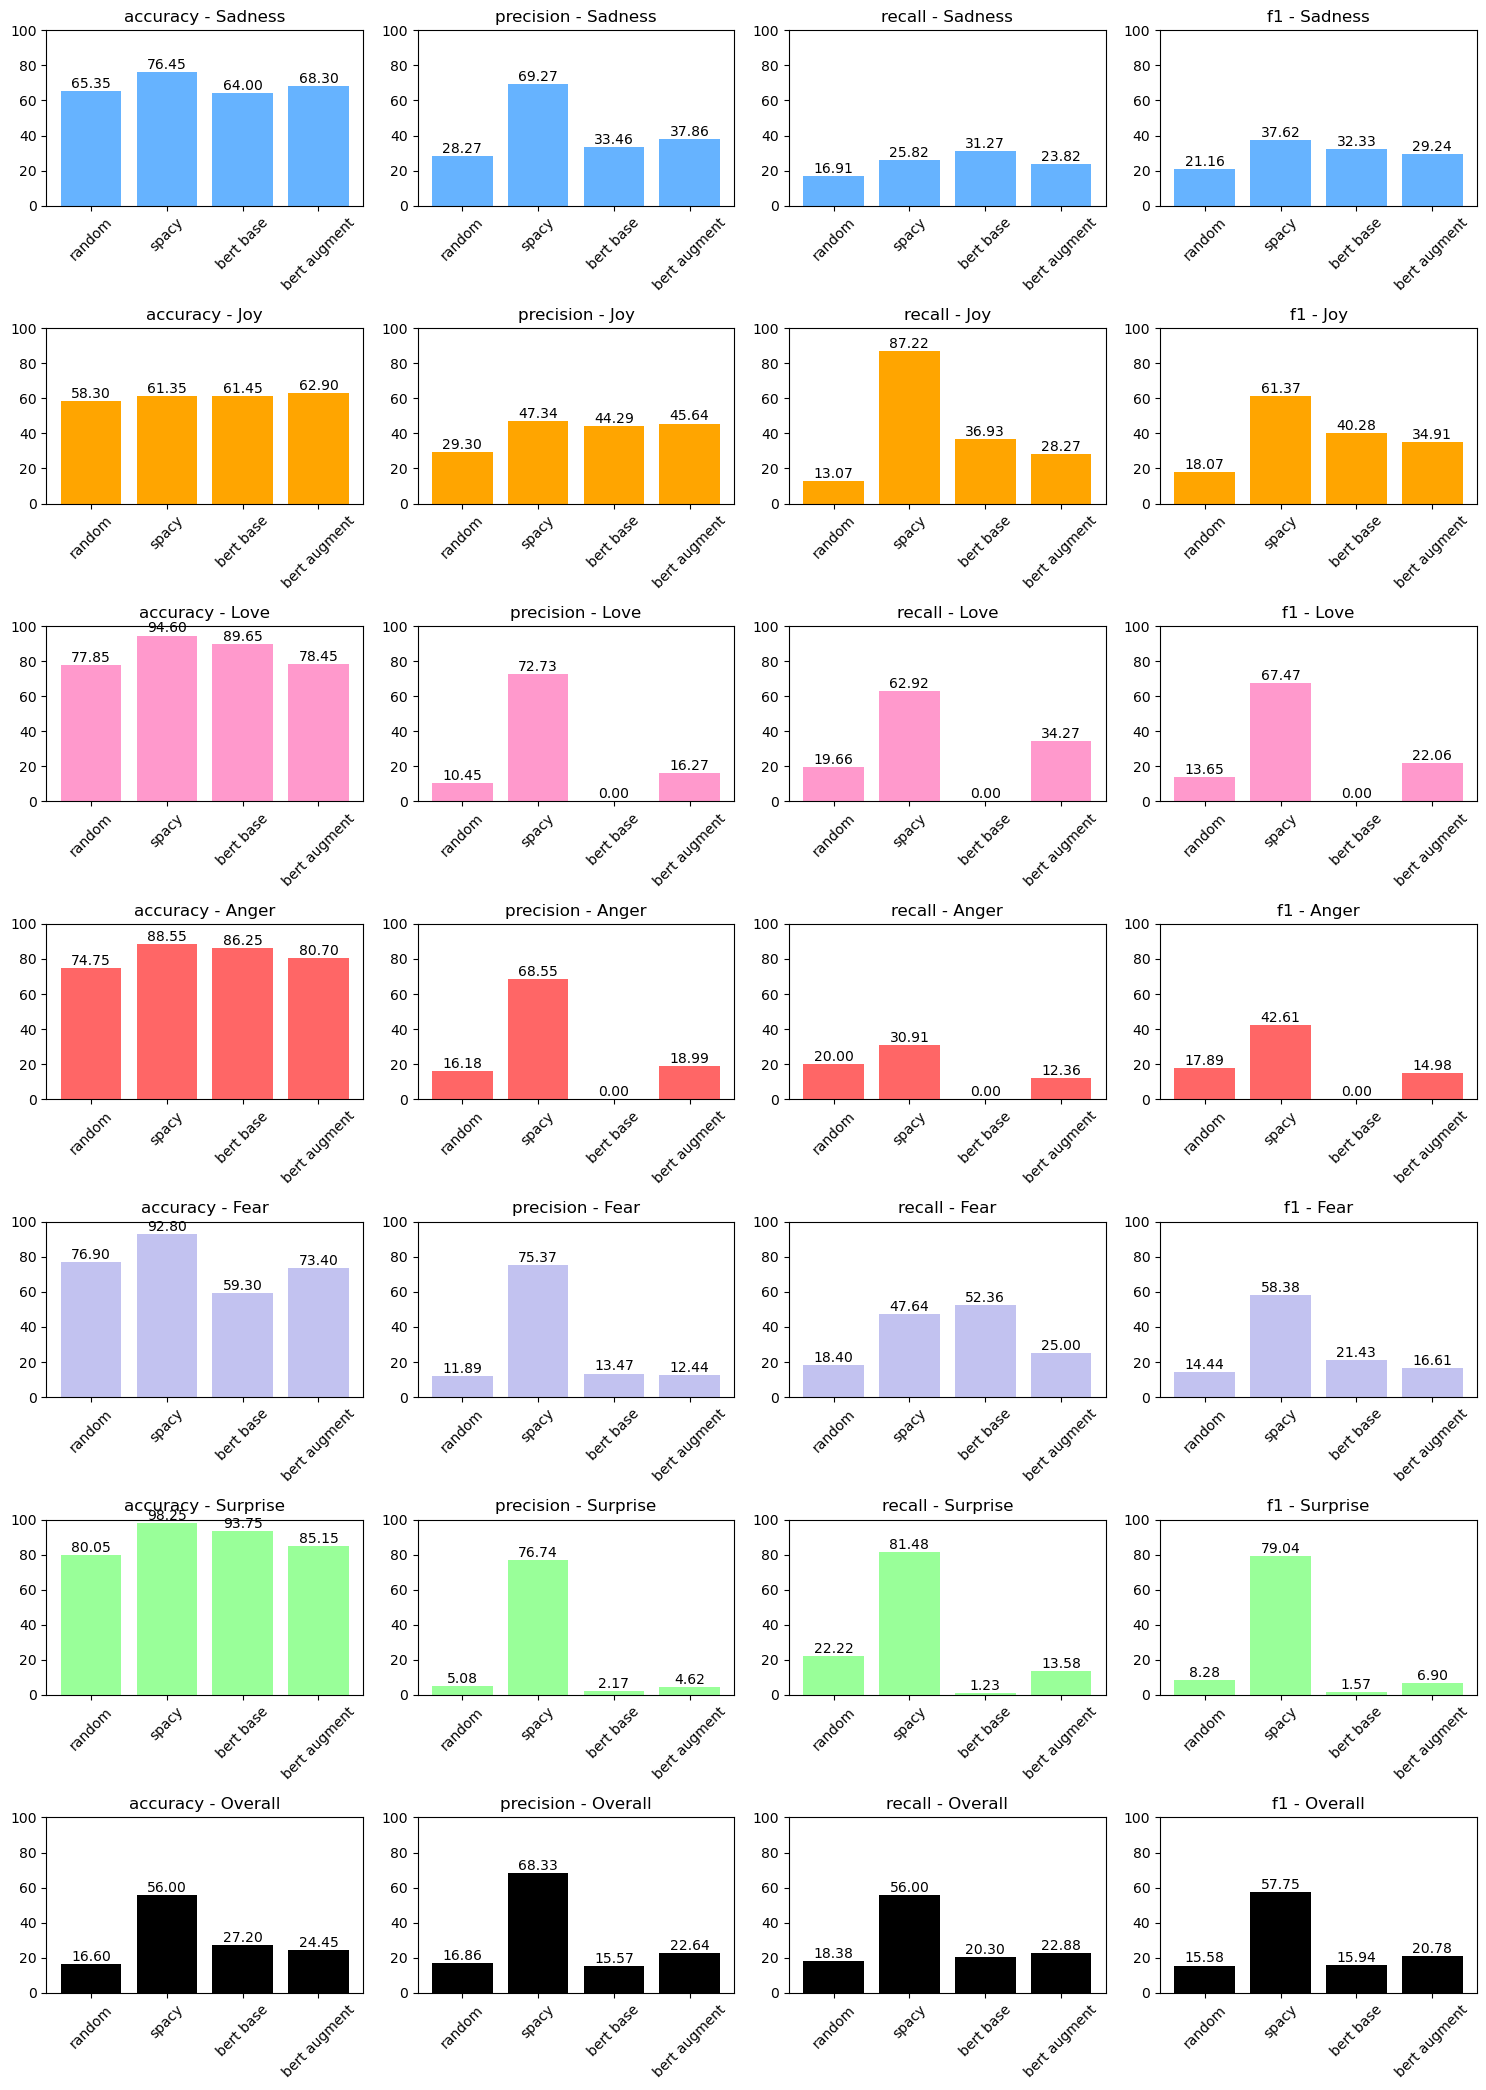

In [48]:
# Validation
valid_preds = tokenize_and_predict(bert_model_32augment, tokenizer, df_val, max_length)
df_val['label_data_aug'] = valid_preds
metrics_val.run(df_val['label'], valid_preds, "bert augment")
metrics_val.plot_val()

#### Confusion Matrix

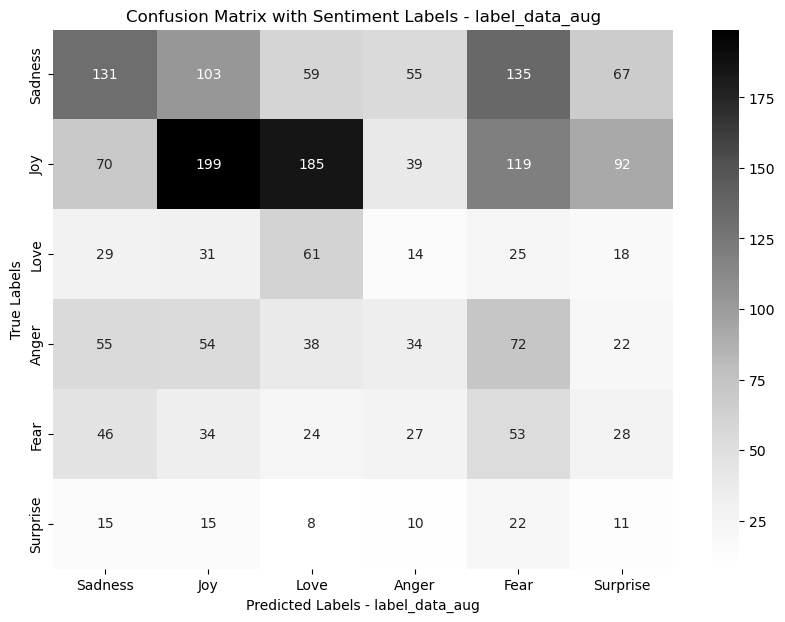

In [49]:
col = 'label_data_aug'

confusion_matrix_display(df_val, col)

In [51]:
col = 'label_32'

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
misclassifications_display(df_val, [1], col, 2)
misclassifications_display(df_val, [1], col, 4)
misclassifications_display(df_val, [0], col, 4)
misclassifications_display(df_val, [0], col, 1)

Misclassified 1 (joy) as 2 (love) Examples:
['i have found in the past when i blog daily i have more to say and i get out my feelings and emotions in more creative ways', 'i feel that popular culture especially in the uk and the usa is mired in an unsavoury mix squalor and stupidity', 'i read somewhere that even if the rest of the relationship is perfect and there is one problem that can t be solved or you feel isn t being resolved it will consume the rest of the relationship', 'i feel i should say what i want since you are in fact reading my diary i feel that many of my beloved readers are becoming offended with some of the things i say and post here', 'i don t mean this to be harsh selfish or uncaring but i feel that my readers will benefit most from the content that i provide rather than what is linked to a party']

Misclassified 1 (joy) as 4 (fear) Examples:
['i can have for a treat or if i am feeling festive', 'i feel incredibly lucky just to be able to talk to her', 'i was dribbl

#### Test Metrics

63/63 [==============================] - 149s 2s/step


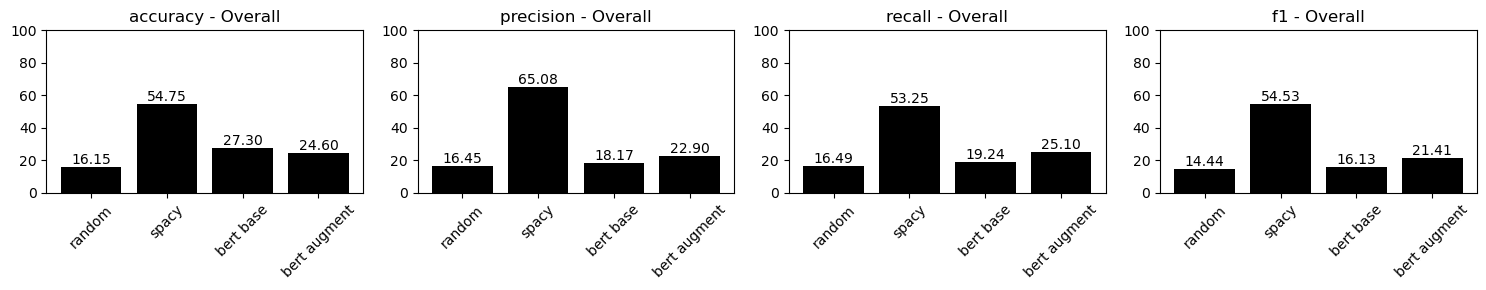

In [52]:
# Test
test_preds = tokenize_and_predict(bert_model_32augment, tokenizer, df_test, max_length)
metrics_test.run(df_test['label'], test_preds, "bert augment")
metrics_test.plot()

### 2.c Zero-Shot Learning with LLM
*Apply a large language model in a zero-shot learning setup. Document the performance.*

We opted for a straightforward approach by using zero-shot learning to classify labels in our validation and test datasets directly. Another approach could have involved using zero-shot learning to classify the training data first, followed by training a model on this data to classify validation and test datasets. However, we avoided this method because any bias present in the zero-shot labeled training data would likely be perpetuated or even exacerbated by the model, as it may not effectively learn these nuanced patterns. For classifying labels, we chose to use the actual text descriptions of the labels rather than numeric identifiers, assisting the model, roberta-large-mnli, in making more accurate classifications.

Zero-shot learning with roberta-large-mnli allows the model to classify text into categories it hasn't seen during training by comprehending both the textual content and category descriptions. By utilizing its pre-trained knowledge across various language tasks, it infers connections between the text and unseen labels, making informed predictions about the appropriate category. While it surpasses our previous models, likely attributed to its extensive pre-training data and its ability to extract deeper semantic meanings compared to our model trained on a limited dataset of 32 labeled examples, its performance still falls considerably short of state-of-the-art levels.

In [53]:
zero_shot_preds_df = pd.read_csv(path_models_+'zero-shot-preds.csv')

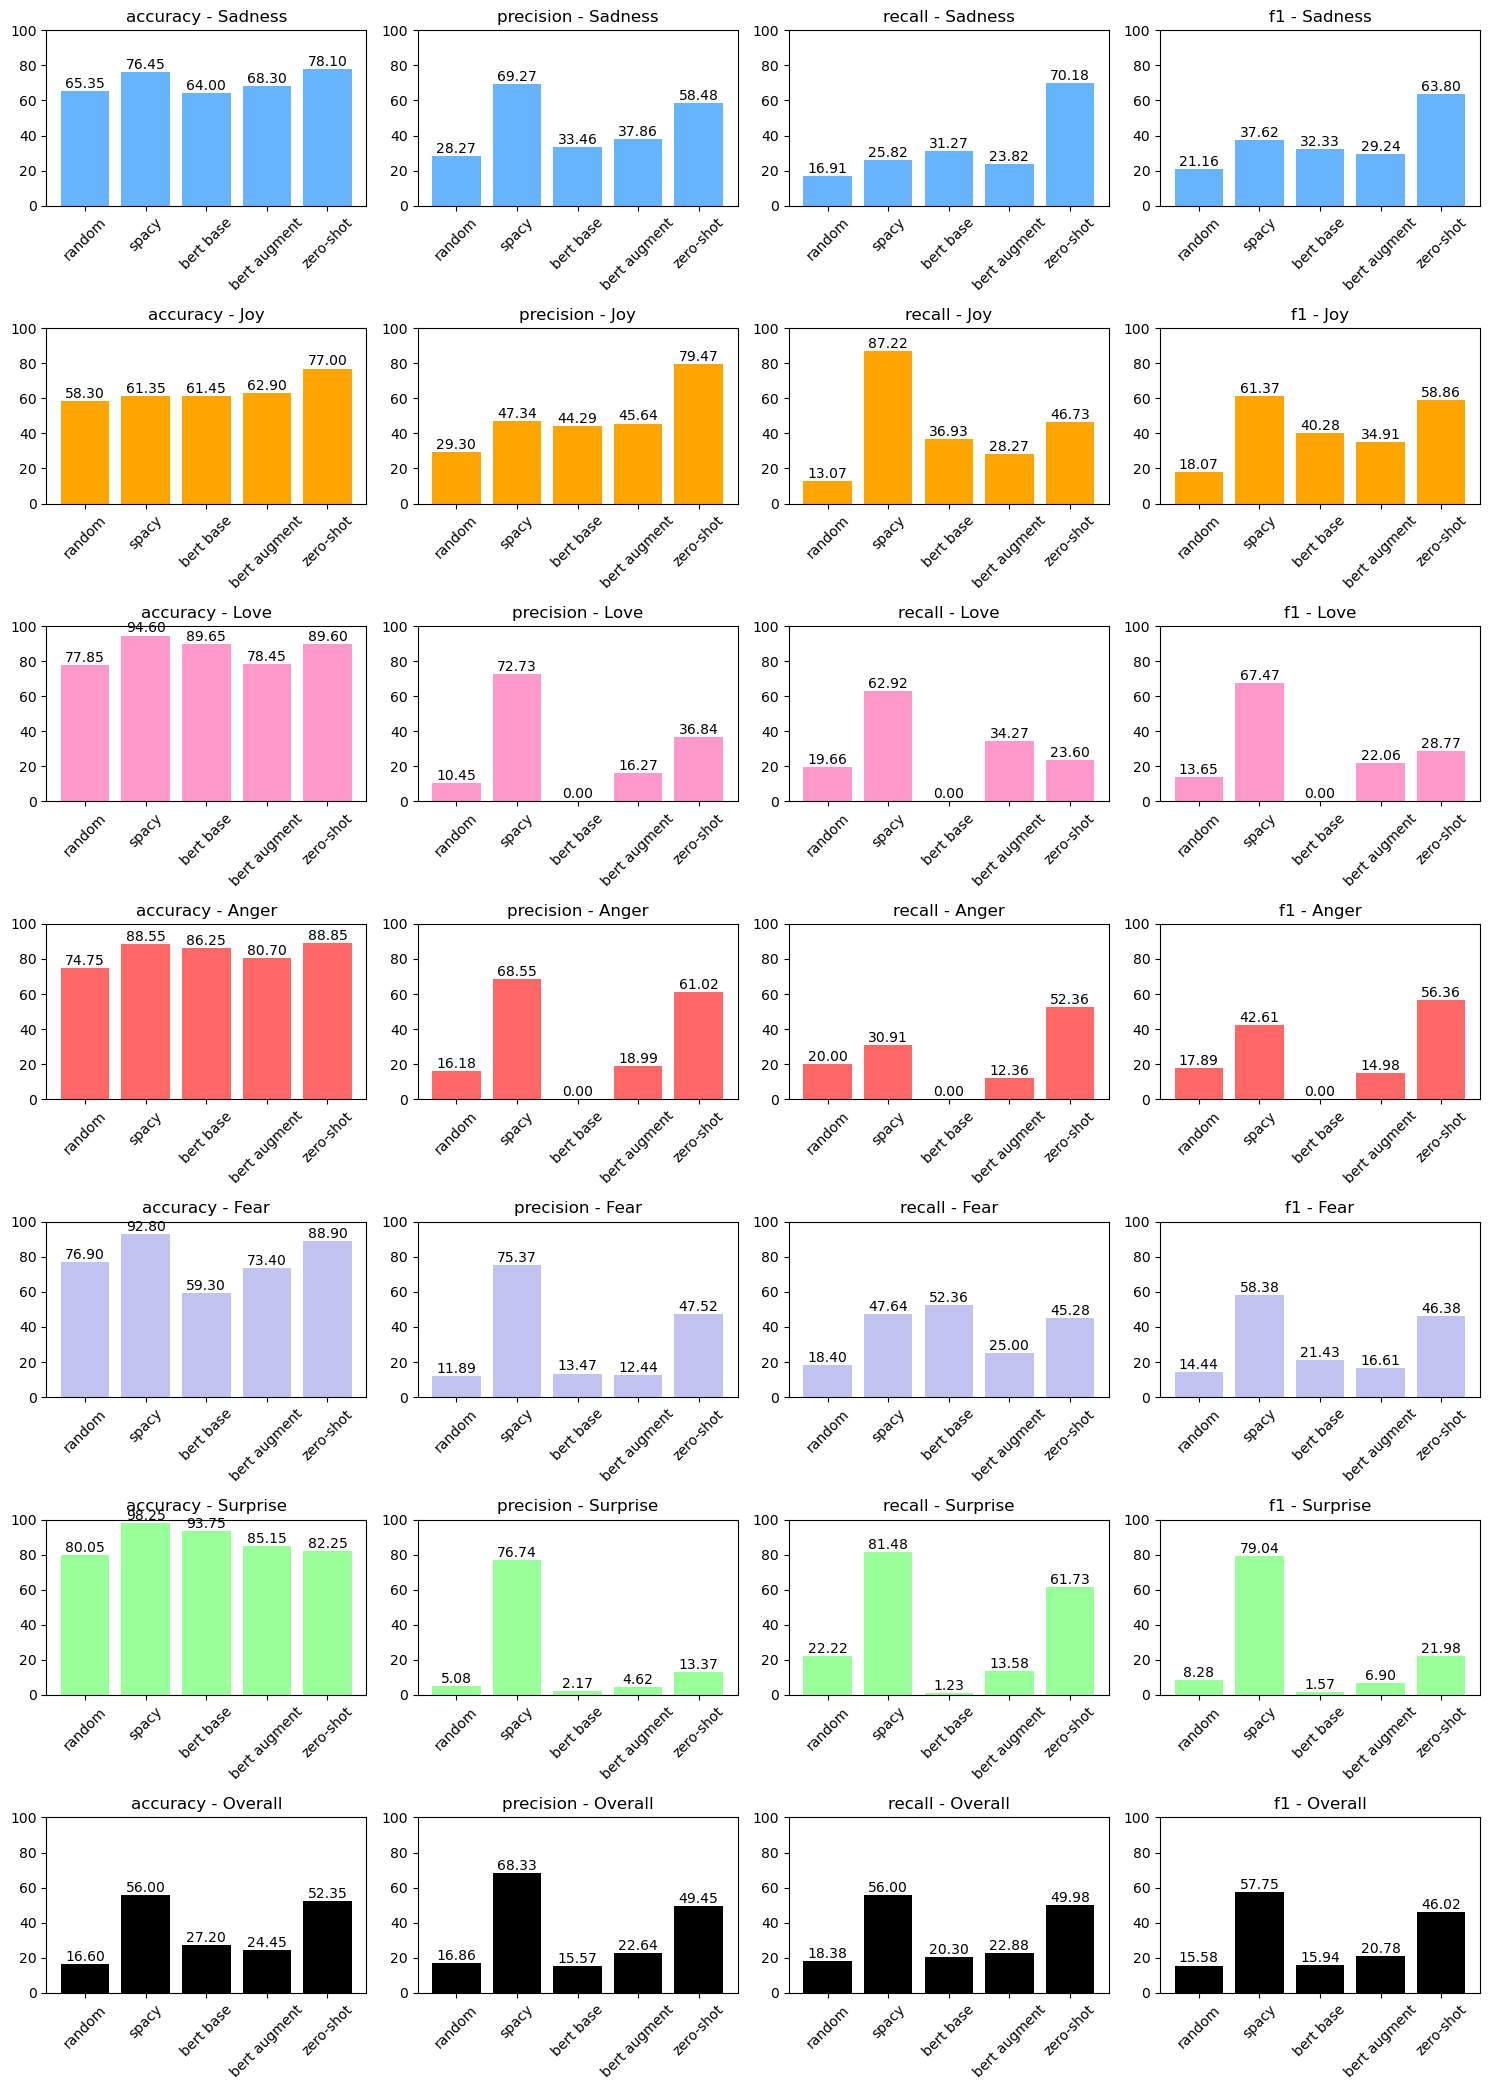

In [55]:
metrics_val.run(df_val['label'], zero_shot_preds_df['preds'], "zero-shot")
metrics_val.plot_val()

#### Confusion Matrix

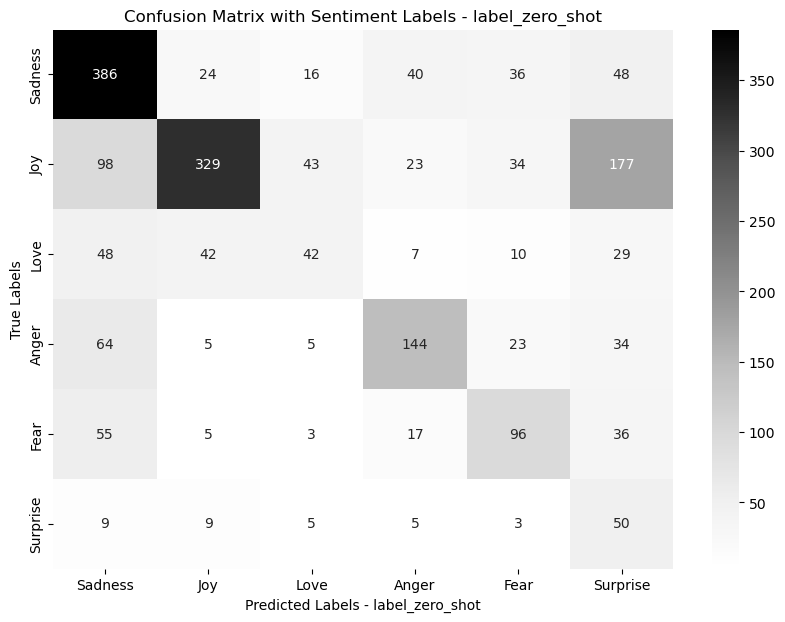

In [56]:
df_zero = zero_shot_preds_df.copy()
df_zero.columns = ['label','label_zero_shot']

col = 'label_zero_shot'

confusion_matrix_display(df_zero, col)

In [68]:
col = 'label_zero_shot'

#combine the validation and zero-shot prediciton together to display misclassified examples
df_zero = zero_shot_preds_df.copy()
df_zero.columns = ['label','label_zero_shot']
df_zero.reset_index(inplace = True)
df_val_join = df_val.copy()
df_val_join.reset_index(inplace = True)
df_zero = df_zero.merge(df_val_join, how = 'left', on = ['index'])

df_view = df_zero[df_zero['label_x']!=df_zero['label_y']]
print(len(df_view['label_x']))

df_zero.columns = ['index', 'label', 'label_zero_shot', 'text', 'label_y', 'label_spacy',
       'label_32', 'label_data_aug']

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
misclassifications_display(df_zero, [1], col, 5)
misclassifications_display(df_zero, [1], col, 0)
misclassifications_display(df_zero, [3], col, 0)

0
Misclassified 1 (joy) as 5 (surprise) Examples:
['i am feeling more confident that we will be able to take care of this baby', 'i feel a special draw toward and awed admiration for the firefighters who led the charge into the towers when everyone else was rushing out', 'i hope he will pull out the tissue paper himself but i feel like to him sunday will be just another day to be cute and wonderful', 'i am actually feeling a little triumphant watching this economic crisis unfold', 'i feel like a graph doesnt show the data accurately enough to be useful']

Misclassified 1 (joy) as 0 (sadness) Examples:
['i feel less keen about the army every day', 'i had lunch with an old friend and it was nice but in general im not feeling energetic', 'i feel that it is something that will never really be resolved', 'i didn t feel accepted', 'i feel that this is important in itself the fact that we all have our own individual way of grieving']

Misclassified 3 (anger) as 0 (sadness) Examples:
['i am ju

In [69]:
zero_shot_preds_df = pd.read_csv(path_models_+'zero-shot-testpreds.csv')

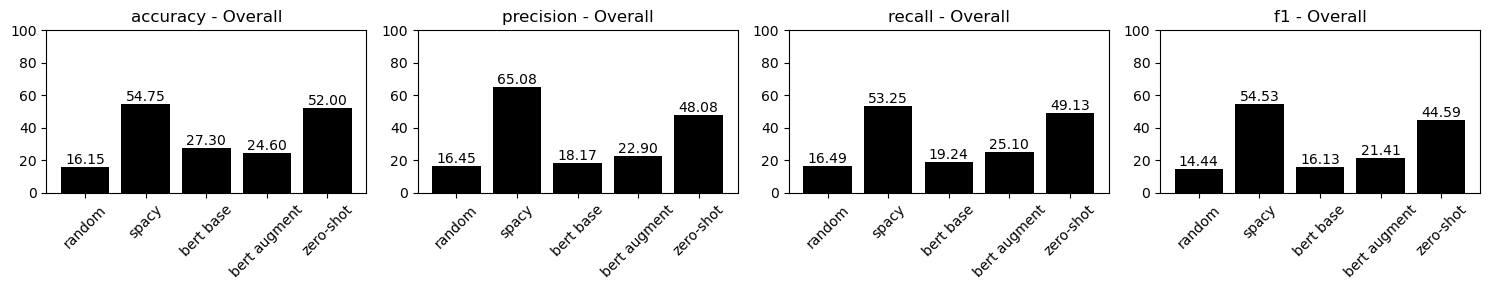

In [70]:
metrics_test.run(df_test['label'], zero_shot_preds_df['preds'], "zero-shot")
metrics_test.plot()

### 2.d Data Generation with LLM
*Use a large language model to generate new, labeled dataset points. Analyze how this impacts model metrics.*

We used our 32-labeled twitter messages and the prompt "Generate a few different texts similar to the examples provided which also convey the emotion: ({label})" to generate almost 500 new labeled twitter messages and trained a model of the same architecture as previously defined.

While our model trained on generated data didn't outperform zero-shot, the misclassifications did not lead us to believe that our model was too far off. For example, this message "i am just feeling cranky and blue" in our data is classified as "Anger" but our model classified it as "Sadness" which we see the twitter message could be classified as either. Another example, "i feel absolutely foolish for allowing myself to actually believe that this might be it for us the month weve been praying so hard for" in our data is classified as "Joy" but our model classified it as "Surprise" which again we could intuitively see the message being classified as either. So although our data generated trained model has misclassifications, it appear in cases where the lines between two sentiments are somewhat blurred.

In [71]:
labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Initialize empty lists for each label
example_texts = {label: [] for label in labels}

# Iterate through each row in df_sample and append 'text' to the corresponding label list
for index, row in df_sample.iterrows():
    label = row['label']
    text = row['text']
    example_texts[label].append(text)

# Print the lists
for label, text_list in example_texts.items():
    print(f"Label {label} ({labels[label]}) Examples:")
    print(text_list[0:2])
    print()

Label 0 (sadness) Examples:
['i am feeling sorry for myself because someone made fun of my outfit', 'i want other sufferers to be able to find me in the hope that my battle can help them to feel that they are not alone']

Label 1 (joy) Examples:
['i feel valued by just contributing what i know of and share what id discovered with others', 'i feel like cupcakes might be getting a bit too popular for their own good but i still love me a good red velvet so im not complaining quite yet']

Label 2 (love) Examples:
['i have spent the majority of my life trying to change how i look in order to feel accepted by others to feel loved by other to feel better than people around me because in my mind my physicality is the only thing that i have to offer', 'i sometimes feel nostalgic happy restless angry all at the same time']

Label 3 (anger) Examples:
['i very much enjoyed the build up and the air of suspense and confusion throughout but i cant help but feel dissatisfied by the ending', 'i am feel

In [72]:
open_ai_df = pd.read_csv(path_models_+'open_ai_df_clean.csv')

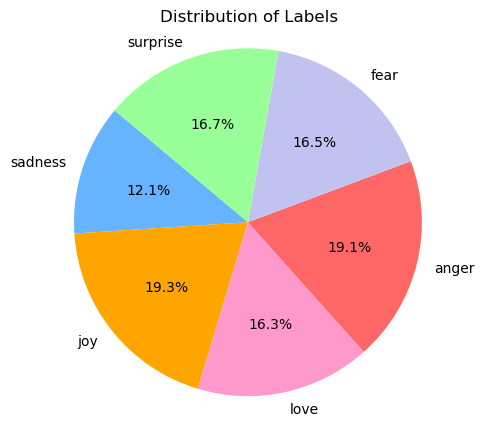

In [73]:
# Count occurrences of each label
label_counts = {}
for label in open_ai_df['label']:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Custom color palette: 
colors = ['#66b3ff', '#ffa500', '#ff99cc', '#ff6666', '#c2c2f0', '#99ff99']

# Create a pie chart
sizes = [label_counts[label] for label in range(len(labels))]
labels_str = [labels[label] for label in range(len(labels))]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels_str, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Labels')
plt.show()

#### Build Model

In [74]:
tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
max_length = 64
num_labels = 6
rate = 0.5
train_batch_size = 32
learning_rate = 0.0001
num_epochs = 2

# X_train, y_train = prepare_data(open_ai_df, tokenizer)
# steps_per_epoch = int(len(X_train) / train_batch_size)
# batches = get_batches(X_train, y_train, tokenizer, train_batch_size, max_length)
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# bert_model = build_bert_model(tokenizer, model, max_length, num_labels, rate)
# train_bert_model(bert_model, batches, optimizer, num_epochs, steps_per_epoch)

# # Saving weights
# save_model_weights(bert_model, path_models_ + "bert_model_weights_32openai.h5")

# Loading weights
bert_model_32openai = load_model_weights(tokenizer, model, max_length, num_labels, rate, path_models_ + "bert_model_weights_32openai.h5")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

#### Validation Metrics

63/63 [==============================] - 157s 2s/step


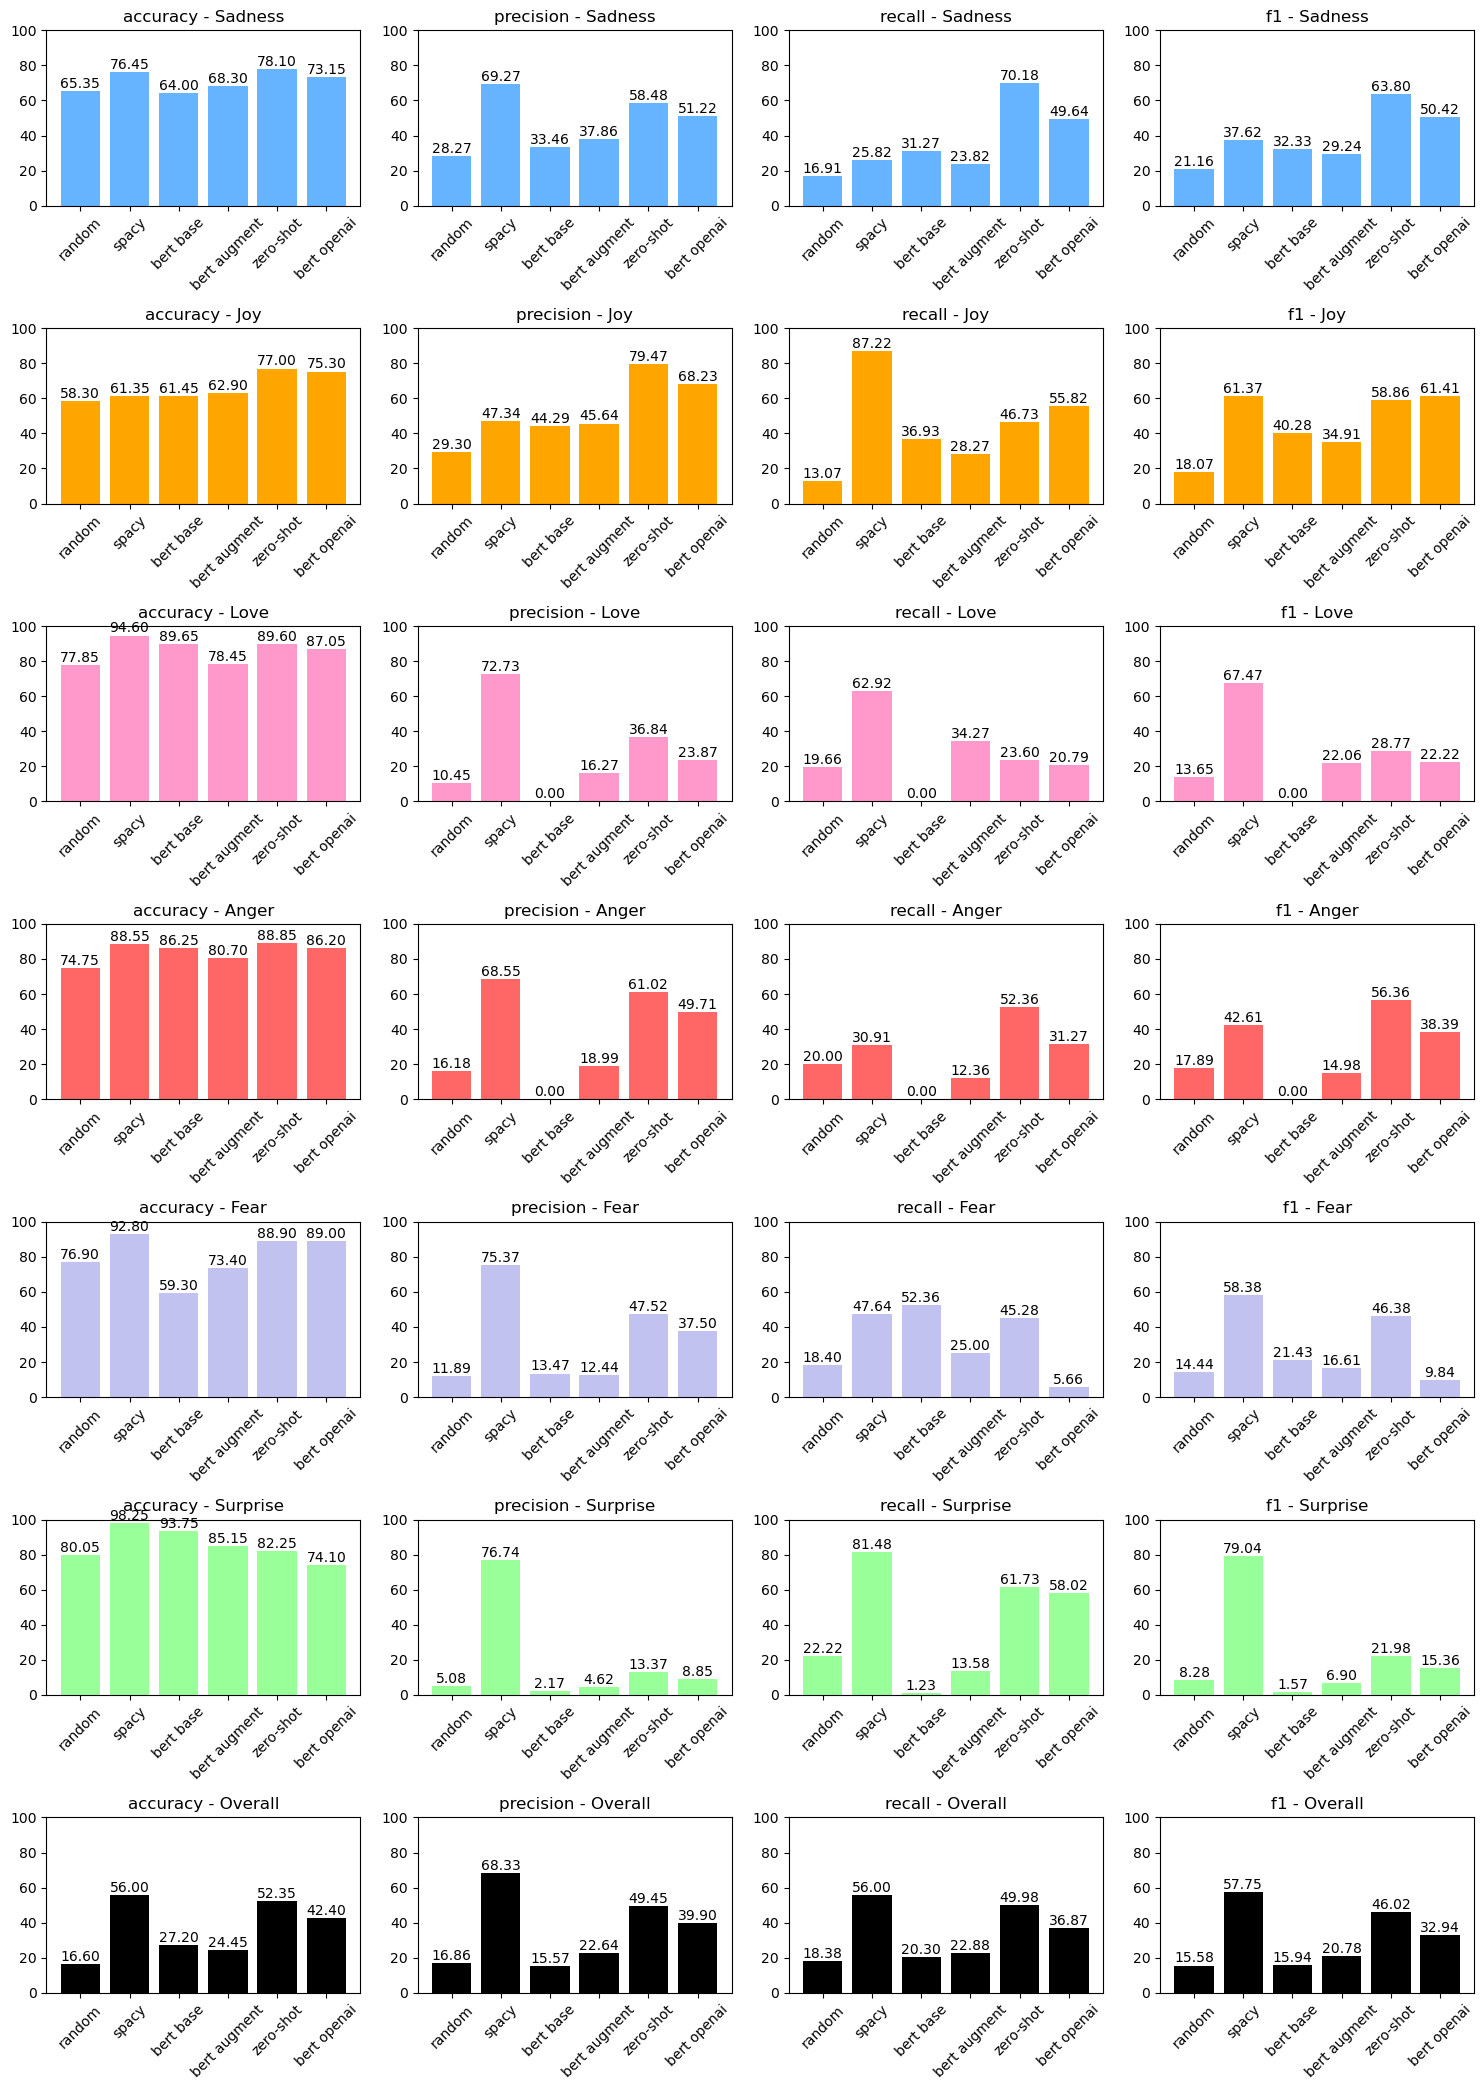

In [75]:
# Validation
valid_preds = tokenize_and_predict(bert_model_32openai, tokenizer, df_val, max_length)
metrics_val.run(df_val['label'], valid_preds, "bert openai")
metrics_val.plot_val()

df_val['openai'] = valid_preds
metrics_val_ai.run(df_val['label'], df_val['openai'], "bert openai")

#### Confusion Matrix

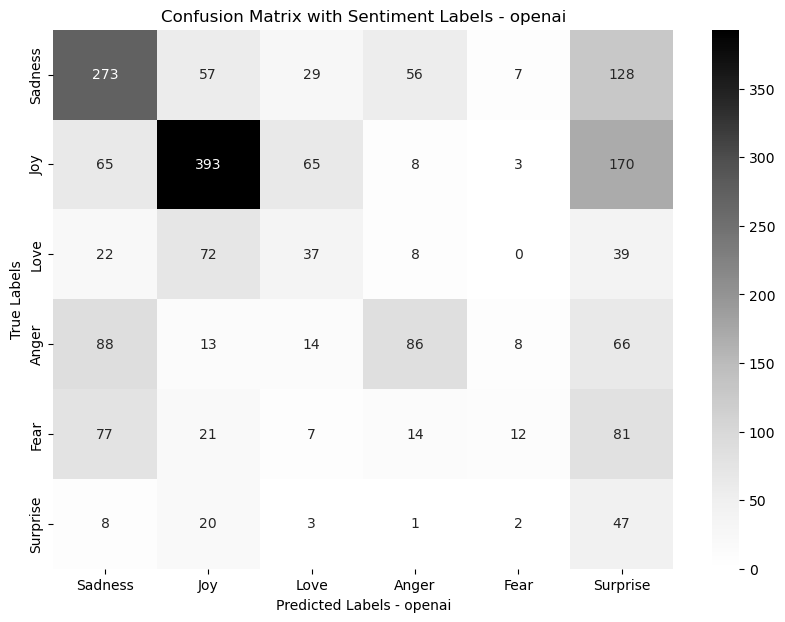

In [76]:
col = 'openai'

confusion_matrix_display(df_val, col)

In [78]:
col = 'openai'

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
misclassifications_display(df_val, [1,0], col, 5)
misclassifications_display(df_val, [3], col, 0)
misclassifications_display(df_val, [4], col, 0)

Misclassified 0 (sadness) as 5 (surprise) Examples:
['i walked out of there an hour and fifteen minutes later feeling like i had been beaten with a stick and then placed on the rack and stretched', 'i didn t feel abused and quite honestly it made my day a little better', 'i feel absolutely foolish for allowing myself to actually believe that this might be it for us the month weve been praying so hard for', 'i waited for an eternity for it to download and now im remembering a day when i had to wait to go to walmart to buy a whole cd just to hear one song and feeling kinda dumb with my impatience', 'i would feel i missed out on a wealth of treasures if i did not read']

Misclassified 1 (joy) as 5 (surprise) Examples:
['i never stop feeling thankful as to compare with others i considered myself lucky because i did not encounter ruthless pirates and i did not have to witness the slaughter of others', 'i feel that it is something that will never really be resolved', 'i have a feeling hes go

#### Test Metrics

63/63 [==============================] - 141s 2s/step


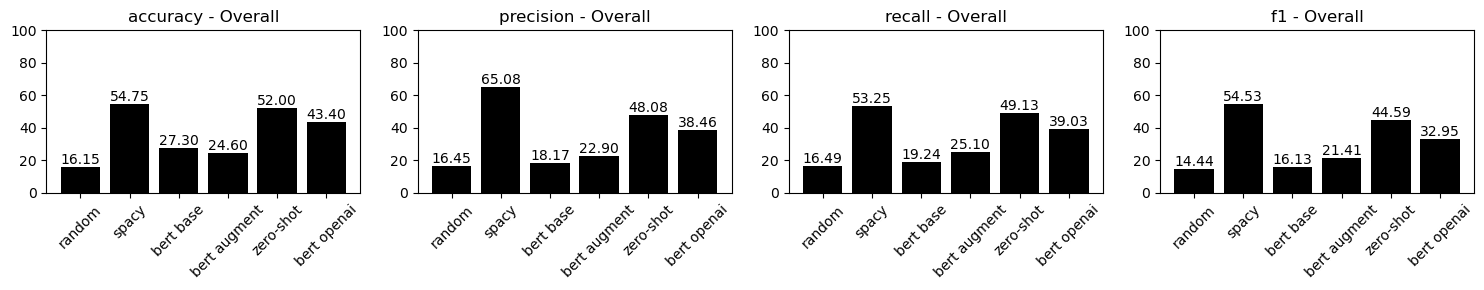

In [65]:
# Test
test_preds = tokenize_and_predict(bert_model_32openai, tokenizer, df_test, max_length)
metrics_test.run(df_test['label'], test_preds, "bert openai")
metrics_test_ai.run(df_test['label'], test_preds, "bert openai")
metrics_test.plot()

### 2.e Optimal Technique Application
*Based on the previous experiments, apply the most effective technique(s) to further improve your model's performance. Comment your results.*

Our objective was to enhance our training set through data augmentation, zero-shot learning, or AI-generated data to develop a more robust model for sentiment prediction. In our experiments, zero-shot learning proved to be the most effective for accurately classifying Twitter messages followed by AI-generated data. We decided to pursue the route of generating better quality data with open-ai as we felt we could make the most improvements there. 

It's worth noting that zero-shot learning benefits from initial training on vast datasets, providing a broad understanding of language, even if not specifically tailored to our task of emotion classification. Our initial efforts to generate data with open-ai were limited at a few hundred data samples due to computational limitations and API request quotas from OpenAI. In this question, we explored whether augmenting our dataset with AI-generated data from various prompts could enhance performance by increasing the dataset's size (we generated approximately 500 data points per prompt). We evaluated the effectiveness of each prompt separately, altogether, then alongside our best-performing prompt merged with data generated in a question 2d.

To address misclassifications, we generated additional data using diverse prompts aimed at minimizing errors. Our initial GPT prompt produced responses too similar to the input examples, failing to introduce the novel expressions needed to significantly improve model robustness. For instance, inputting "i feel highly disadvantaged" resulted in variations like "feeling deeply saddened and disadvantaged," which, while better than simple data augmentation, still fell short of significantly boosting model performance.

We introduced more elaborate prompts to encourage a wider range of responses:
- "Reflect on a moment from your life that made you feel ({label}). Use the examples provided as a guide for writing style to compose some Twitter messages."
- "Describe the physical sensations and actions of someone experiencing ({label}) as they go about a daily task. Use the examples provided as a guide for writing style to compose some Twitter messages."
- "Imagine a person's emotional response to a significant world event, feeling ({label}), and describe their internal monologue. Use the examples provided as a guide for writing style to compose some Twitter messages."

These prompts were designed to reflect the motivations behind the Twitter messages in our dataset more accurately. For example, using "i feel highly disadvantaged" with these new prompts yielded narratives like "feeling like life keeps knocking me down," indicating a shift towards more story-like and varied messages.

We determined that combining our best prompt ‘Describe the physical sensations and actions of someone experiencing ({label}) as they go about a daily task. Use the examples provided as a guide for writing style to write some twitter messages.” with data generated in question 2d approach yielded results nearly matching the performance of zero-shot learning, marking a significant improvement in our model's ability to predict sentiment.

#### Generate more gpt data

In [79]:
open_ai_df_prompt_adj = pd.read_csv(path_models_+'open_ai_df_clean_prompt_adj.csv')

all_open_ai = pd.concat([open_ai_df, open_ai_df_prompt_adj], ignore_index = False)
all_open_ai.loc[all_open_ai['prompt'].isna(), 'prompt'] = 'original'

#### Build Model

In [80]:
#build model based on all prompts individually

prompt_types = ['reflect','describe','imagine']
print("Building a model for each new prompt:",prompt_types)

for prompt in prompt_types:
    tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
    max_length = 64
    num_labels = 6
    rate = 0.5
    train_batch_size = 32
    learning_rate = 0.0001
    num_epochs = 2

    df_prompt = open_ai_df_prompt_adj[open_ai_df_prompt_adj['prompt']==prompt].copy()
    df_prompt = df_prompt[['text','label']]
    print("Number of data points for",prompt,"is",len(df_prompt['text']))

    # X_train, y_train = prepare_data(df_prompt, tokenizer)
    # steps_per_epoch = int(len(X_train) / train_batch_size)
    # batches = get_batches(X_train, y_train, tokenizer, train_batch_size, max_length)
    # optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # bert_model = build_bert_model(tokenizer, model, max_length, num_labels, rate)
    # train_bert_model(bert_model, batches, optimizer, num_epochs, steps_per_epoch)

    # # Saving weights
    # save_model_weights(bert_model, path_models_ + "bert_model_weights_openai_"+prompt+".h5")

Building a model for each new prompt: ['reflect', 'describe', 'imagine']


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Number of data points for reflect is 327


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Number of data points for describe is 308


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Number of data points for imagine is 302


In [81]:
# Loading weights

prompt_types = ['reflect','describe','imagine']

for prompt in prompt_types:
    tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
    max_length = 64
    num_labels = 6
    rate = 0.5
    train_batch_size = 32
    learning_rate = 0.0001
    num_epochs = 2
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    #with more generated data from a mix of prompts
    bert_model_weights_openai_prompt_adj = load_model_weights(tokenizer, model, max_length, num_labels, rate, path_models_+"bert_model_weights_openai_"+prompt+".h5")

    df_val['label_'+prompt] = tokenize_and_predict(bert_model_weights_openai_prompt_adj, tokenizer, df_val, max_length)
    metrics_val_ai.run(df_val['label'], df_val['label_'+prompt], "bert AI-"+prompt)
    test_preds = tokenize_and_predict(bert_model_weights_openai_prompt_adj, tokenizer, df_test, max_length)
    metrics_test_ai.run(df_test['label'], test_preds, "bert AI-"+prompt)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 149s 2s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 149s 2s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 149s 2s/step


/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Validation Metrics

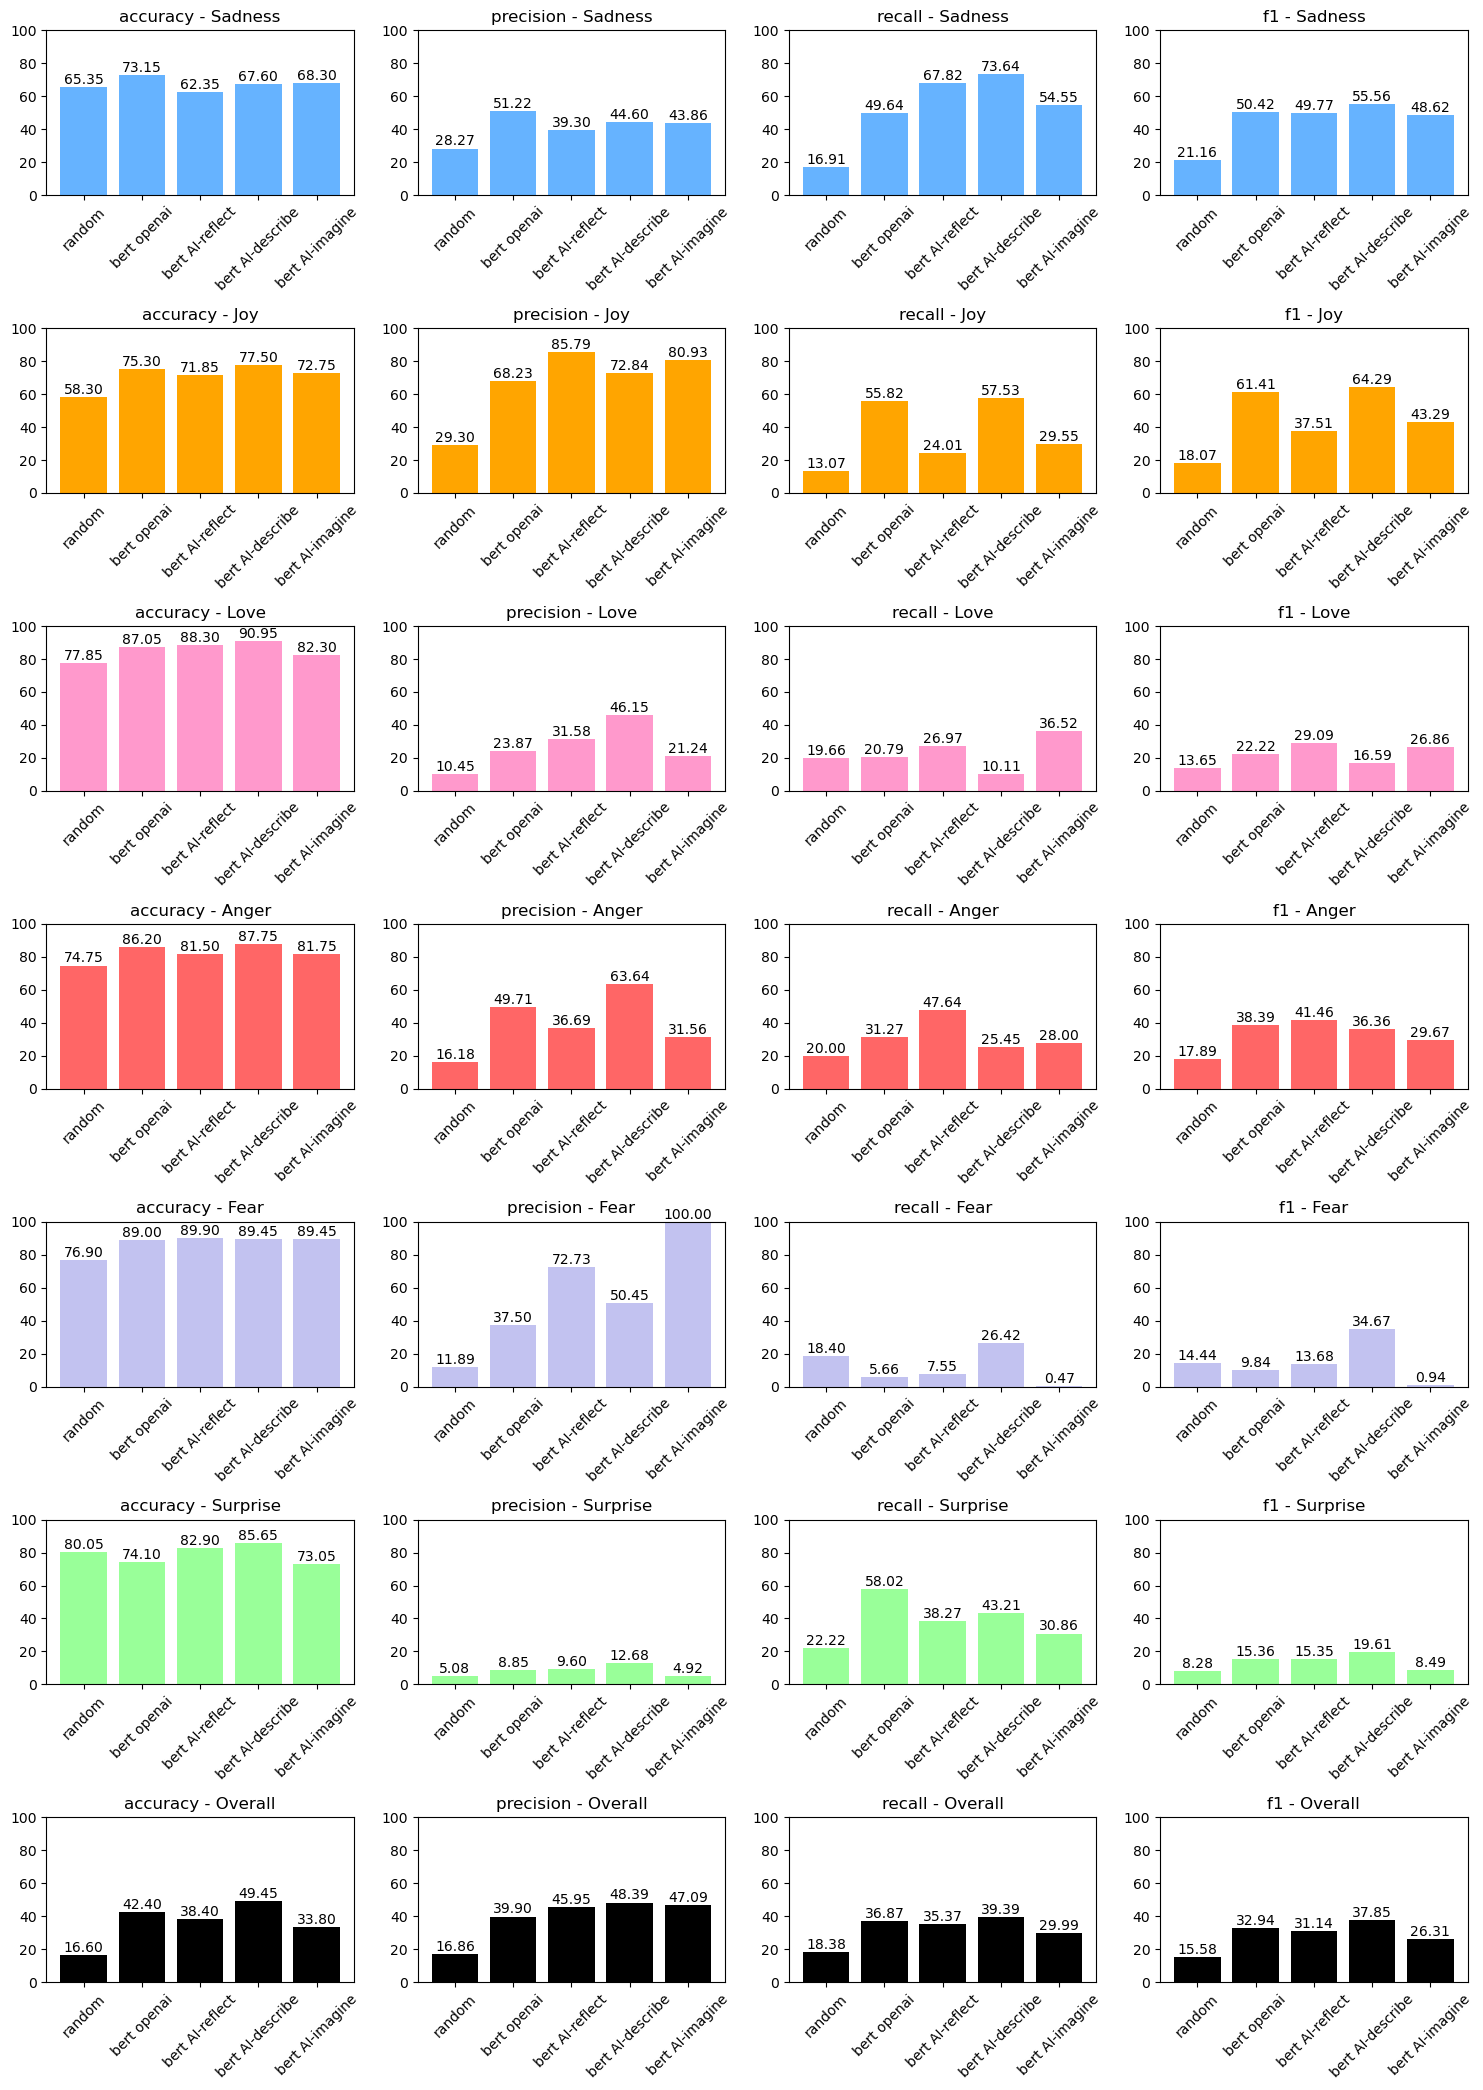

In [82]:
# Validation
metrics_val_ai.plot_val()

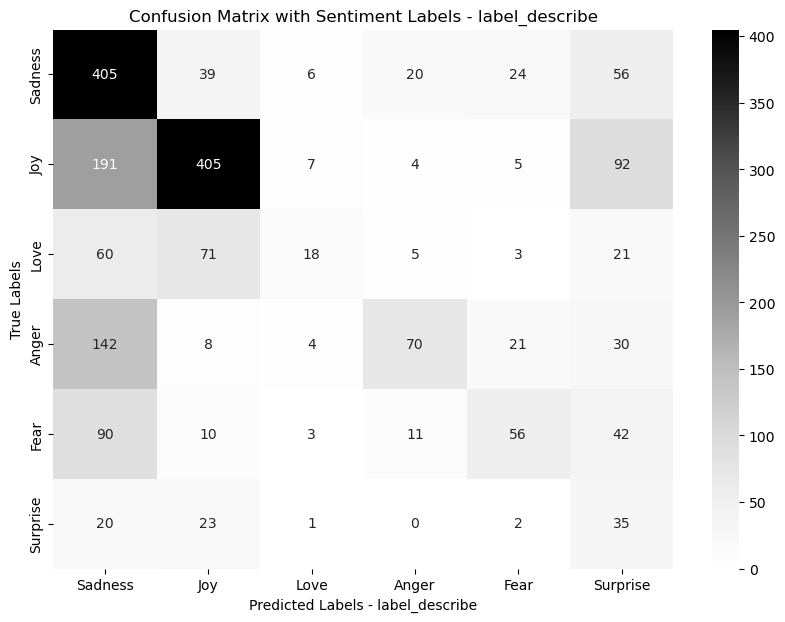

In [83]:
col = 'label_describe'

confusion_matrix_display(df_val, col)

In [86]:
#Investigate instances where Joy and Anger are classified as Saddness

col = 'label_describe'

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
misclassifications_display(df_val, [1,3,4], col, 0)
misclassifications_display(df_val, [1], col, 5)

Misclassified 1 (joy) as 0 (sadness) Examples:
['i feel less keen about the army every day', 'i never stop feeling thankful as to compare with others i considered myself lucky because i did not encounter ruthless pirates and i did not have to witness the slaughter of others', 'i had lunch with an old friend and it was nice but in general im not feeling energetic', 'i feel that it is something that will never really be resolved', 'i feel as if i am the beloved preparing herself for the wedding']

Misclassified 3 (anger) as 0 (sadness) Examples:
['i know what it feels like he stressed glaring down at her as she squeezed more soap onto her sponge', 'i feel like taking a whack at someone s eye and spitting on it a cranky old lady i try to cheer myself up', 'i know it so difficult especially when you feel you have been wronged', 'i can really decode but im sorry i have to vomit my feelings out because i am so cranky and everything is getting on my nerves', 'i have a feeling there will be ma

#### Test Metrics

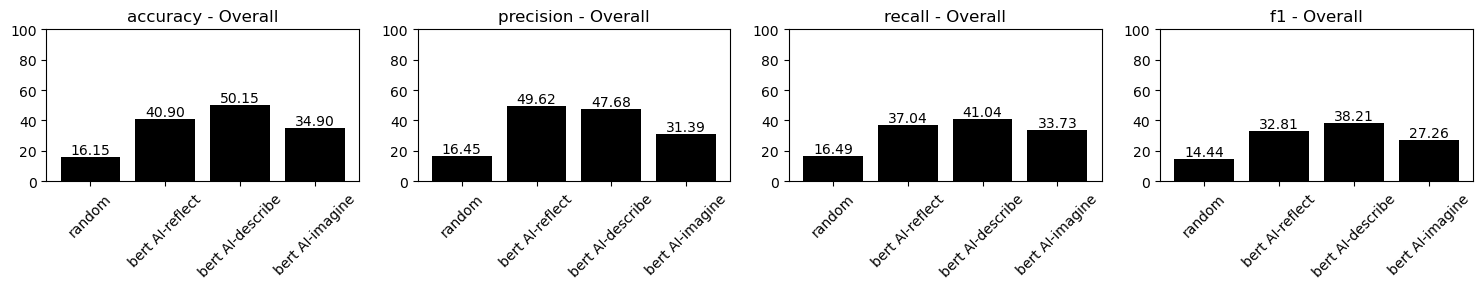

In [87]:
# Test
metrics_test_ai.plot()

#### Utilize more data generated for model creation

In [88]:
#create model based on multiple batches of data generated prompts
#and all the data

prompts_to_include = ['original', 'describe']
subset_open_ai = all_open_ai[all_open_ai['prompt'].isin(prompts_to_include)].copy()
subset_open_ai.reset_index(drop=True, inplace=True)

all_open_ai = all_open_ai[['text','label']].drop_duplicates()
subset_open_ai = subset_open_ai[['text','label']].drop_duplicates()

# tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
# max_length = 64
# num_labels = 6
# rate = 0.5
# train_batch_size = 32
# learning_rate = 0.0001
# num_epochs = 2

# X_train, y_train = prepare_data(all_open_ai, tokenizer)
# steps_per_epoch = int(len(X_train) / train_batch_size)
# batches = get_batches(X_train, y_train, tokenizer, train_batch_size, max_length)
# optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# bert_model = build_bert_model(tokenizer, model, max_length, num_labels, rate)
# train_bert_model(bert_model, batches, optimizer, num_epochs, steps_per_epoch)

# # Saving weights
# save_model_weights(bert_model, path_models_ + "bert_model_weights_openai_prompt_all.h5")

# X_train, y_train = prepare_data(subset_open_ai, tokenizer)
# steps_per_epoch = int(len(X_train) / train_batch_size)
# batches = get_batches(X_train, y_train, tokenizer, train_batch_size, max_length)
# optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# bert_model = build_bert_model(tokenizer, model, max_length, num_labels, rate)
# train_bert_model(bert_model, batches, optimizer, num_epochs, steps_per_epoch)

# # Saving weights
# save_model_weights(bert_model, path_models_ + "bert_model_weights_openai_prompt_subset.h5")

In [89]:
#evaluate model

for prompt in ['all','subset']:
    tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
    max_length = 64
    num_labels = 6
    rate = 0.5
    train_batch_size = 32
    learning_rate = 0.0001
    num_epochs = 2
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    #with more generated data from a mix of prompts
    bert_model_weights_openai_prompt_adj = load_model_weights(tokenizer, model, max_length, num_labels, rate, path_models_+"bert_model_weights_openai_prompt_"+prompt+".h5")

    df_val['label_'+prompt] = tokenize_and_predict(bert_model_weights_openai_prompt_adj, tokenizer, df_val, max_length)
    metrics_val_ai.run(df_val['label'], df_val['label_'+prompt], "bert AI-"+prompt)
    test_preds = tokenize_and_predict(bert_model_weights_openai_prompt_adj, tokenizer, df_test, max_length)
    metrics_test_ai.run(df_test['label'], test_preds, "bert AI-"+prompt)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 150s 2s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 151s 2s/step


#### Validation Metrics

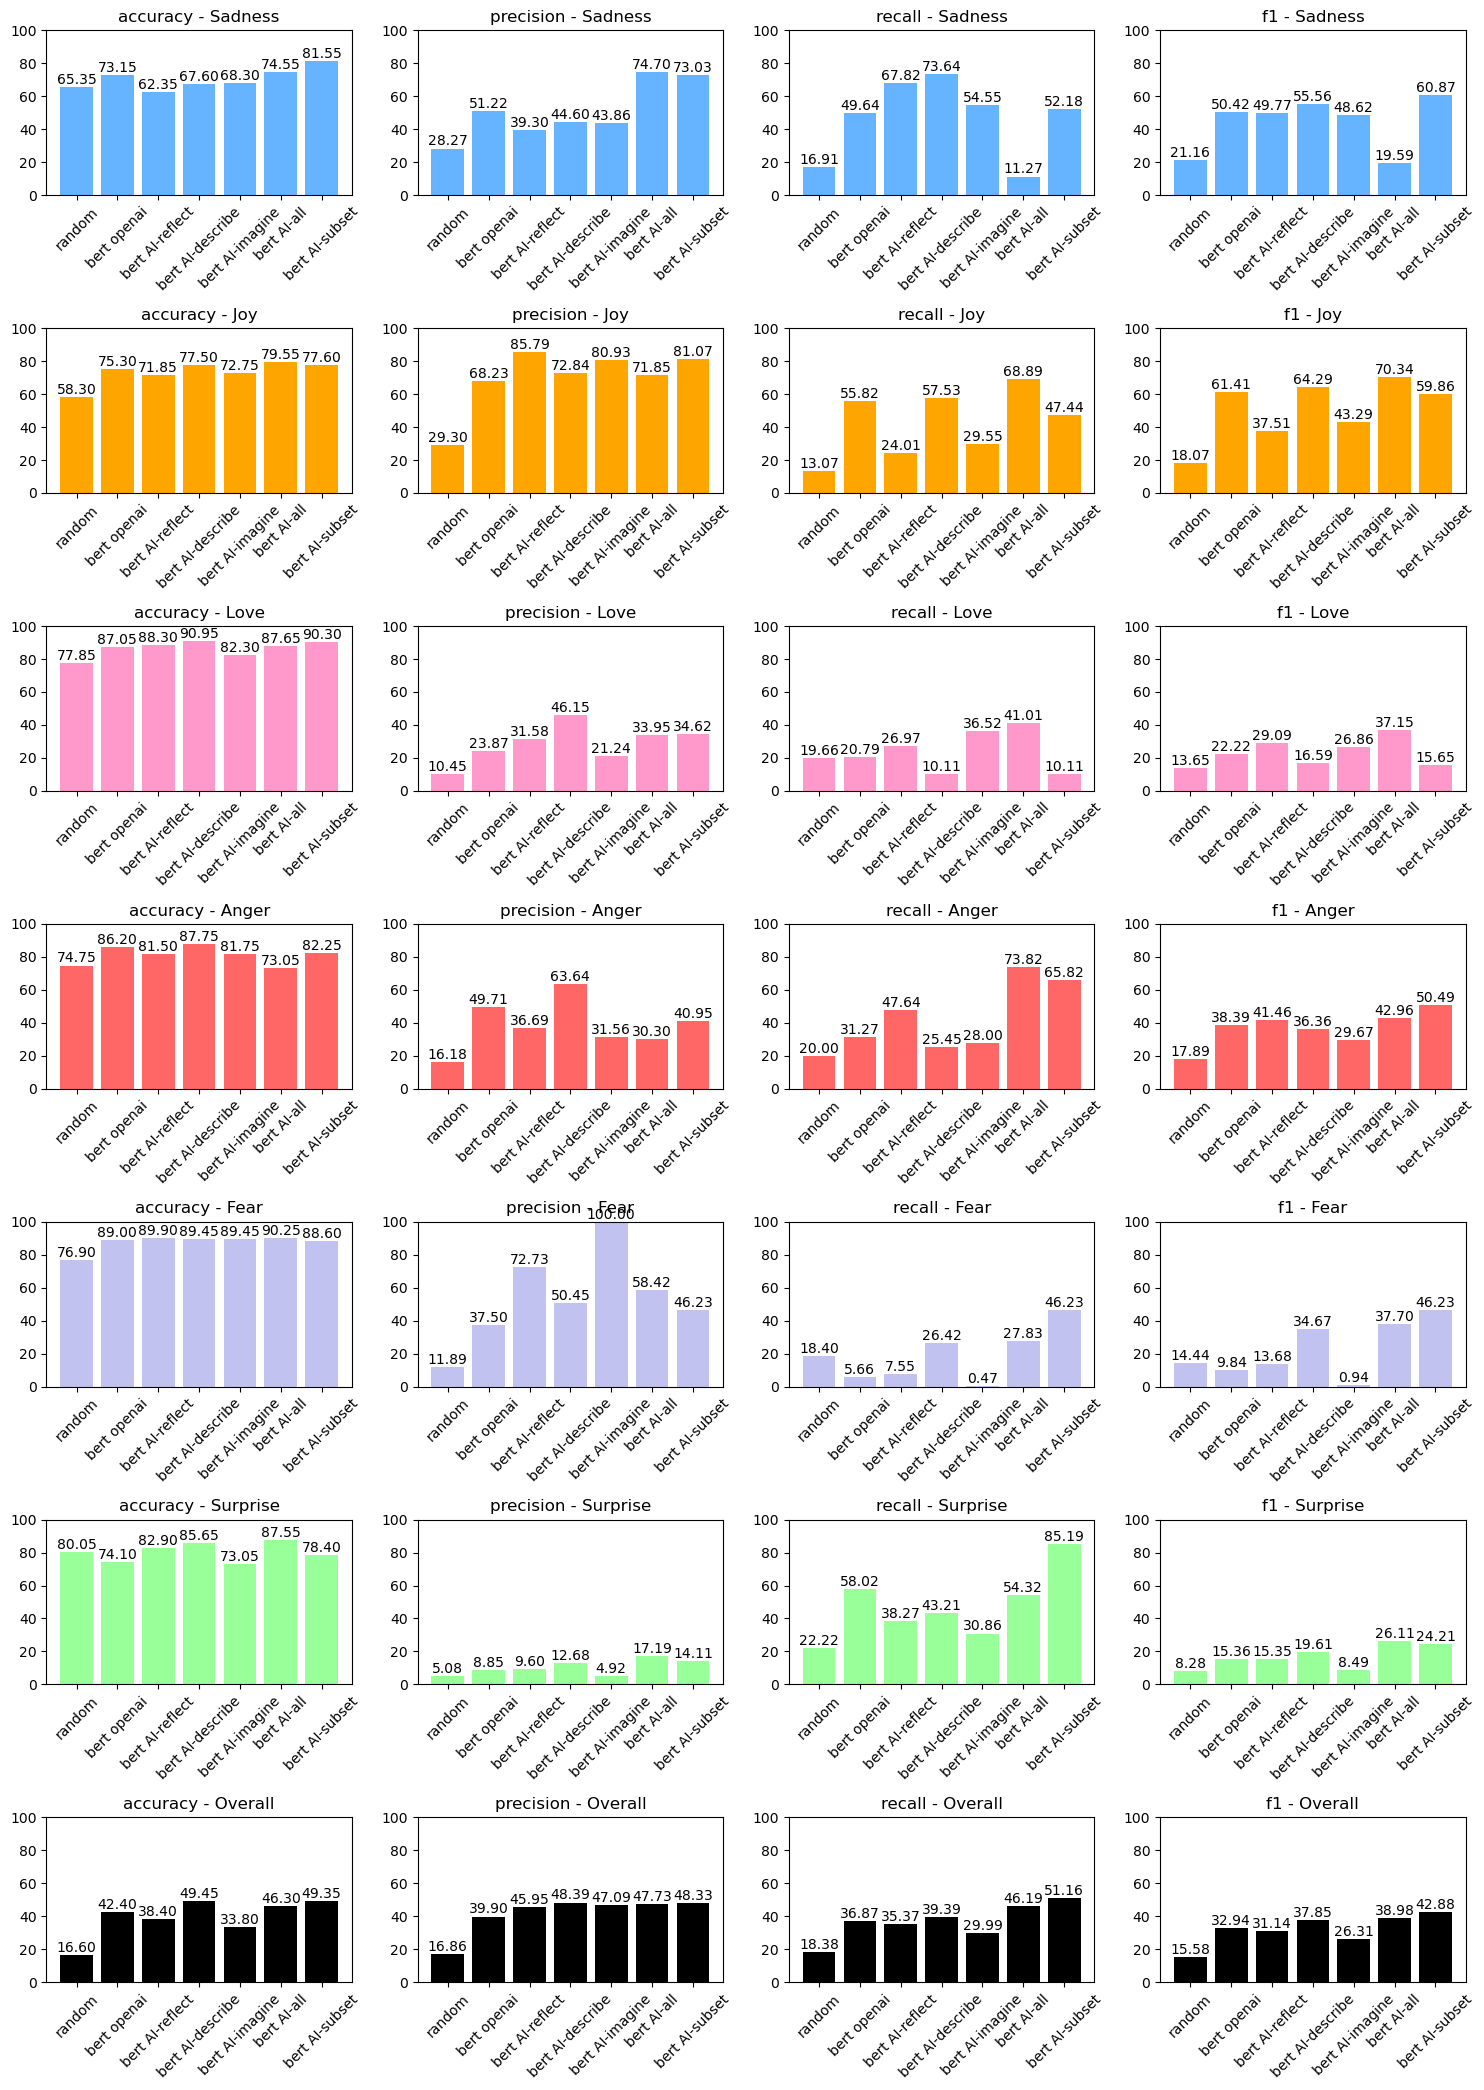

In [90]:
# Validation
metrics_val_ai.plot_val()

#### Confusion Matrix

We anticipated that our best model would alleviate misclassifications, but an unexpected outcome of merging the two approaches and training a model on the resulting subset was a significant rise in misclassifications, particularly labeling instances of "Joy" as "Surprise." Despite this drawback, given that it represented our best-performing model to date, we decided to retain it for further model enhancements.

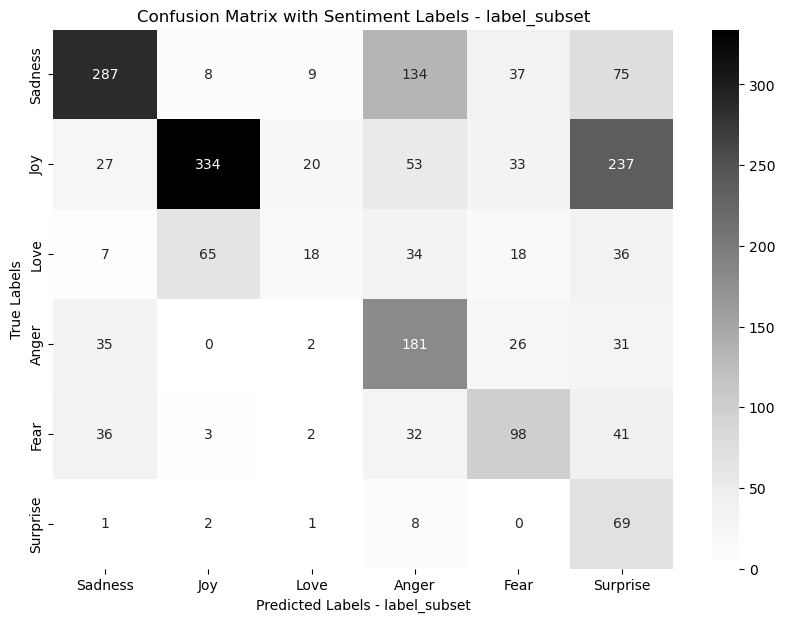

In [91]:
col = 'label_subset'

confusion_matrix_display(df_val, col)

In [93]:
col = 'label_subset'

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
misclassifications_display(df_val, [0,1], col, 5)
misclassifications_display(df_val, [0], col, 3)

Misclassified 0 (sadness) as 5 (surprise) Examples:
['i feel like i am still looking at a blank canvas blank pieces of paper', 'i feel absolutely foolish for allowing myself to actually believe that this might be it for us the month weve been praying so hard for', 'i waited for an eternity for it to download and now im remembering a day when i had to wait to go to walmart to buy a whole cd just to hear one song and feeling kinda dumb with my impatience', 'i don t know if anybody will ever be able to feel how i feel or at least relate when everything is lost you find yourself missing and longing for it them', 'i would feel i missed out on a wealth of treasures if i did not read']

Misclassified 1 (joy) as 5 (surprise) Examples:
['i feel incredibly lucky just to be able to talk to her', 'i never stop feeling thankful as to compare with others i considered myself lucky because i did not encounter ruthless pirates and i did not have to witness the slaughter of others', 'i have found in the

#### Test Metrics

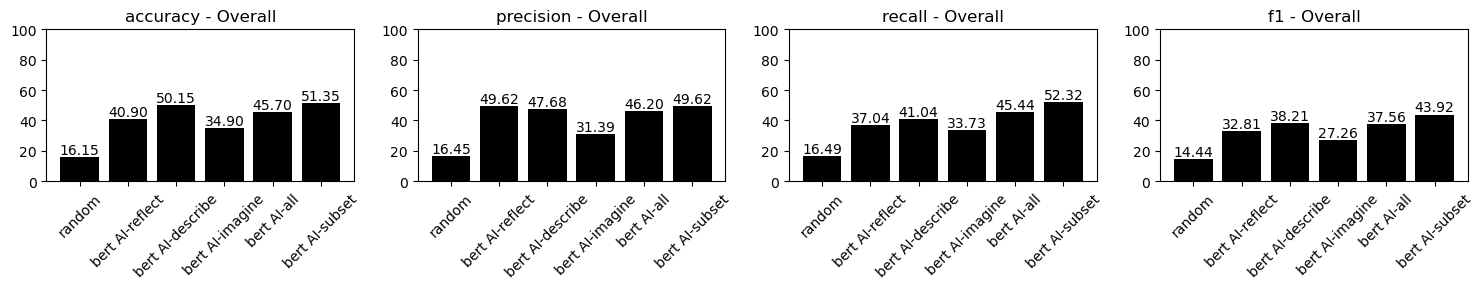

In [94]:
# Test
metrics_test_ai.plot()

## <a id='part3'>Part 3: State of the Art Comparison</a>
- **Objective**: Benchmark your model against the SOA with the full dataset now available.
- **Tasks:**
  - a. Full Dataset Training (0.25 points): Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.
  - b. Learning Curve (0.25 points): Plot a learning curve based on the training data percentages.
  - c. Technique Comparison (0.5 points): Incorporate the techniques tested in Part 2 into your training schema for comparison.
  - d. Methodology Analysis (1 point): Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.


### 3.a Full Dataset Training
*Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.*

When analyzing the result of the metrics test, it is evident that the new model exhibits a much higher performance than that found in Part 1. Accuracy, precision, recall, and F1 score all showed improvement. Specifically, the F1 score increased from 43.92 to 91.40 on the validation set, highlighting the effectiveness of the enhancement. When delving deeper into the confusion matrix we saw that there still seems to be misclassifications for labels such as "Joy" and "Love" but other labels such as "Sadness", "Joy", "Anger" and "Fear" seem to be having really positive results when training the model with the full data. Correct classification for all labels have in cases doubled execpt for "Surprise" which has lowered by 4. 

#### Build Models

#### Validation Metrics

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 211s 3s/step


/Users/nataliabeltran/anaconda3/envs/env_adv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliabeltran/anaconda3/envs/env_adv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliabeltran/anaconda3/envs/env_adv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

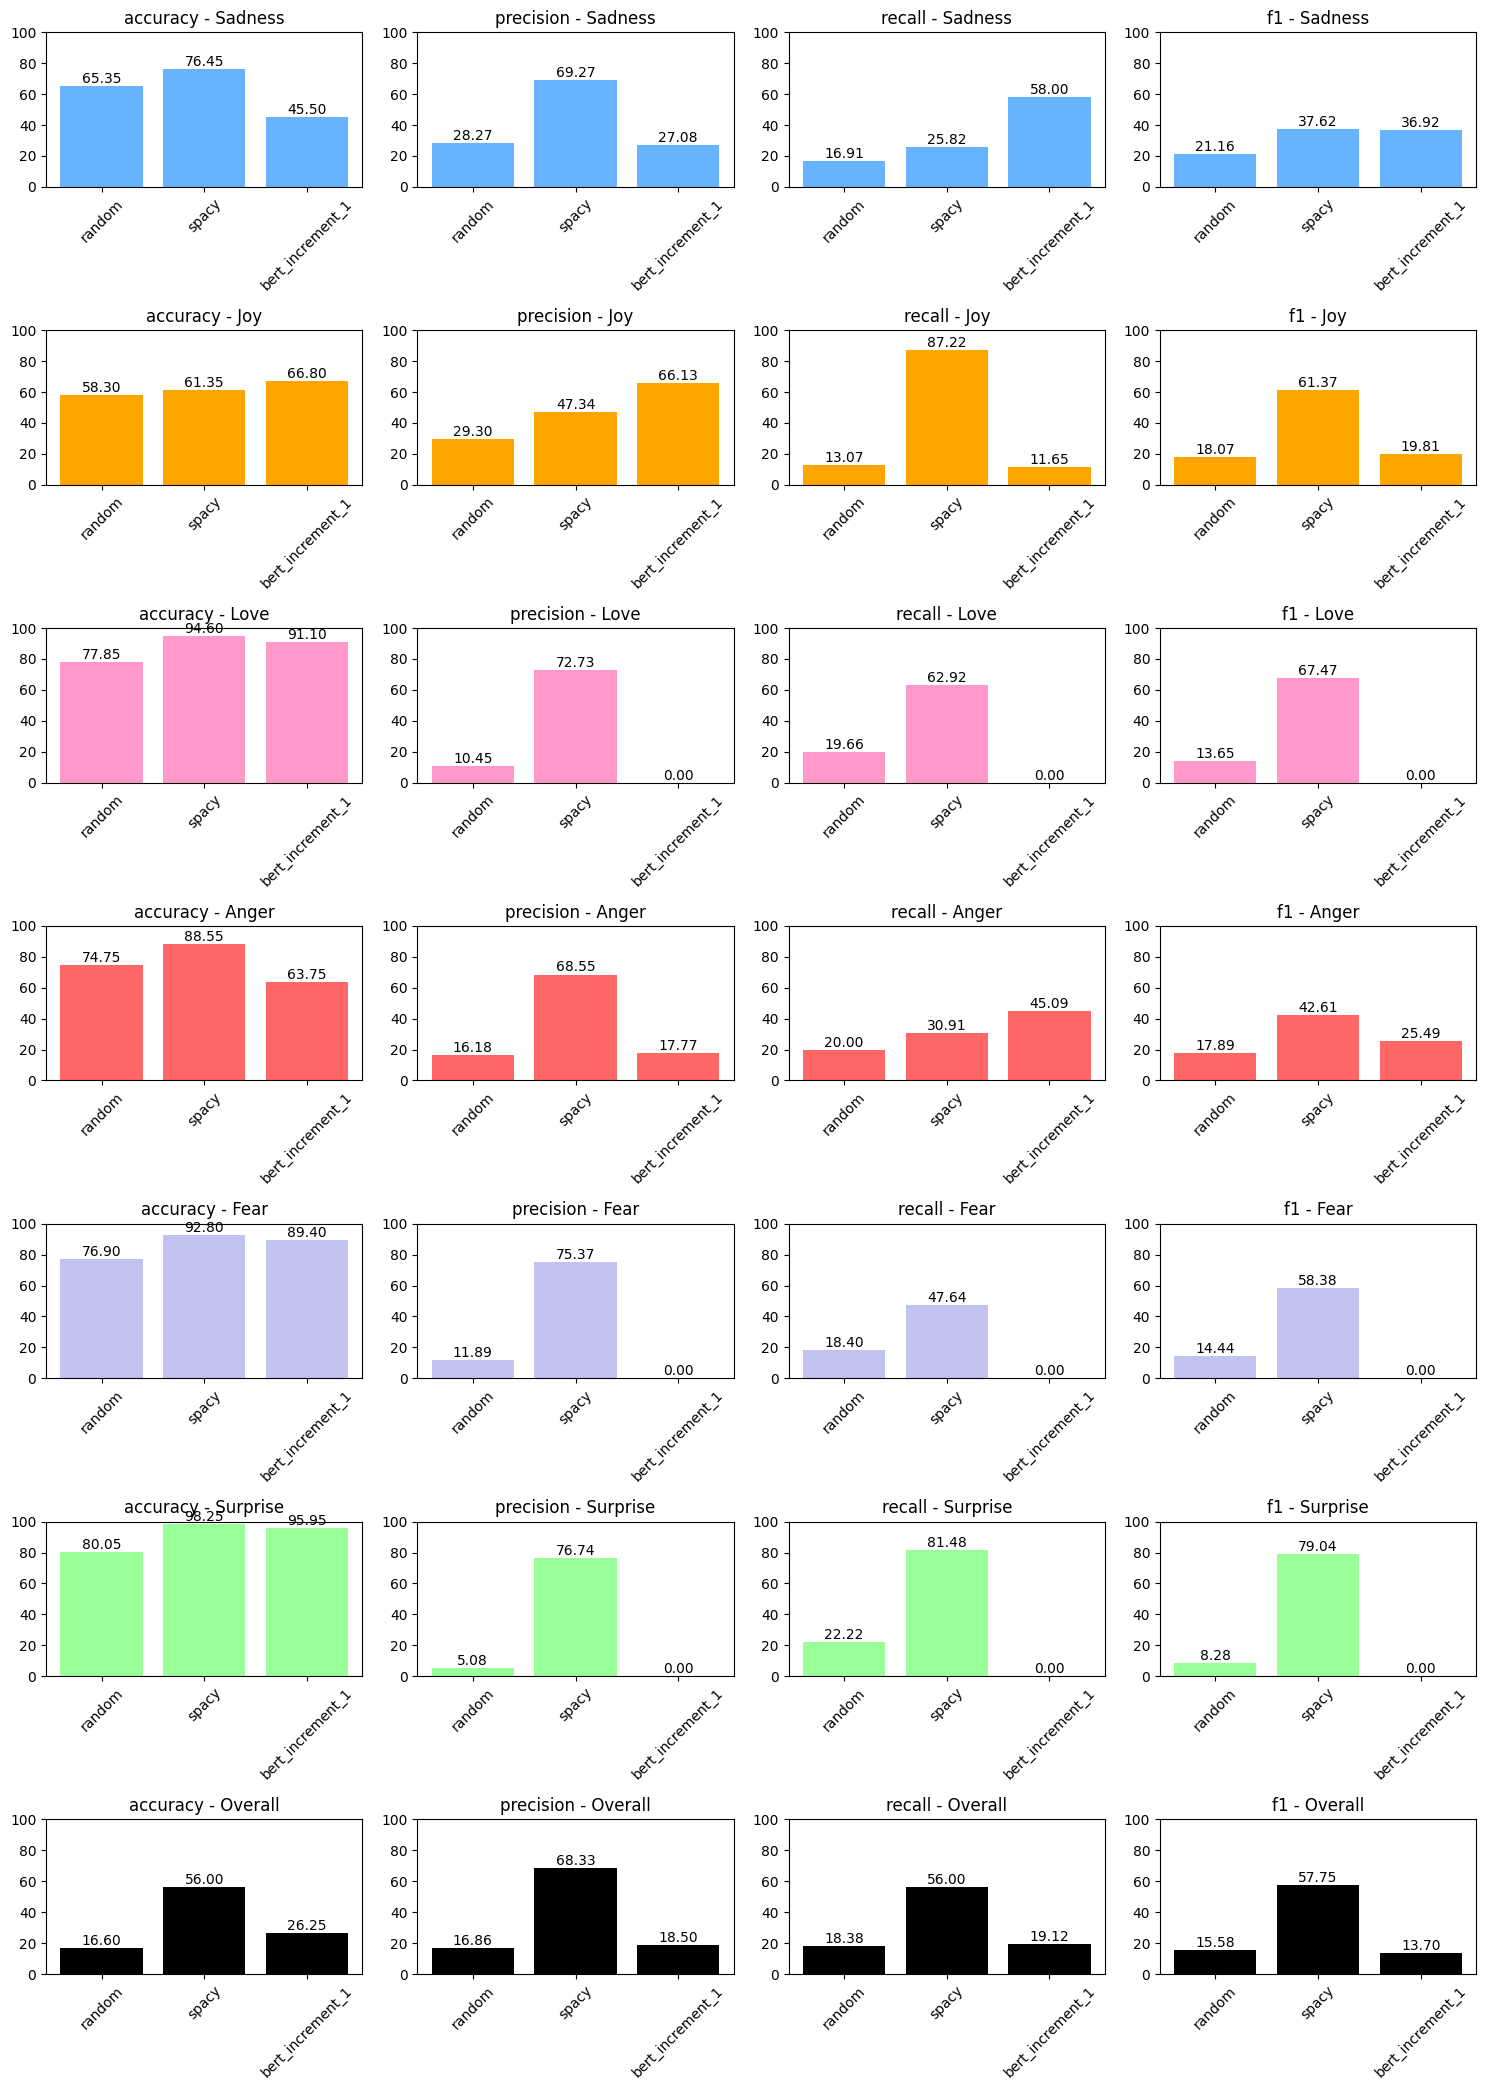

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 206s 3s/step


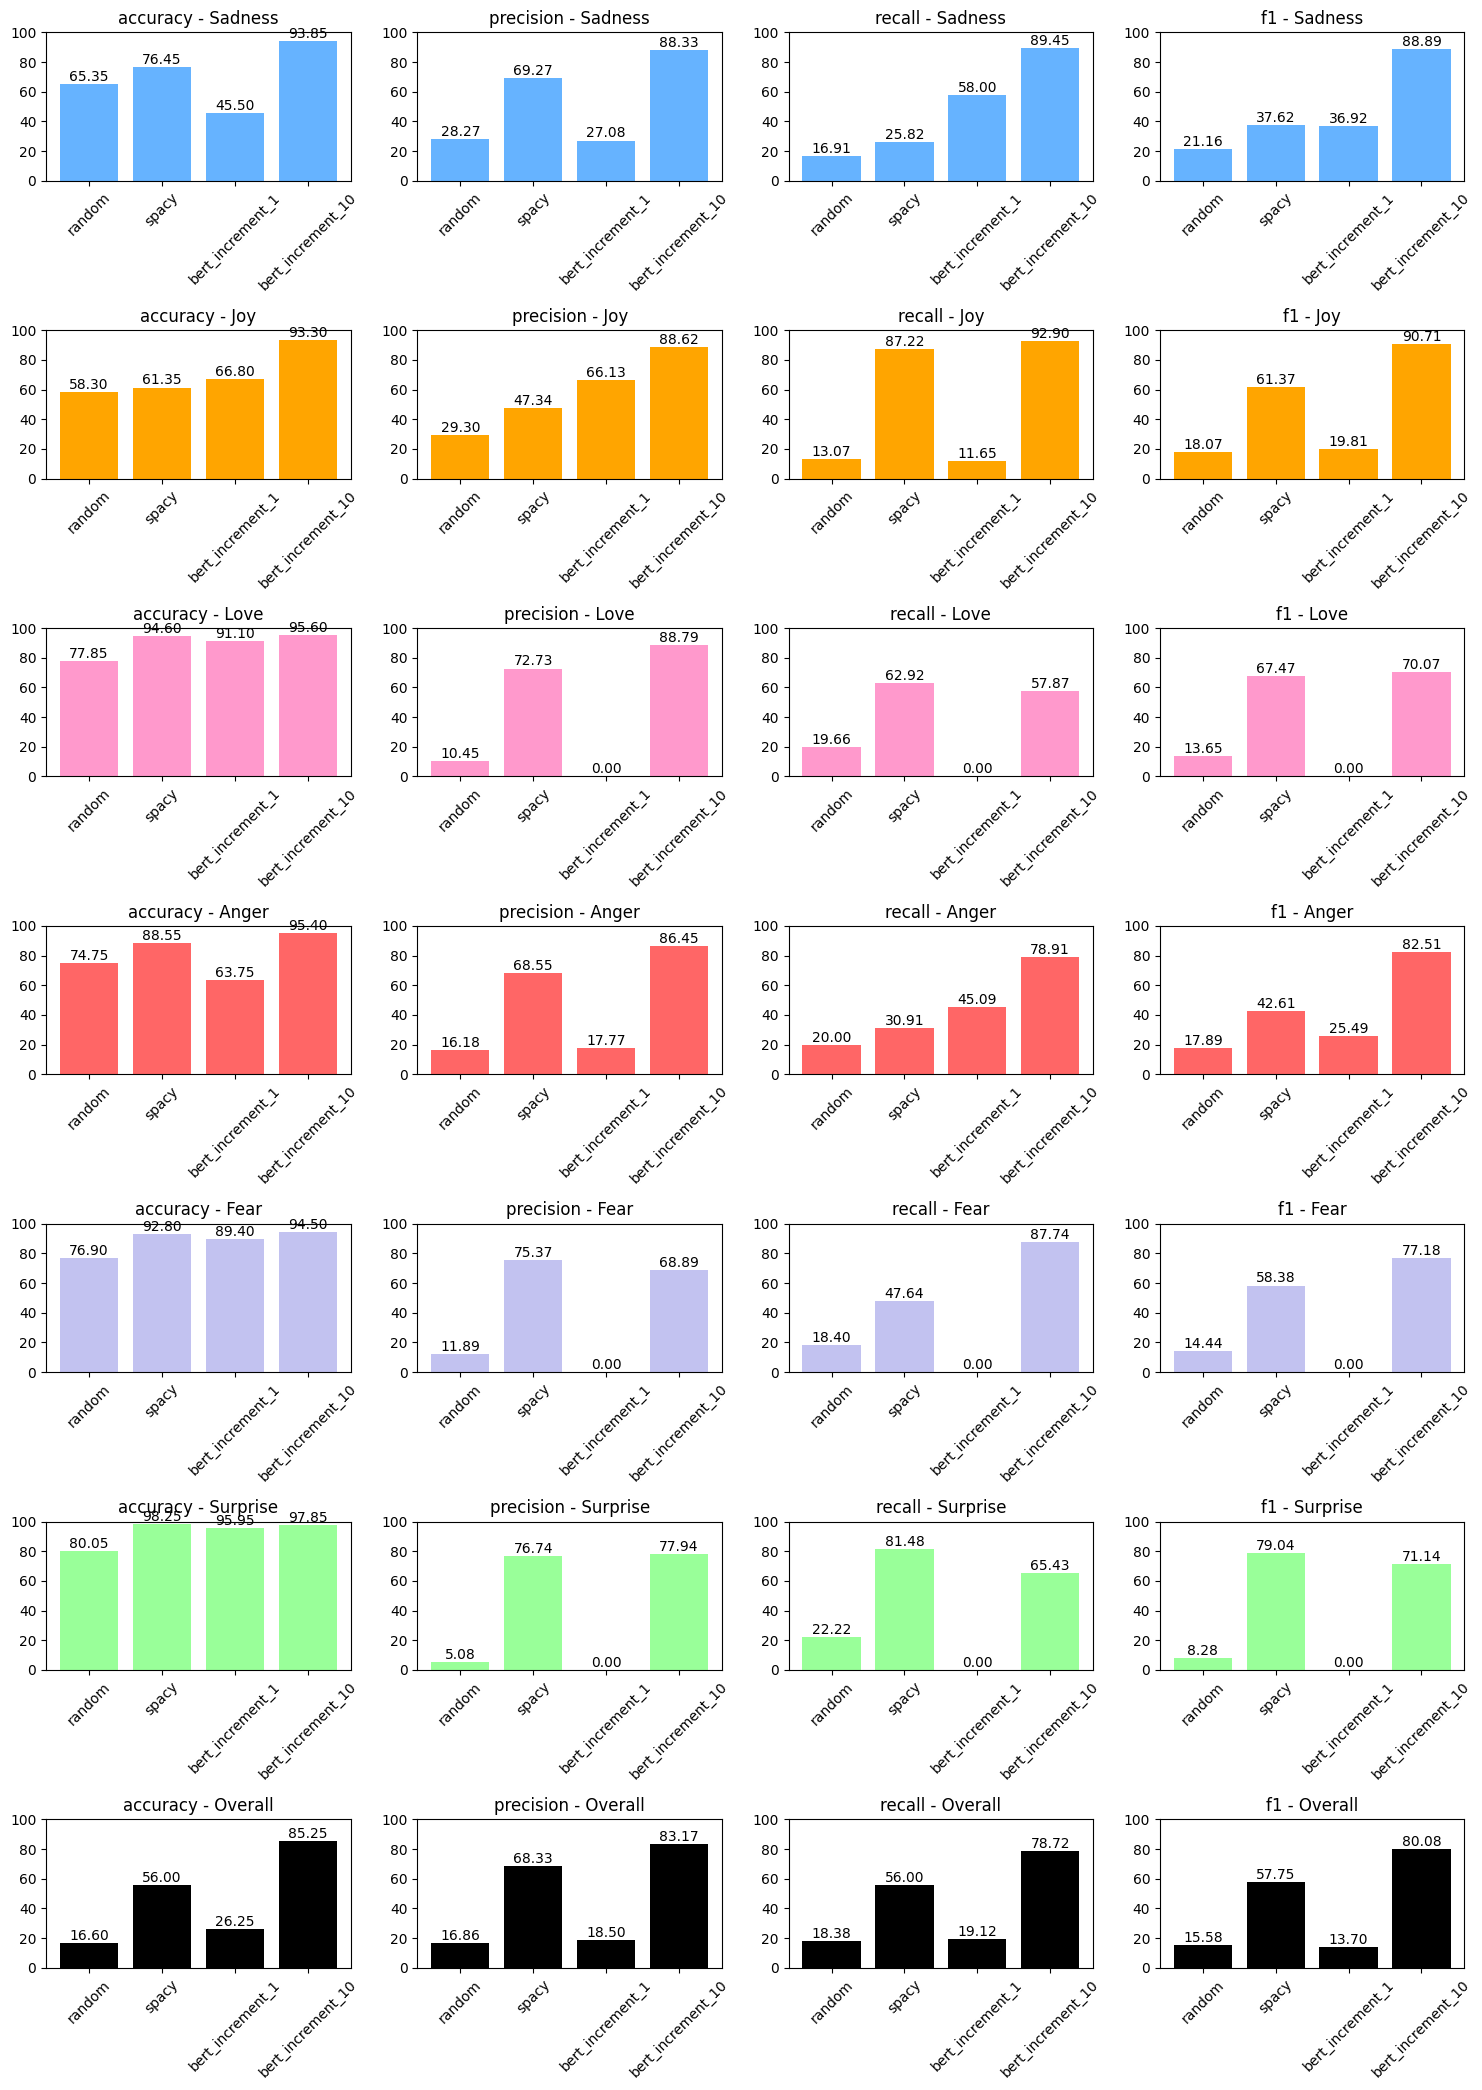

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 218s 3s/step


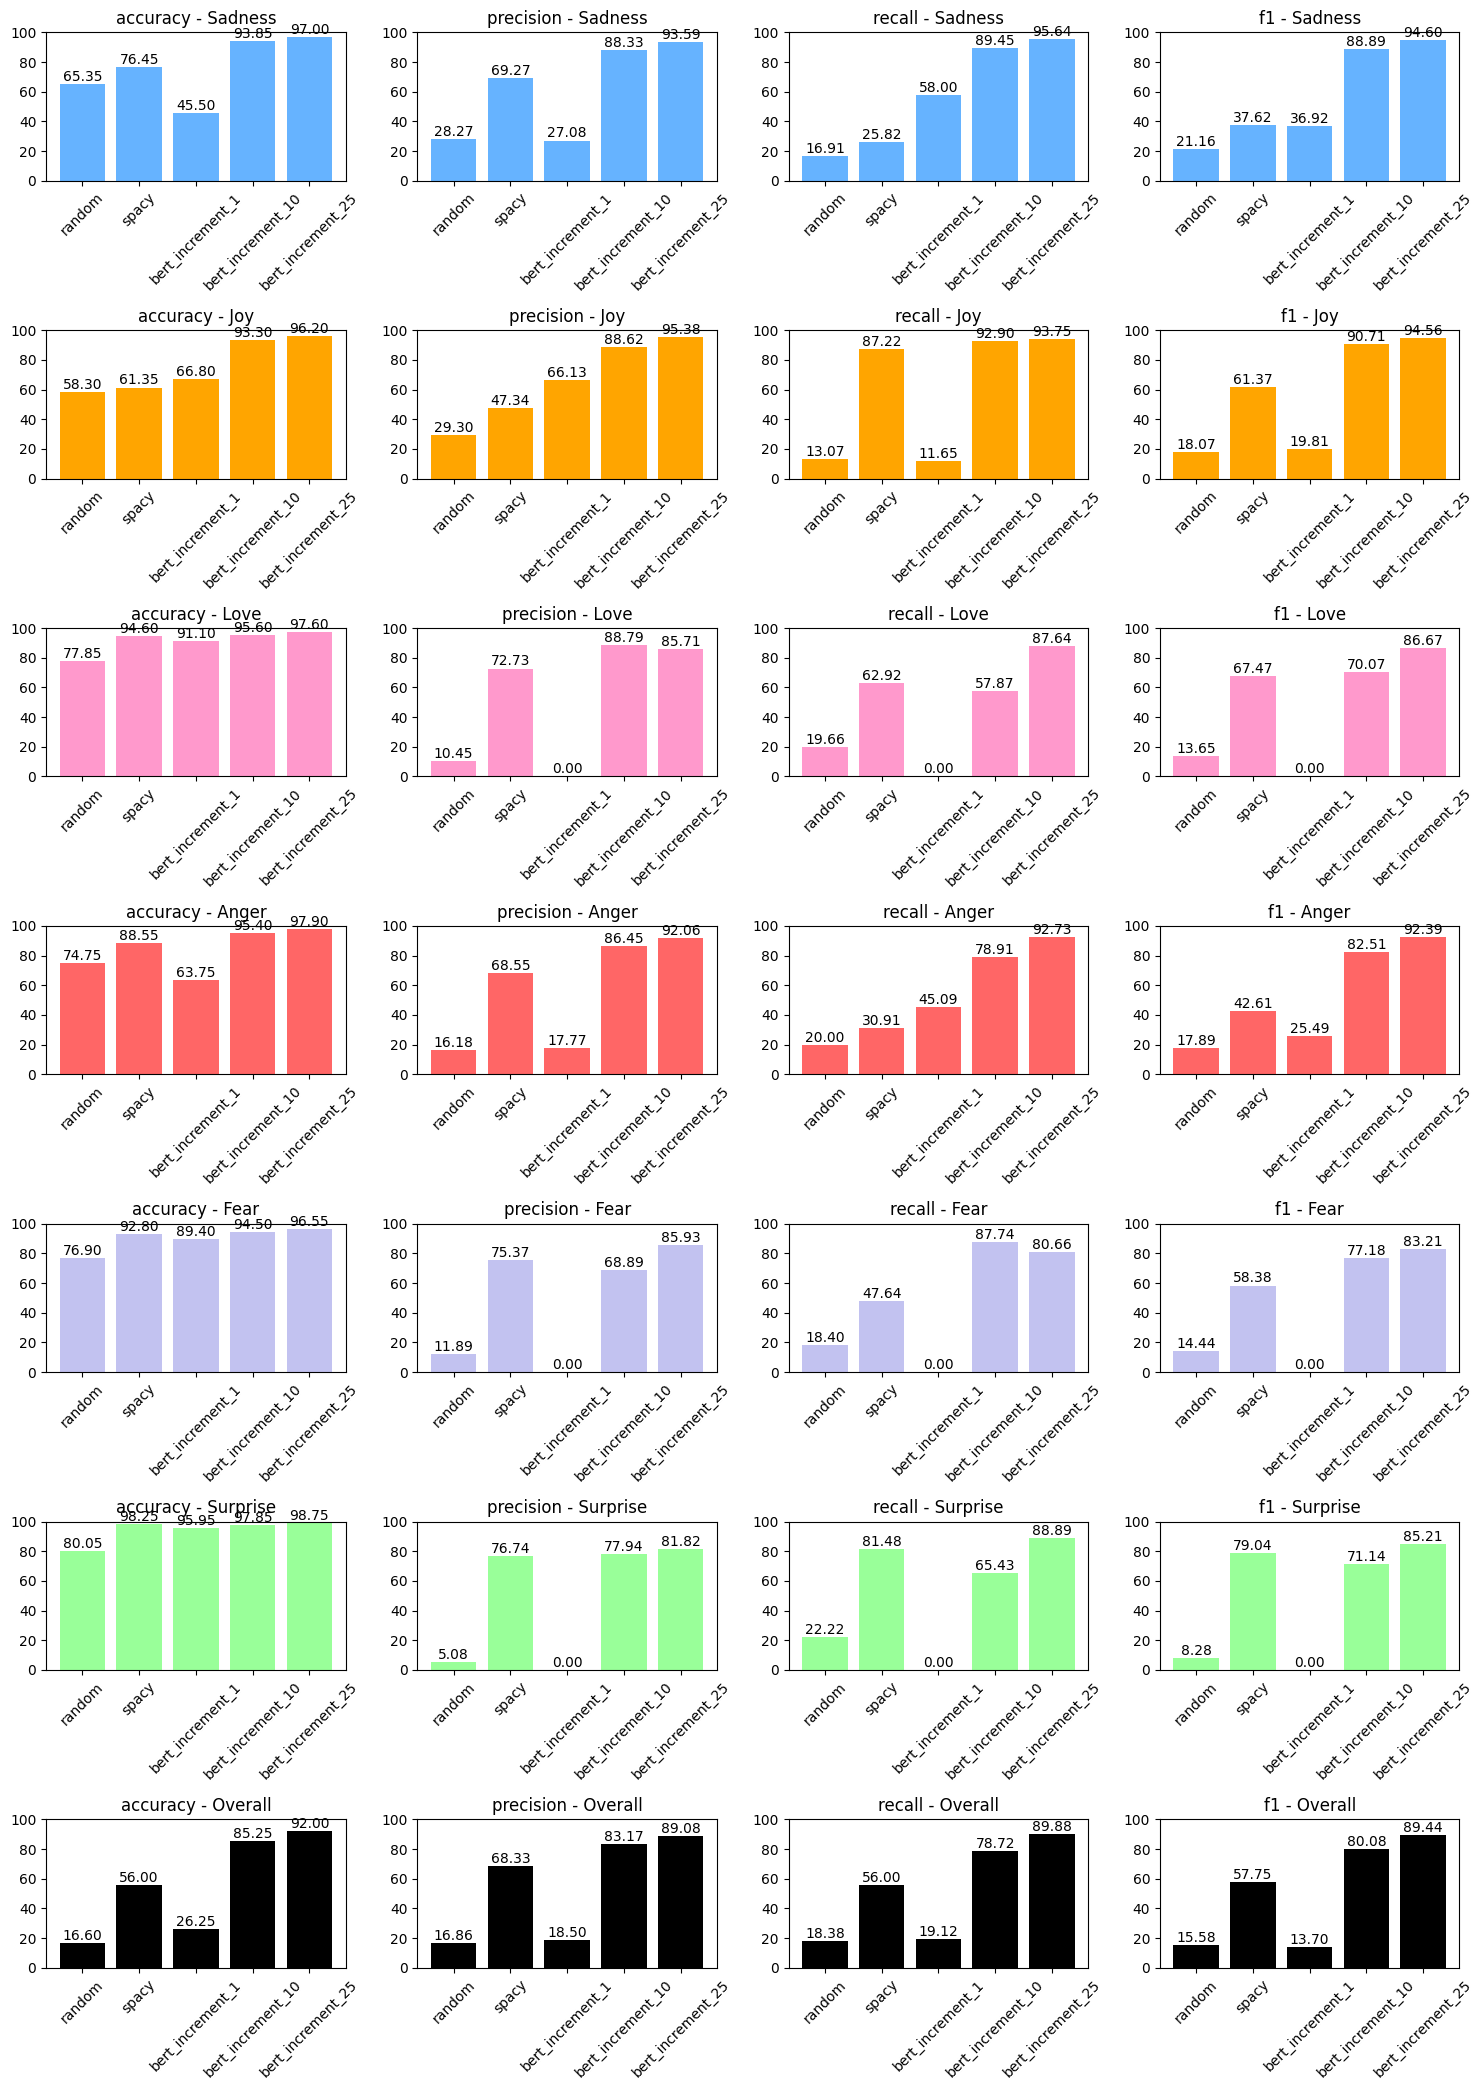

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 205s 3s/step


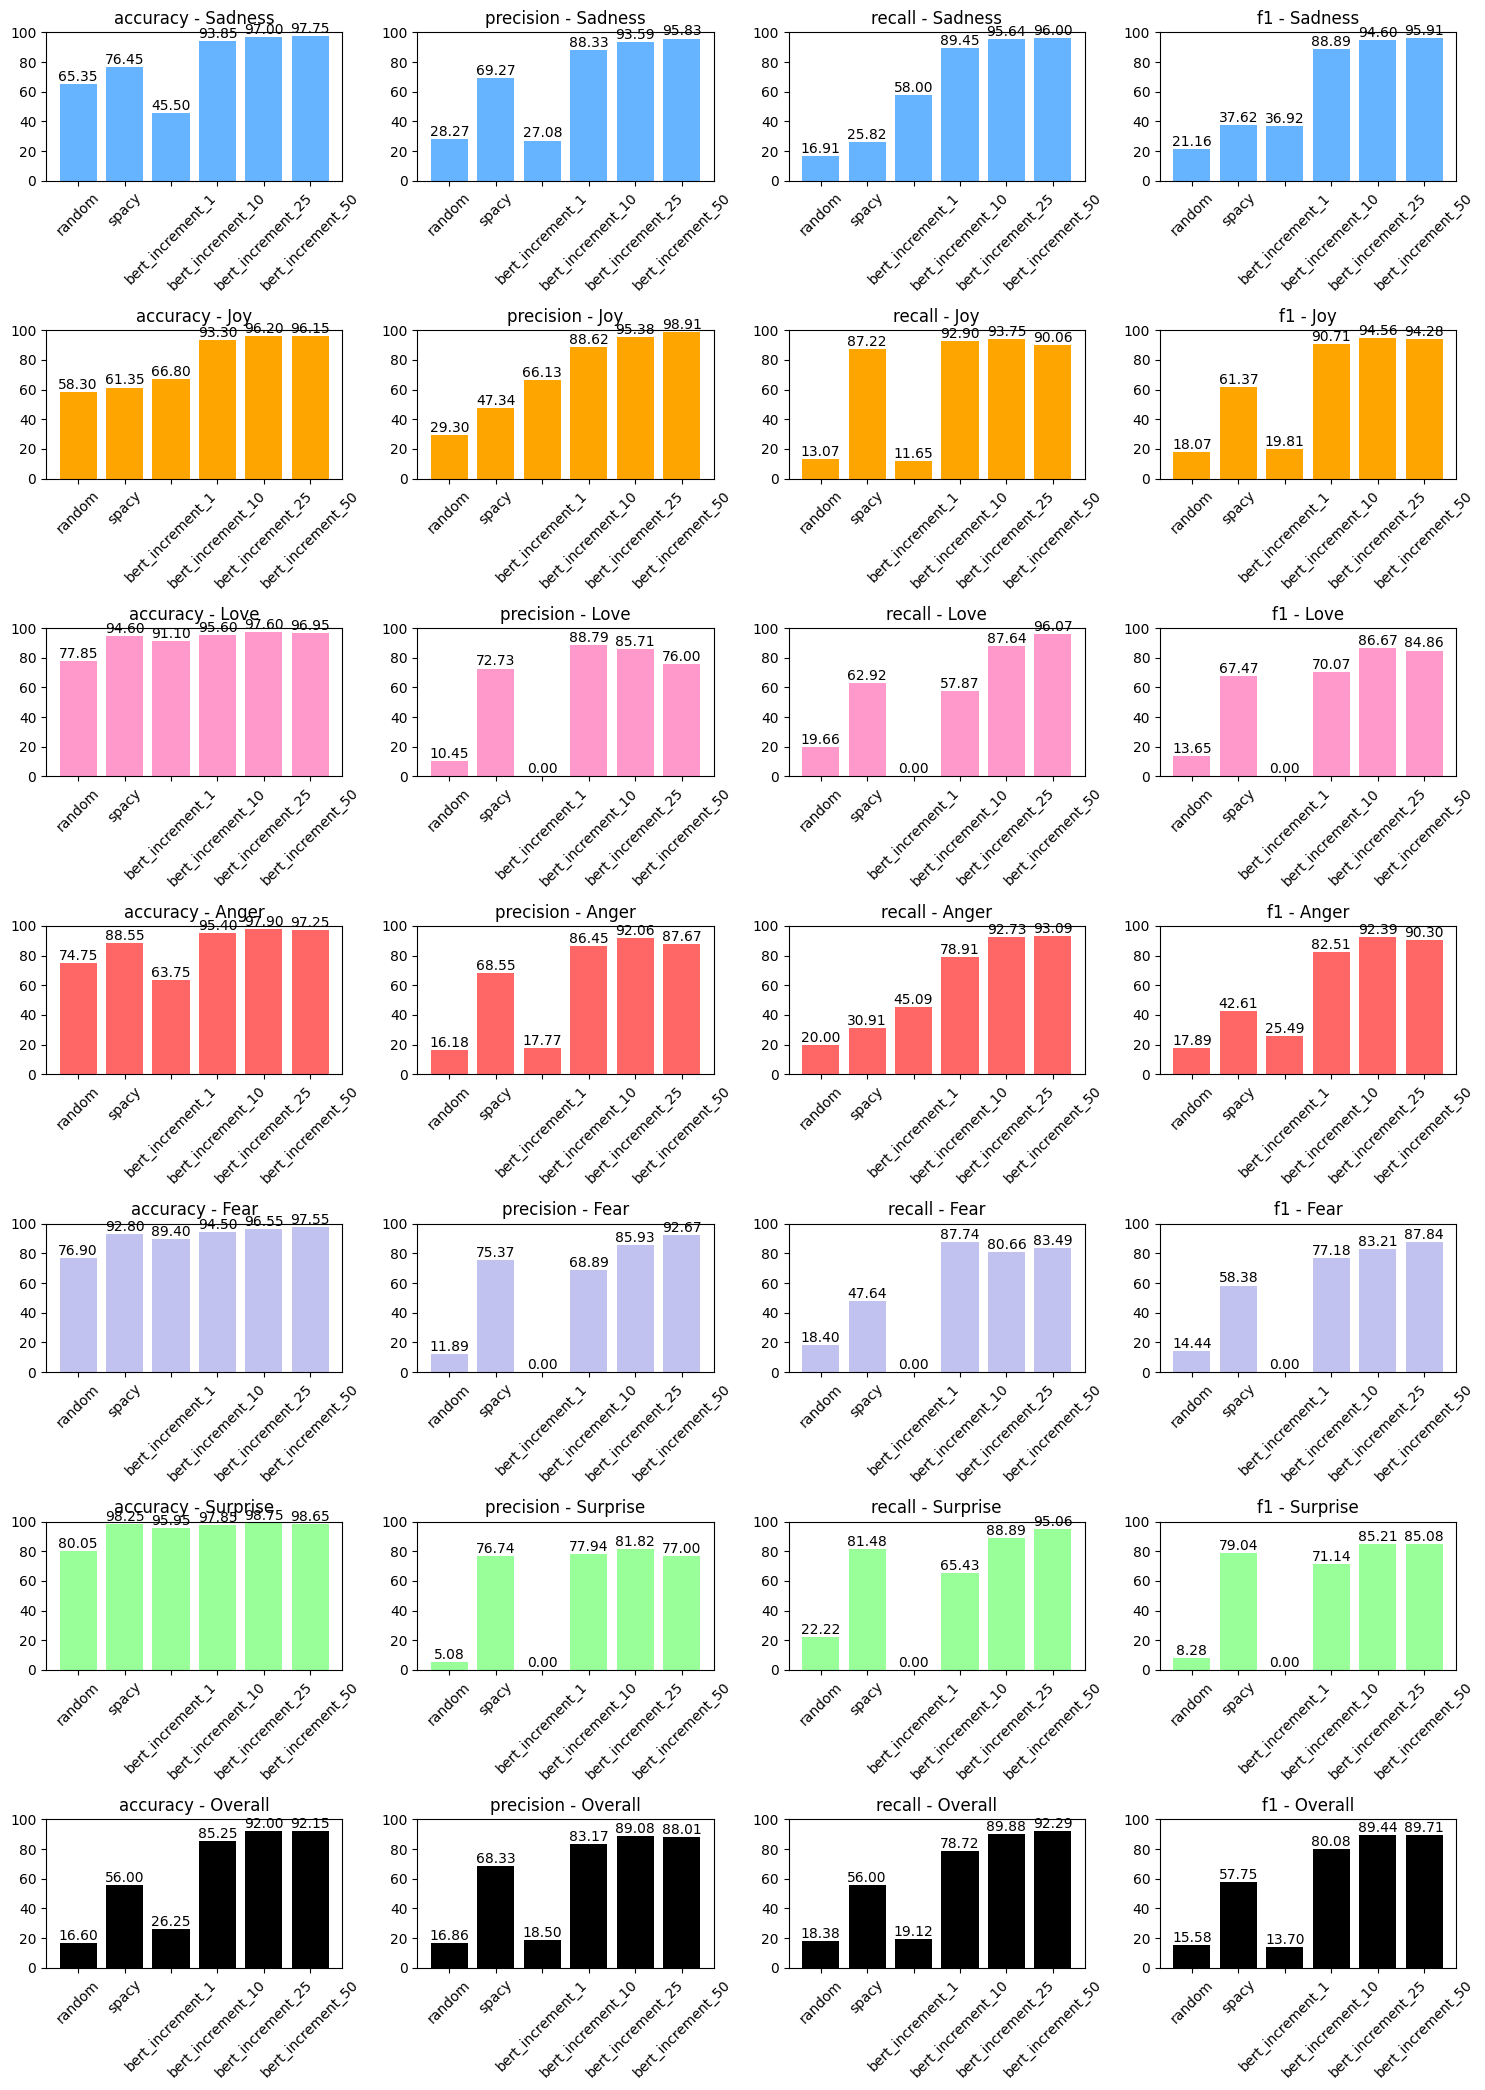

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 193s 3s/step


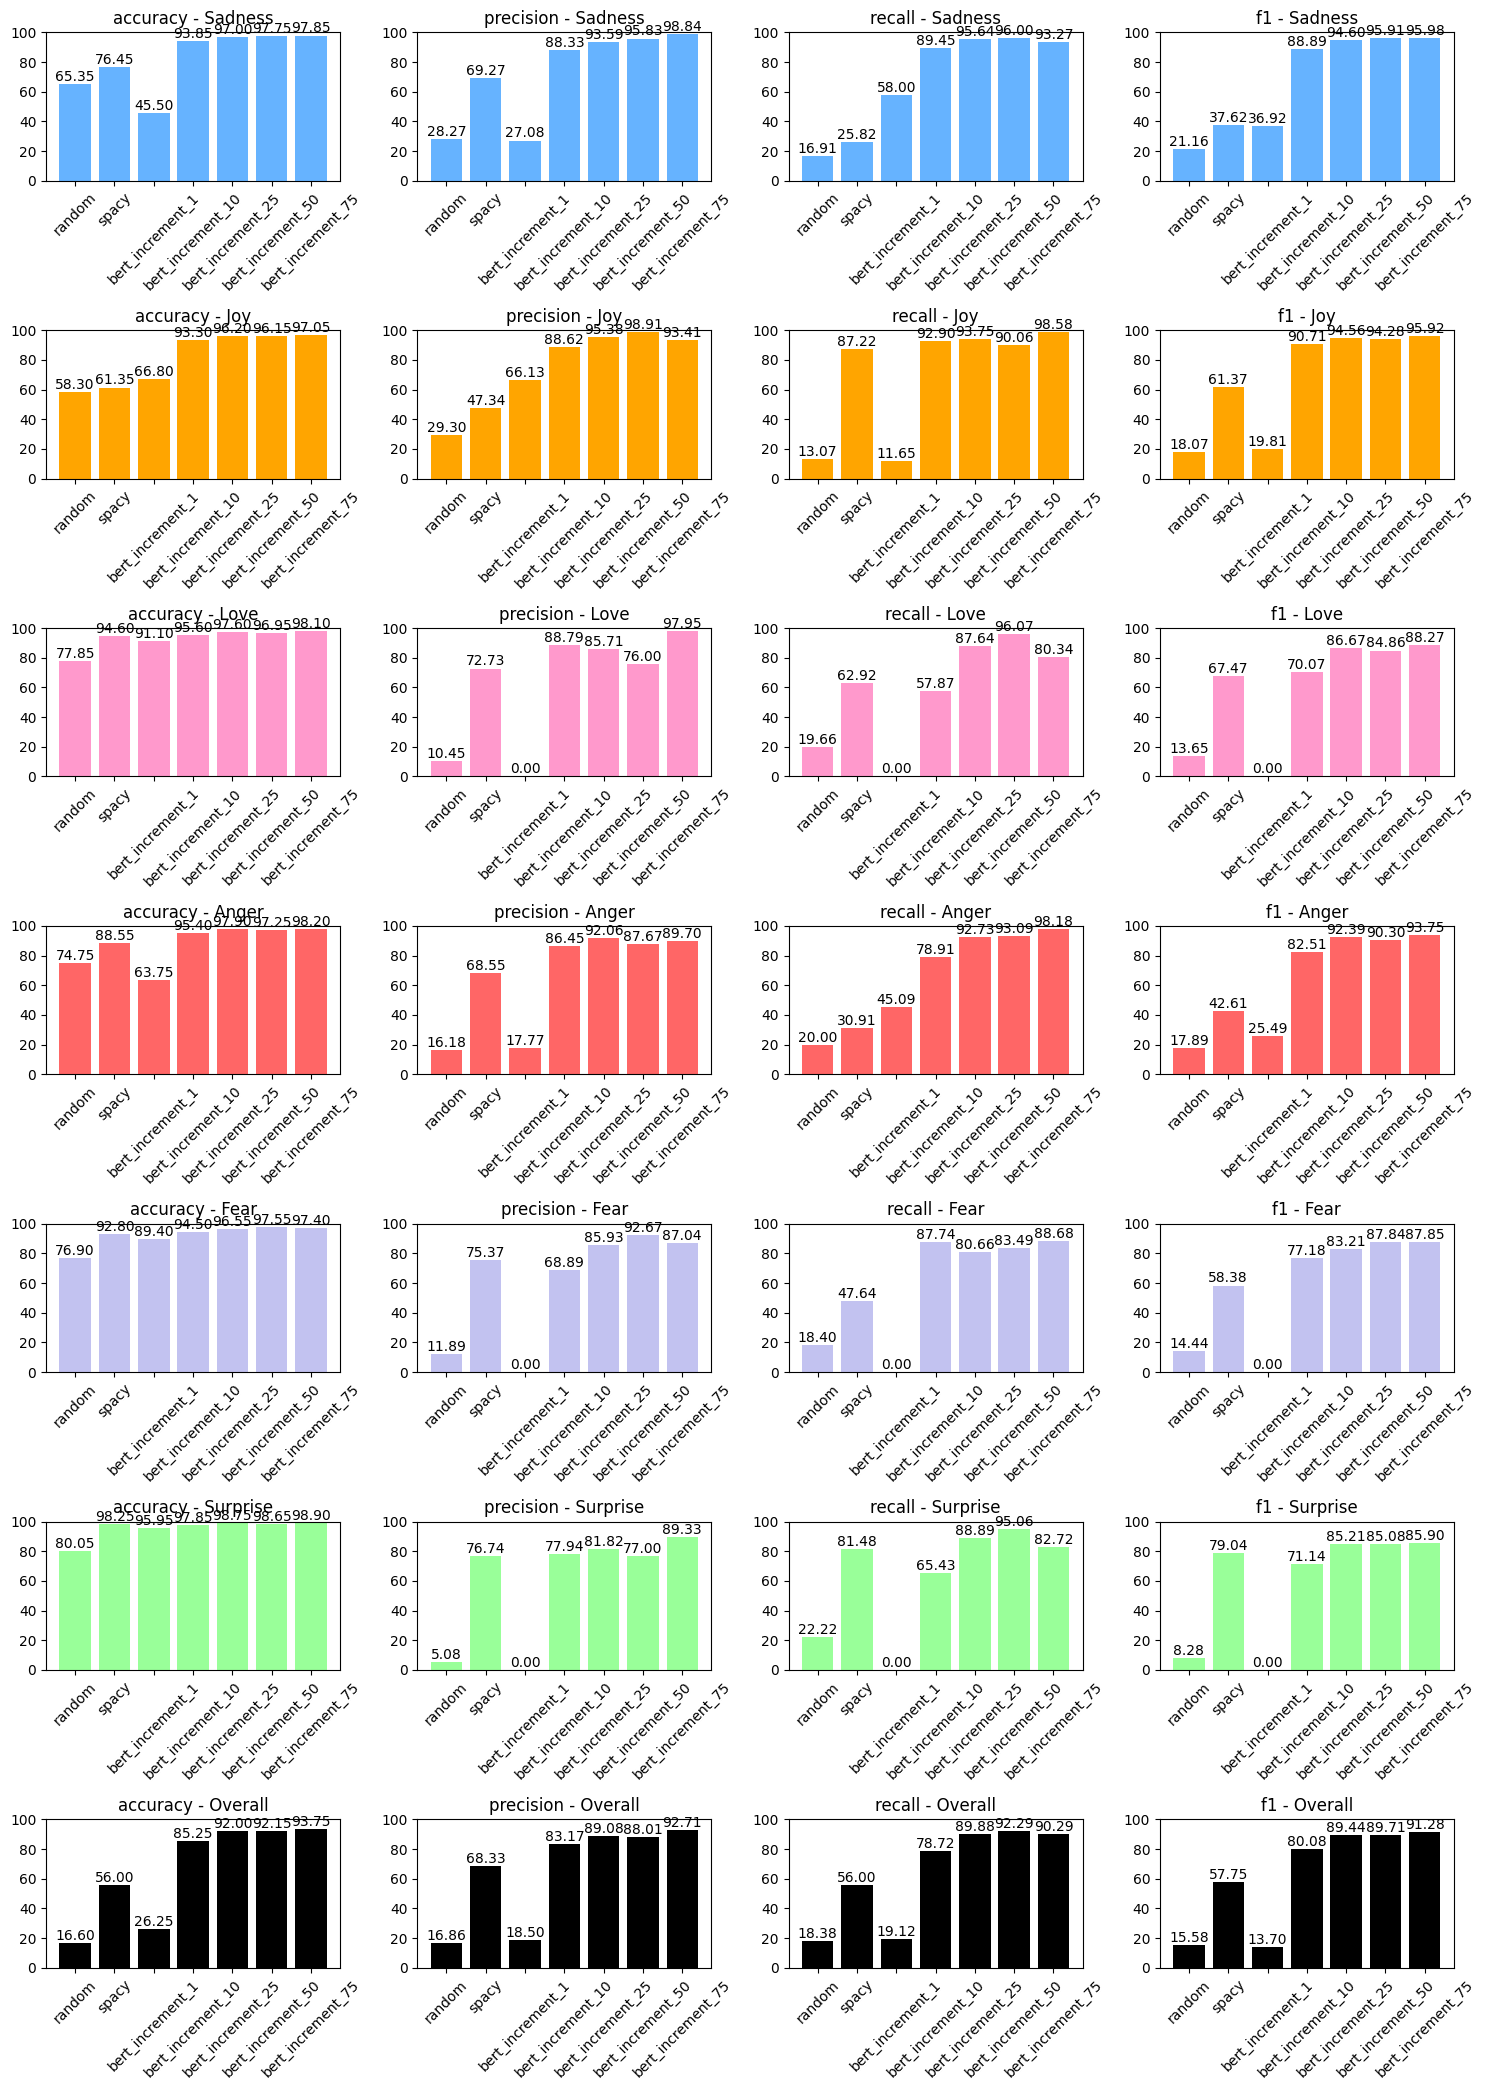

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 171s 3s/step


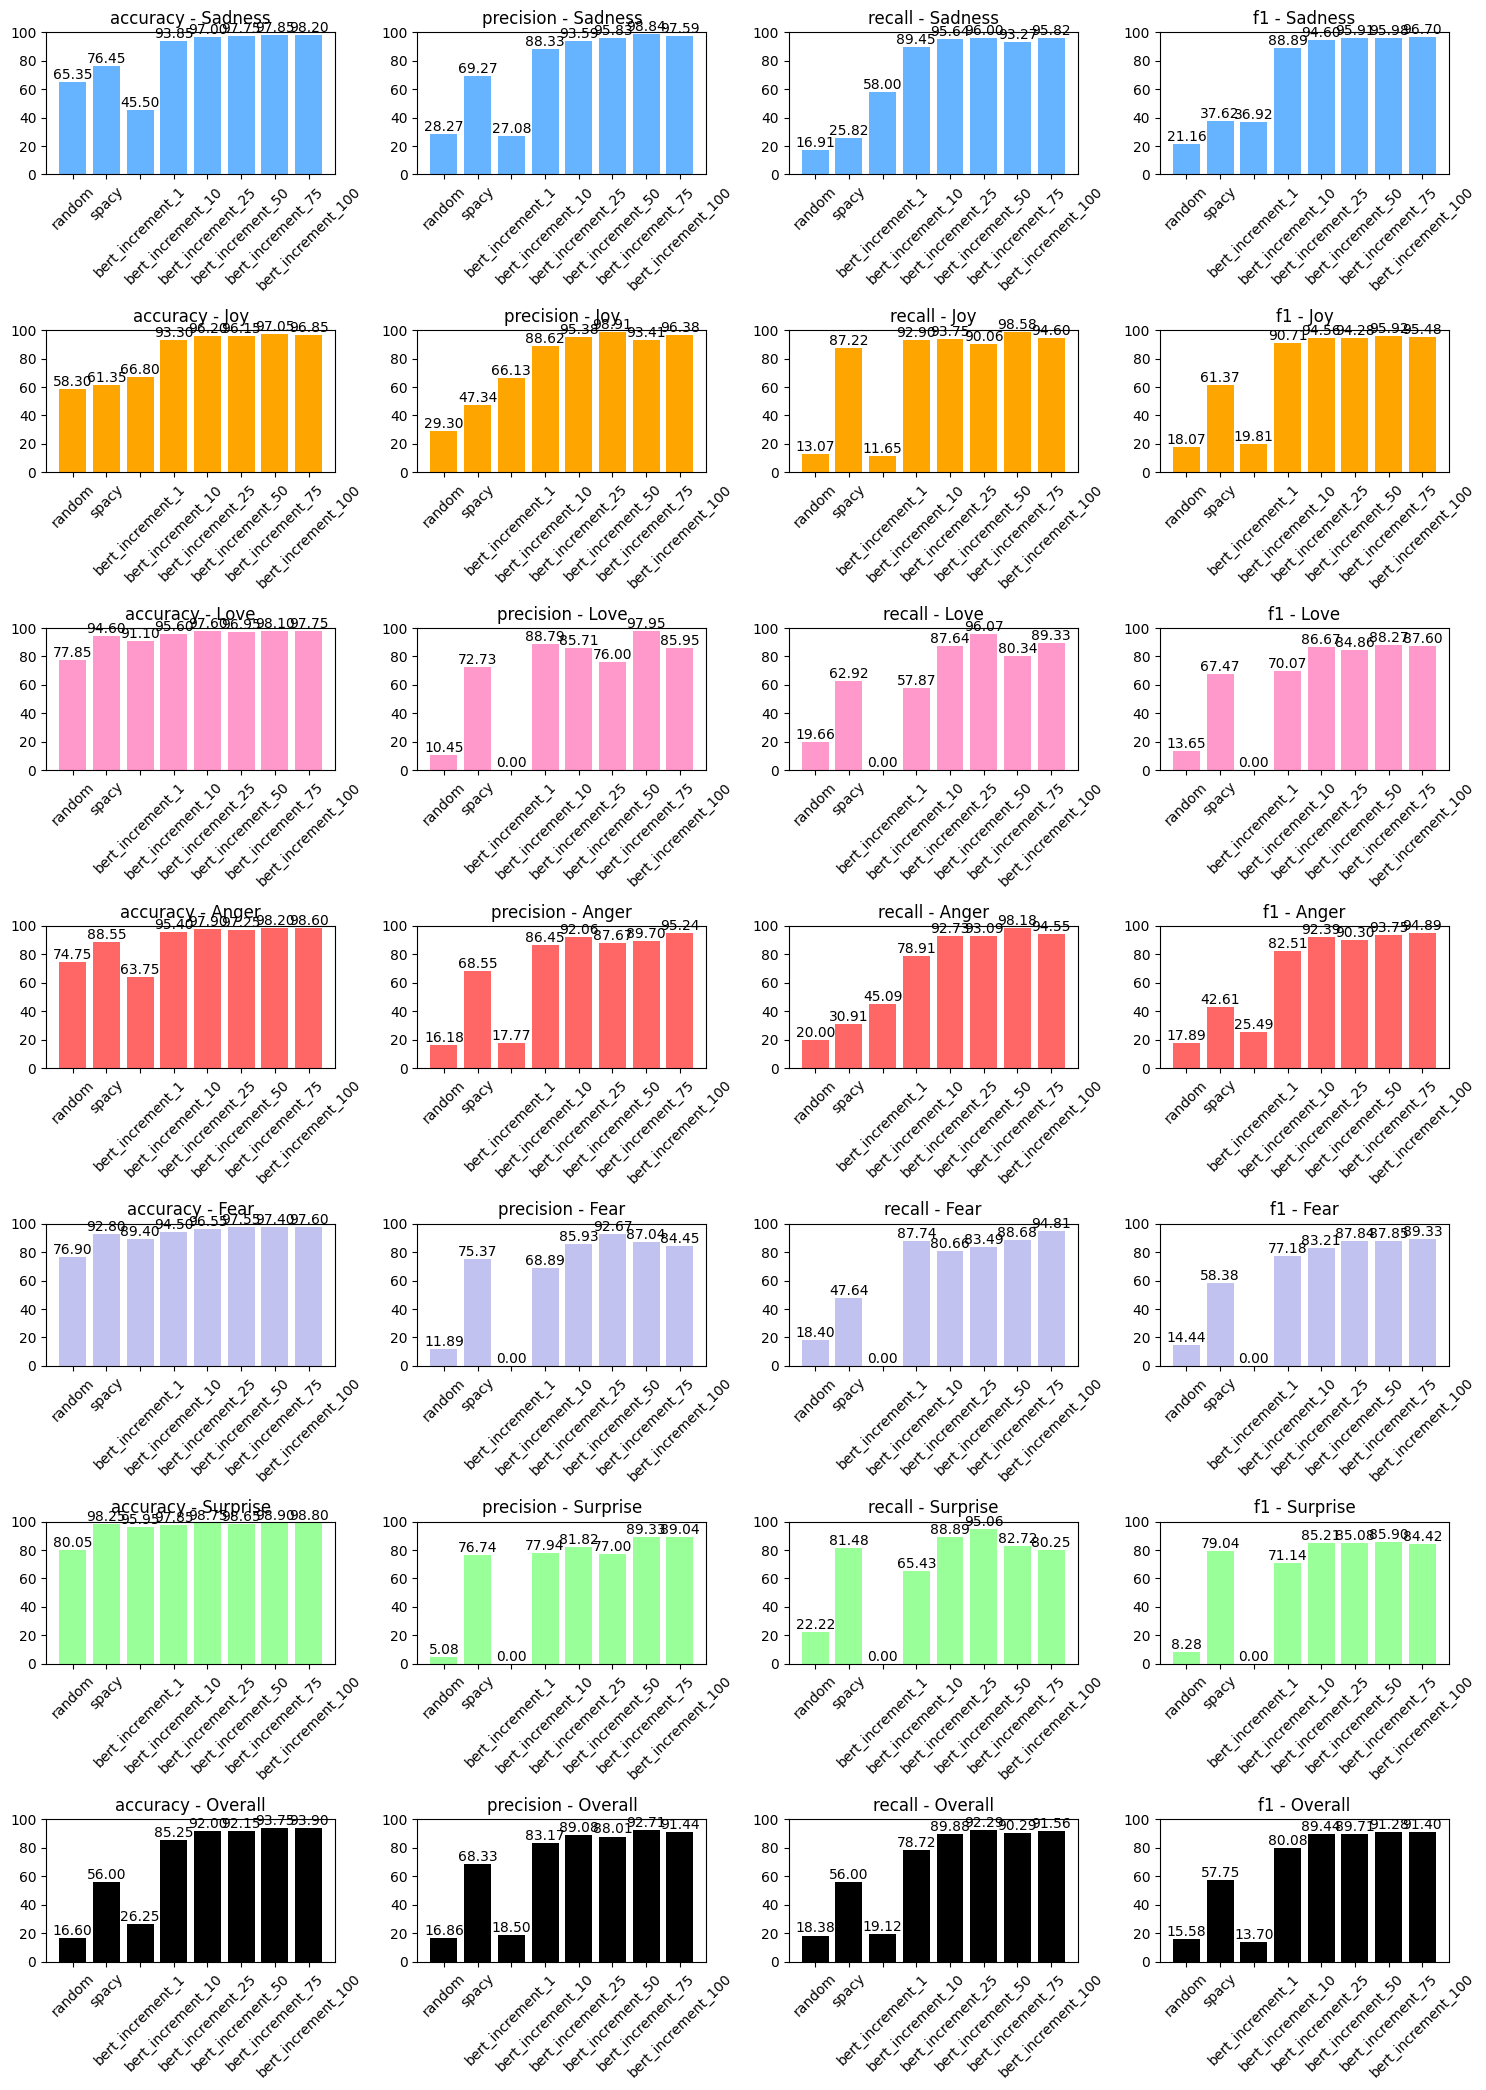

In [35]:
percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0] 

# Looping through to the validation metrics for the incremental models we created 
for percentage in percentages:
    # Load the model
    tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
    max_length = 64
    bert_model_weights_path = path_models_ + f"bert_model_weights_{int(percentage*100)}.h5"
    bert_model = load_model_weights(tokenizer, model, max_length, num_labels, rate, bert_model_weights_path)
    
    # Make predictions on the validation set
    valid_preds = tokenize_and_predict(bert_model, tokenizer, df_val, max_length)
    
    # Compute metrics for the model
    metrics_val.run(df_val['label'], valid_preds, f"bert_increment_{int(percentage*100)}")
    
    # Plot validation metrics for this model immediately
    metrics_val.plot_val()

#### Test Metrics

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 178s 3s/step


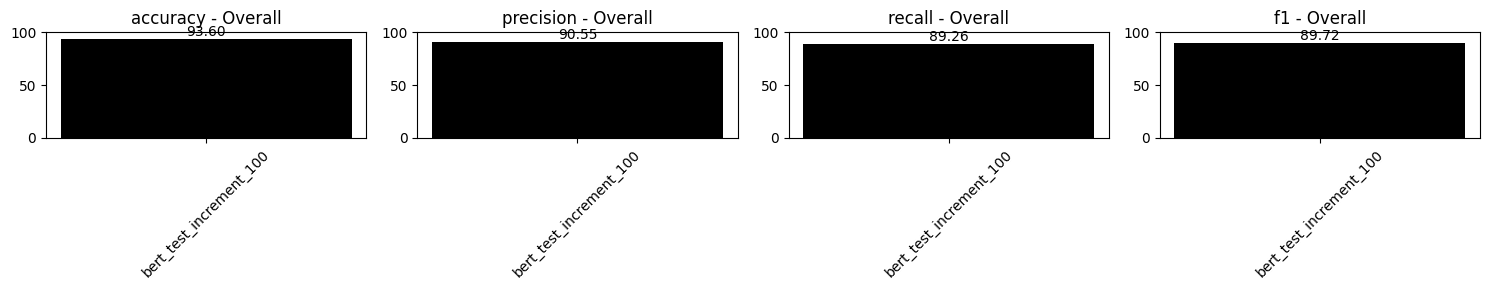

In [37]:
percentages = [1.0]

# Looping through to the test metrics for the best model
for percentage in percentages:
    # Loading the model
    tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
    max_length = 64
    bert_model_weights_path = path_models_ + f"bert_model_weights_{int(percentage*100)}.h5"
    bert_model = load_model_weights(tokenizer, model, max_length, num_labels, rate, bert_model_weights_path)
    
    # Make predictions on the test set
    test_preds_incremental = tokenize_and_predict(bert_model, tokenizer, df_test, max_length)
    
    # Compute metrics for the 100%  model
    metrics_test = Metrics()
    metrics_test.run(df_test['label'], test_preds_incremental, f"bert_test_increment_{int(percentage*100)}")
    
    # Plot test metrics for this incremental model
    metrics_test.plot()

#### Confusion Matrix 

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 191s 3s/step


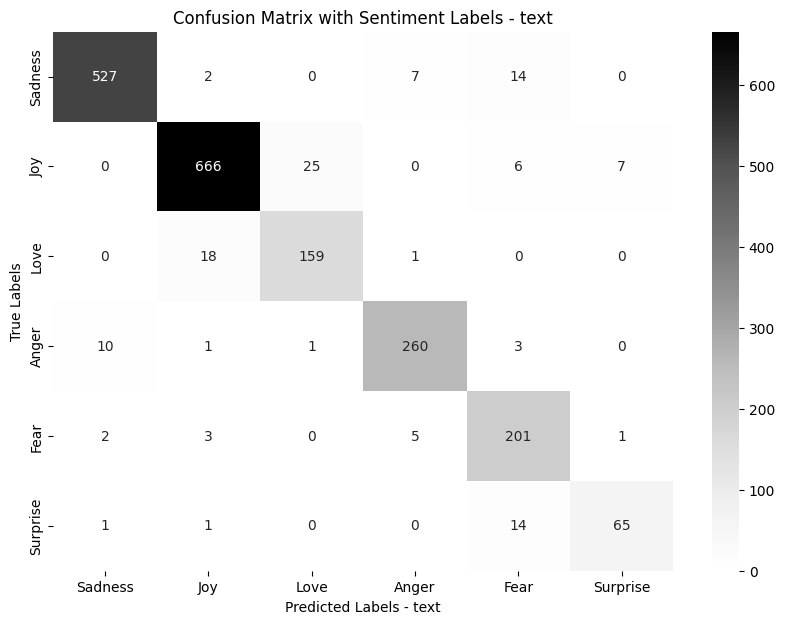

In [39]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Load the model
tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
max_length = 64
percentage = 1.0  # Use 100% of the data
bert_model_weights_path = path_models_ + f"bert_model_weights_{int(percentage*100)}.h5"
bert_model = load_model_weights(tokenizer, model, max_length, num_labels, rate, bert_model_weights_path)

# Make predictions on the validation set
valid_preds = tokenize_and_predict(bert_model, tokenizer, df_val, max_length)

# Generate confusion matrix
col = 'text'
df = df_val[['label', col]].copy()
label_names = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
cm = confusion_matrix(df['label'], valid_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.title('Confusion Matrix with Sentiment Labels - ' + col)
plt.xlabel('Predicted Labels - ' + col)
plt.ylabel('True Labels')
plt.show()

### 3.b Learning Curve
*Plot a learning curve based on the training data percentages.*

The Bert model learning curves were consistent across all metrics. 

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 181s 3s/step


/Users/nataliabeltran/anaconda3/envs/env_adv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliabeltran/anaconda3/envs/env_adv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliabeltran/anaconda3/envs/env_adv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

63/63 [==============================] - 184s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 188s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 206s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 212s 3s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 193s 3s/step


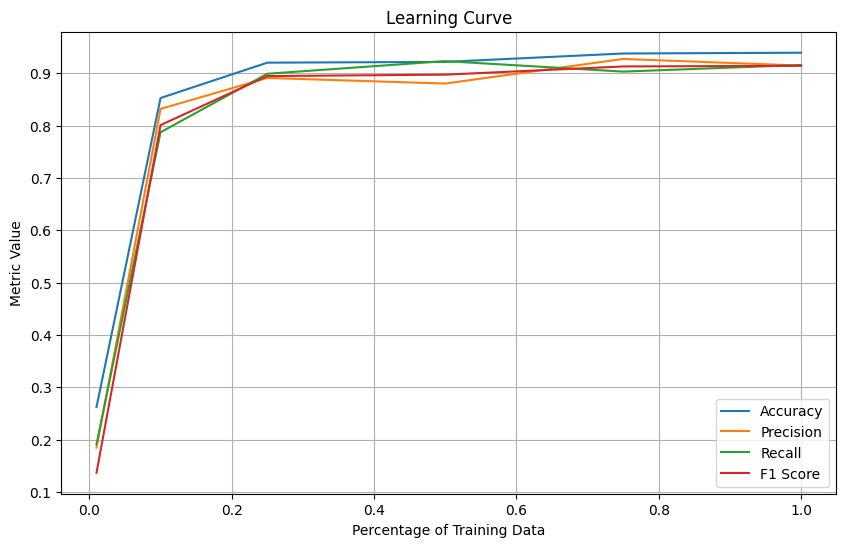

In [38]:
# Storing the training data percentages
percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

# Storing the evaluation metrics for each model
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Loop through the different percentages for training
for percentage in percentages:
    # Load the model for the current percentage
    tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
    bert_model_weights_path = path_models_ + f"bert_model_weights_{int(percentage*100)}.h5"
    bert_model = load_model_weights(tokenizer, model, max_length, num_labels, rate, bert_model_weights_path)
    
    # Make predictions on the validation set
    valid_preds = tokenize_and_predict(bert_model, tokenizer, df_val, max_length)
    
    # Computing metrics for the model
    metrics_val.run(df_val['label'], valid_preds, f"bert_increment_{int(percentage*100)}")
    
    # Overall metrics for this model
    overall_metrics = metrics_val.results['Overall'][f"bert_increment_{int(percentage*100)}"]
    
    # Append the metrics to the lists
    accuracy_list.append(overall_metrics['accuracy'])
    precision_list.append(overall_metrics['precision'])
    recall_list.append(overall_metrics['recall'])
    f1_list.append(overall_metrics['f1'])

# Plot of the learning curves 
plt.figure(figsize=(10, 6))
plt.plot(percentages, accuracy_list, label='Accuracy')
plt.plot(percentages, precision_list, label='Precision')
plt.plot(percentages, recall_list, label='Recall')
plt.plot(percentages, f1_list, label='F1 Score')
plt.xlabel('Percentage of Training Data')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

### 3.c Technique Comparison
*Incorporate the techniques tested in Part 2 into your training schema for comparison.*

When analyzing the confusion matrix we found similar issue as earlier of labels such as "Joy" and "Love" not being properly labeled in order to potentially improve these results we utilized the method found in section 2.e of data augmentation in our best model (100% data). When investigating the examples, as well as the cluster, we saw some themes emerging such as those of related to relationship, self-perception, and spirituality. 

An example for the theme of relationship such as "i feel as if i am the beloved preparing herself for the wedding",with words in our clusters such as "loved", "passionate" and "wedding". For self-relflection there was an example "i can say is that i feel like myself when i put on a skirt heels and lipstick and when i wear clothing which has come to be accepted as neutral and nondescript like a t shirt and jeans i dont feel like myself" with our clusters showing that same sentiment with terms such as "one",and  "feeling". The spirituality showed in examples such as "i am reading something the saints have written i feel a real pang of sweet pain for the love they have for our lord" with out clusters discussing "prayer", "blessed" and "granted". When looking at the misclassifications it examples some of the phrases that were misclassified as "Joy" used terms such as "feel", "love",and "fulfillment" which are inherently really close terms that have to do with love, and the opposite can be seen with "Love" that had terms such as "feel" and "beloved". The model currently might not have enough data in order to properly label terms that are so similar. 

As done earlier, we created prompts that are able to invoce similar themes without creating copies of the current text, we created the following prompts:
- "Recall a vivid memory from your past that evoked a strong emotional response, such as ({label}). Use the examples provided as a guide for writing style to write some twitter messages: ({label})"
- "Explore a particular emotion a person can have experienced recently, such as ({label}) and how that impacted their thoughts. Use the examples provided as a guide for writing style to write some twitter messages: ({label})"
- "Imagine a hypothetical scenario where someone encountered a challenging situation that elicits a complex mix of emotions, including ({label}) and internal dialogue. Use the examples provided as a guide for writing style to write some twitter messages: ({label})"

When looking at the results the augmentation seems to have improved the models performance for true label "Love" mislabeled as "Joy" from 17 to 5, but increased from true label "Joy" to "Love" labels from 25 to 38. The increase could be due to the characteristics of the training data. 

In [40]:
# Investigate instances where Joy is classified as Love and vice versa
df_specific_joy_as_love = df_val[(df_val['label'] == 1) & (valid_preds == 2)].copy().reset_index(drop=True)
df_specific_love_as_joy = df_val[(df_val['label'] == 2) & (valid_preds == 1)].copy().reset_index(drop=True)

labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Initialize empty lists for each label
example_texts_joy_as_love = []
example_texts_love_as_joy = []

# Iterate through each row in df_specific_joy_as_love and append 'text' to the corresponding label list
for index, row in df_specific_joy_as_love.iterrows():
    text = row['text']
    example_texts_joy_as_love.append(text)

# Iterate through each row in df_specific_love_as_joy and append 'text' to the corresponding label list
for index, row in df_specific_love_as_joy.iterrows():
    text = row['text']
    example_texts_love_as_joy.append(text)

# Print the lists
if len(example_texts_joy_as_love) > 0:
    print("Misclassification Joy (1) as Love (2) Examples:")
    print(example_texts_joy_as_love[:5])  # Print the first 5 examples
    print()

if len(example_texts_love_as_joy) > 0:
    print("Misclassification Love (2) as Joy (1) Examples:")
    print(example_texts_love_as_joy[:5])  # Print the first 5 examples
    print()

Misclassification Joy (1) as Love (2) Examples:
['i feel as if i am the beloved preparing herself for the wedding', 'i am feeling very blessed today that they share such a close bond', 'i didn t feel accepted', 'i feel accepted by the boys', 'i have stayed at heritage christian because of the fulfillment that i feel in doing christ s work in action by being the hands the eyes the legs and the voice of supporting the individuals that i have been blessed to know and support']

Misclassification Love (2) as Joy (1) Examples:
['i am reading something the saints have written i feel a real pang of sweet pain for the love they have for our lord', 'i can say is that i feel like myself when i put on a skirt heels and lipstick and when i wear clothing which has come to be accepted as neutral and nondescript like a t shirt and jeans i dont feel like myself', 'i have had several new members tell me how comfortable they feel with how accepted they are by the existing members and that is great to he

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import nltk

# Define stopwords
stop_words = stopwords.words('english')

# Misclassified texts "Joy"
all_texts_joy = example_texts_love_as_joy 

# TF-IDF vectorizer with stop words
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Transform the text data into TF-IDF features
X = vectorizer.fit_transform(all_texts_joy)

# K-means clustering
k = 3  
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Cluster centers 
cluster_centers = kmeans.cluster_centers_.argsort()[:, ::-1]

# Feature names 
feature_names = vectorizer.get_feature_names_out()

# Top 10 words for each cluster
for i in range(k):
    print(f"Cluster {i}:")
    top_words = [feature_names[ind] for ind in cluster_centers[i, :10] if feature_names[ind] not in stop_words] 
    print(top_words)
    print()

Cluster 0:
['loved', 'remember', 'special', 'beautiful', 'honest', 'sweaty', 'mere', 'person', 'earth', 'one']

Cluster 1:
['feeling', 'going', 'im', 'generous', 'little', 'tastes', 'done', 'show', 'ill', 'clothing']

Cluster 2:
['feel', 'like', 'sweet', 'gracious', 'something', 'faithful', 'rest', 'members', 'love', 'always']



In [43]:
# Misclassified texts "Love"
all_texts_love = example_texts_joy_as_love 

# TF-IDF vectorizer with stop words
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Transform the text data into TF-IDF features
X = vectorizer.fit_transform(all_texts_love)

# K-means clustering
k = 3 
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Cluster centers 
cluster_centers = kmeans.cluster_centers_.argsort()[:, ::-1]

# Feature names 
feature_names = vectorizer.get_feature_names_out()

# Top 10 words for each cluster
for i in range(k):
    print(f"Cluster {i}:")
    top_words = [feature_names[ind] for ind in cluster_centers[i, :10] if feature_names[ind] not in stop_words]  
    print(top_words)
    print()

Cluster 0:
['passionate', 'life', 'like', 'feel', 'anymore', 'anything', 'im', 'regularly', 'prayer', 'pray']

Cluster 1:
['blessed', 'part', 'feel', 'known', 'completely', 'days', 'group', 'granted', 'take', 'allowed']

Cluster 2:
['accepted', 'feel', 'generous', 'boys', 'always', 'much', 'preparing', 'wedding', 'beloved', 'given']



#### Generate more gpt data

#### Building Models 

In [ ]:
incremented_df_prompt = pd.read_csv(path_models_+'increment_df_clean_3c.csv')

all_increment = pd.concat([df_train, incremented_df_prompt], ignore_index = False)
all_increment.loc[all_increment['prompt'].isna(), 'prompt'] = 'original'

#### Test Metrics

On the out of sample performance, the Bert model with 100% data is the best. It is important to note that the performance of the model with the augmentation technique achieved very similar results.  

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 203s 3s/step


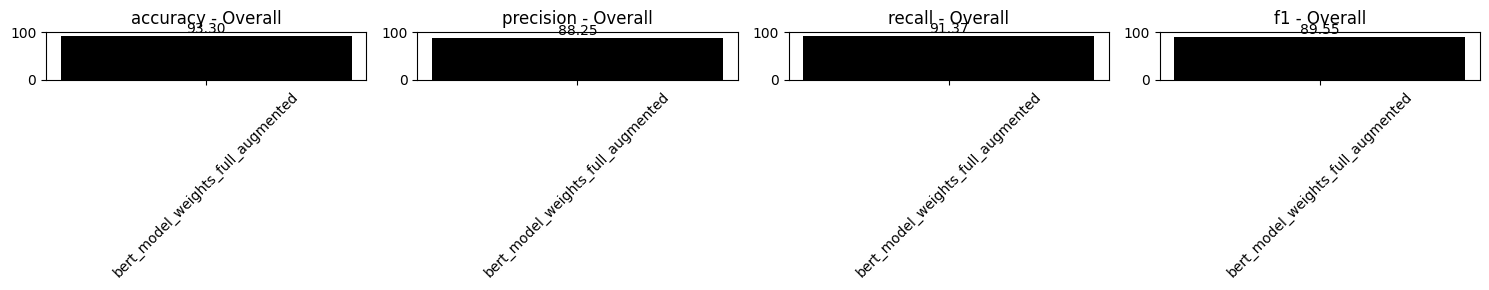

In [44]:
## test metrics

tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
max_length = 64
bert_model_weights_path = path_models_ + f"bert_model_weights_full_augmented.h5"
bert_model = load_model_weights(tokenizer, model, max_length, num_labels, rate, bert_model_weights_path)
    
# Make predictions on the test set
test_preds_incremental = tokenize_and_predict(bert_model, tokenizer, df_test, max_length)
    
# Compute metrics for the incremental model
metrics_incremental = Metrics()
metrics_incremental.run(df_test['label'], test_preds_incremental, f"bert_model_weights_full_augmented")
    
# Plot test metrics for this incremental model   
metrics_incremental.plot()

#### Confusion matrix Augmented Bert with full data

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 216s 3s/step


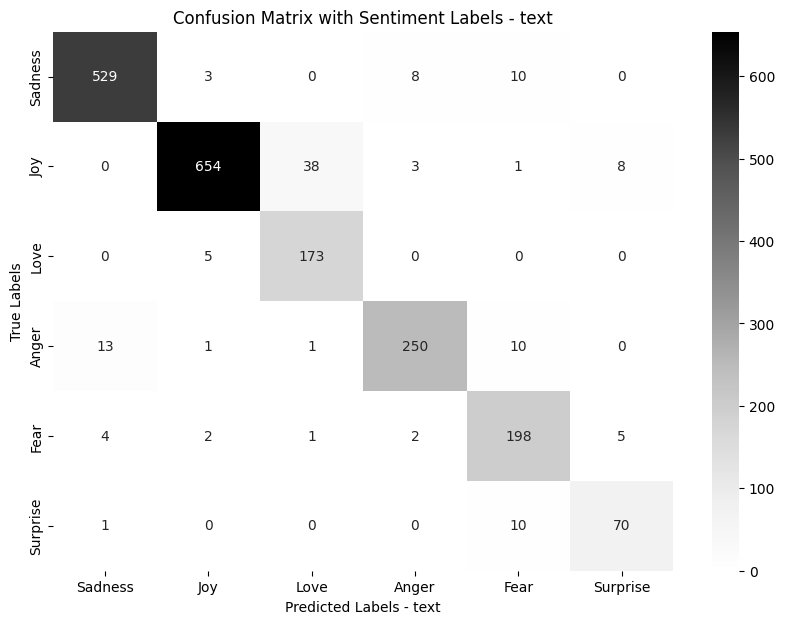

In [45]:
# Load the model
tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
max_length = 64
percentage = 1.0  # Use 100% of the data
bert_model_weights_path = path_models_ + f"bert_model_weights_full_augmented.h5"
bert_model = load_model_weights(tokenizer, model, max_length, num_labels, rate, bert_model_weights_path)

# Make predictions on the validation set
valid_preds = tokenize_and_predict(bert_model, tokenizer, df_val, max_length)

# Generate confusion matrix
col = 'text'
df = df_val[['label', col]].copy()
label_names = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
cm = confusion_matrix(df['label'], valid_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.title('Confusion Matrix with Sentiment Labels - ' + col)
plt.xlabel('Predicted Labels - ' + col)
plt.ylabel('True Labels')
plt.show()

### 3.d Methodology Analysis
*Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.*

Comparing the overall metrics we see:
<br>
<br>
*Bert Incremented Best Model*
| Metric            |  Model % Performance Test | SOA |
|-------------------|--------------------------|---------|
| Accuracy          |        93.60                  |  94.54    |
| Precision         |         90.55                |        |
| Recall            |             89.26            |        |
| F1 Score          |                89.72          |  94.58     |

*Bert Incremented Augmented*
| Metric            | Model % Performance Test |
|-------------------|--------------------------|
| Accuracy          |      93.3                |
| Precision         |     88.25                   |
| Recall            |        91.37                   |
| F1 Score          |         89.55                  |

Training time for both models:

| Training time  | Bert Incremented Best Model | Bert Incremented Augmented |
|-------------------|--------------------------------|--------------------------|
| Epoch 1        |             16688s 67s/step                   |         4130 16s/step                 |
| Epoch 2        |              8765s 35s/tep                  |         5242s 21s/step                 |

When comparing metrics alone both models performed relatively similar with the full data Bert performing slightly better on most of the metrics. When it comes to training time the augmented model was quicker but had more misclassifications compared to the full data model. When analyzing the differences it is shows that both models struggled with the labels for "Joy" and "Sadness". The limitations of the augmented techinique is its dependence on the prompts to generate the appropriate data to enhance the model performance, thereby restricting our model to operate within the  limits of these prompts. 

 
Finally, if we compare our best model with the SOA we see that we have managed to get close in terms of accuracy but our F1 Score is still not as good.

#### Model Differences 

In [46]:
# Load the full data BERT model
tokenizer_full, model_full = setup_bert(checkpoint="bert-base-uncased")
max_length_full = 64
bert_model_weights_path_full = path_models_ + "bert_model_weights_100.h5"
bert_model_full = load_model_weights(tokenizer_full, model_full, max_length_full, num_labels, rate, bert_model_weights_path_full)

# Load the augmented data BERT model
tokenizer_augmented, model_augmented = setup_bert(checkpoint="bert-base-uncased")
max_length_augmented = 64
bert_model_weights_path_augmented = path_models_ + "bert_model_weights_full_augmented.h5"
bert_model_augmented = load_model_weights(tokenizer_augmented, model_augmented, max_length_augmented, num_labels, rate, bert_model_weights_path_augmented)

# Make predictions on the same test set for both models
test_preds_full = tokenize_and_predict(bert_model_full, tokenizer_full, df_test, max_length_full)
test_preds_augmented = tokenize_and_predict(bert_model_augmented, tokenizer_augmented, df_test, max_length_augmented)

# Compute metrics for both models
metrics_full = Metrics()
metrics_augmented = Metrics()

metrics_full.run(df_test['label'], test_preds_full, "bert_full_data")
metrics_augmented.run(df_test['label'], test_preds_augmented, "bert_augmented_data")

# Compare predictions between the two models
differences = []
for i in range(len(test_preds_full)):
    true_label = df_test['label'][i]
    pred_full = test_preds_full[i]
    pred_augmented = test_preds_augmented[i]
    
    if pred_full != pred_augmented:
        differences.append((i, true_label, pred_full, pred_augmented))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 1066s 17s/step


In [47]:
# Examine  patterns
patterns = {}
for idx, true_label, pred_full, pred_augmented in differences:
    if true_label not in patterns:
        patterns[true_label] = {"full_data_correct": 0, "augmented_data_correct": 0, "both_incorrect": 0}
    
    if pred_full == true_label and pred_augmented != true_label:
        patterns[true_label]["full_data_correct"] += 1
    
    if pred_augmented == true_label and pred_full != true_label:
        patterns[true_label]["augmented_data_correct"] += 1
    
    if pred_full != true_label and pred_augmented != true_label:
        patterns[true_label]["both_incorrect"] += 1

# Feature analysis
features_analysis = {}
for idx, true_label, pred_full, pred_augmented in differences:
    text_data = df_test['text'][idx]
    if true_label not in features_analysis:
        features_analysis[true_label] = {"full_data_incorrect": [], "augmented_data_incorrect": []}
    
    if pred_full != true_label and pred_augmented == true_label:
        features_analysis[true_label]["full_data_incorrect"].append(text_data)
    
    if pred_augmented != true_label and pred_full == true_label:
        features_analysis[true_label]["augmented_data_incorrect"].append(text_data)

In [48]:
# Print patterns
print("Patterns in differences:")
for true_label, pattern in patterns.items():
    print(f"True Label: {true_label}")
    print(f"Full Data Correct, Augmented Incorrect: {pattern['full_data_correct']}")
    print(f"Augmented Data Correct, Full Incorrect: {pattern['augmented_data_correct']}")
    print(f"Both Incorrect: {pattern['both_incorrect']}\n")

Patterns in differences:
True Label: 4
Full Data Correct, Augmented Incorrect: 7
Augmented Data Correct, Full Incorrect: 8
Both Incorrect: 0

True Label: 3
Full Data Correct, Augmented Incorrect: 12
Augmented Data Correct, Full Incorrect: 5
Both Incorrect: 1

True Label: 1
Full Data Correct, Augmented Incorrect: 28
Augmented Data Correct, Full Incorrect: 3
Both Incorrect: 3

True Label: 2
Full Data Correct, Augmented Incorrect: 1
Augmented Data Correct, Full Incorrect: 17
Both Incorrect: 1

True Label: 5
Full Data Correct, Augmented Incorrect: 1
Augmented Data Correct, Full Incorrect: 6
Both Incorrect: 0

True Label: 0
Full Data Correct, Augmented Incorrect: 4
Augmented Data Correct, Full Incorrect: 8
Both Incorrect: 2



In [49]:
# Print feature analysis
print("Feature Analysis:")
for true_label, analysis in features_analysis.items():
    print(f"True Label: {true_label}")
    print("Full Data Incorrect:")
    for text_data in analysis["full_data_incorrect"]:
        print(text_data)
    print("Augmented Data Incorrect:")
    for text_data in analysis["augmented_data_incorrect"]:
        print(text_data)

Feature Analysis:
True Label: 4
Full Data Incorrect:
i don t feel particularly agitated
i feel agitated with myself that i did not foresee her frustrations earlier leading to the ending of our relationship
i feel agitated and annoyed more than worried or fearful but these feelings can easily lead to being short tempered with my family and feelings of disharmony
i grabbed my dog and hugged her fiercly for the next hour or so until i began to feel a bit like myself again but i havent completly shaken the feeling and have been feeling rather depressed anxious all day
im feeling too tortured to write today
i that it feels like she is being tortured
i seek out pain to feel tortured just to feel something
i decide that picking the easy route would get me nowhere and i feel like other people want me tortured so i follow the blue path
Augmented Data Incorrect:
i have a lot going on in my life and feel overwhelmed
i indicated then i was feeling quite overwhelmed with work responsibilities teach

## <a id='part4'>Part 4: Model Distillation</a>


### 4.a Model Distillation
*Distill your best-performing model into a lighter model. Document the process and tools used.*

We want to compress a "teacher" model into a smaller "student" model that will simultaneously be trained to minimize loss but also to learn the weights of the teacher. In order to do that we have created a class called Distillation that is:

- Initialized with the checkpoints of the teacher and student models, the number of labels, optimizer for the training of the student model, and paths to already existing weights.

- It has functions to prepare the data for the training:
    - Prepare data : returns X_train as an array and y_train as one-hot encoded labels
    - Get_batches : Uses the batch_encode_plus function of the tokenizer to add special tokens ([CLS], [SEP]), truncate sentences longer than
    max_lenght, and generate attention masks. The data is then shuffled, which improves generalisation.

- Train step: 
    - @tf.function: Improves performance by constructing a tf.types.experimental.PolymorphicFunction (see [link](https://www.tensorflow.org/api_docs/python/tf/function))

    - tf.GradientTape(): Is for differentiation, in this case to do the gradient descent, where the direction of the descent at each step is determined by the gradient of the loss function with respect to the model parameters.

    - Then at each step we get the predictions of the teacher and student models but only the student is in training mode. These are the logits, so the predictions before the softmax activation function is applied to the output.

    - Then we specify a custom loss function made out of two different loss functions:

$$ L=\alpha⋅L_{soft}⋅T^2​+(1−\alpha)⋅L_{hard}​$$

Which is as in this example in this [Keras article](https://keras.io/examples/vision/knowledge_distillation/) and as explained in [Hinton et al (2015)](https://arxiv.org/abs/1503.02531) except that the alpha and (1-alpha) are switched around. Other ways to refer to these losses is as distillation (=soft) loss and student (=hard) loss.

Where:

- Soft loss: Calculated using the Kullback-Leibler Divergence (KL Divergence), a measure of difference between probavbility distributions of the teacher and student models after passing the logits through the softmax function scaled by the temperature parameter (explained below).

- Hard loss: Difference between student predictions and true labels.

And two parameters:

- alpha: The weight given to each of the losses. 0.5 would be equal weight, higher than that gives higher weight to the soft loss in our function. 

- temperature: Is the smoothing of the output distribution. Higher T means a softer distribution. Very high Ts turn the distribution into a uniform distribution (source: Towards Data Science [link](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f))


Hinton et al. (2015) in "Distilling the Knowledge in a Neural Network" write that the soft loss also has to be multiplied by the squared temperature parameter since otherwise choosing different T would change the weights. Regarding the weights they write: *"We found that the best results were generally obtained by using a condiderably lower weight on the second objective function"* (p.3). Following this advice we have tried alphas of 0.75, 0.5 and 0.25 and found that in our specific case it was better to use equal weights. On the MNIST dataset, Hinton et al. try temperatures of 1,2,5 and 10 and find that 2 is best. In our case we tried 2, 5, 10 and 20 found 10 to be the best.
    
The expectation is that the student model will be able to keep most of the accuracy of the teacher model while being less computationally expensive.

In [7]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from sklearn.preprocessing import OneHotEncoder
from transformers import TFBertForSequenceClassification, TFDistilBertForSequenceClassification, DistilBertTokenizer

class Distillation:

    def __init__(self, teacher_checkpoint, student_checkpoint, num_labels, optimizer, alpha=0.5, temperature=2.0, path_to_teacher_weights=None, path_to_student_weights=None):
        """
        Initializing class
        
        Args:
            teacher_checkpoint (string): Identifier for the teacher model.
            student_checkpoint (string): Identifier for the student model.
            num_labels (int): Number of unique labels in the target.
            optimizer: Optimization algorithm for the student weights.
            alpha (float): Factor to weight the student and distillation loss.
            temperature (float): Temperature for softening probability distributions.
            path_to_teacher_weights (string, optional): Path to the location of weights of the teacher model.
            path_to_student_weights (string, optional): Path to the location of weights of the student model.
        """
        self.teacher_model = TFBertForSequenceClassification.from_pretrained(teacher_checkpoint, num_labels=num_labels)

        if path_to_teacher_weights:
            self.teacher_model.load_weights(path_to_teacher_weights)
        
        self.student_model = TFDistilBertForSequenceClassification.from_pretrained(student_checkpoint, num_labels=num_labels)
        
        if path_to_student_weights:
            self.student_model.load_weights(path_to_student_weights)

        self.student_tokenizer = DistilBertTokenizer.from_pretrained(student_checkpoint)
        self.optimizer = optimizer
        self.alpha = alpha
        self.temperature = temperature
        self.loss_fn = CategoricalCrossentropy(from_logits=True)
        self.enc = OneHotEncoder(handle_unknown='ignore')

    def prepare_data(self, df_sample):
        """
        Prepare text data and labels for training.

        Args:
            df_sample (pd.DataFrame): DataFrame with text data and labels.

        Returns:
            tuple: Tuple containing X_train and y_train (labels, one-hot encoded).
        """
        y_train = self.enc.fit_transform(np.array(df_sample['label']).reshape(-1, 1)).toarray()
        
        X_train = np.array(df_sample['text'])
        
        return X_train, y_train
    
    def get_batches(self, X_train, y_train, batch_size, max_length):
        inputs = self.student_tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                                          padding='max_length', return_attention_mask=True,
                                                          return_token_type_ids=False, truncation=True,
                                                          return_tensors="np")
        
        input_ids = np.asarray(inputs['input_ids'], dtype='int32')
        attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

        # Shuffle and yield batches
        while True:
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            input_ids_shuffled = input_ids[indices]
            attention_masks_shuffled = attention_masks[indices]
        
            for i in range(0, len(X_train), batch_size):
                yield [input_ids_shuffled[i:i + batch_size], attention_masks_shuffled[i:i + batch_size]], y_train_shuffled[i:i + batch_size]

    @tf.function
    def train_step(self, inputs, labels):
        """
        Executes a single training step for the student model.

        Args:
            inputs: The input data for the model.
            labels: The true labels

        Returns:
            total_loss: The total loss computed for this training step, a combination of hard and soft losses.
        """
        with tf.GradientTape() as tape:
            # Model predictions (logits)
            student_predictions = self.student_model(inputs, training=True)[0]
            teacher_predictions = self.teacher_model(inputs, training=False)[0]

            # Calculate the soft and hard loss
            hard_loss = self.loss_fn(labels, student_predictions)
            soft_loss = KLDivergence()(tf.nn.softmax(teacher_predictions / self.temperature, axis=-1),
                                       tf.nn.softmax(student_predictions / self.temperature, axis=-1))

            # Combined loss function
            total_loss = (self.alpha * soft_loss * (self.temperature ** 2)) + ((1 - self.alpha) * hard_loss)

        gradients = tape.gradient(total_loss, self.student_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student_model.trainable_variables))
        return total_loss
    
    def predict(self, texts, max_length):
        """
        Tokenize input texts and predict using the student model.

        Args:
            texts (list[str]): List of text inputs to predict.
            max_length (int): Maximum length for tokenization.

        Returns:
            np.array: Predicted class indices.
        """
        inputs = self.student_tokenizer.batch_encode_plus(texts,
                                                          add_special_tokens=True,
                                                          max_length=max_length,
                                                          padding='max_length',
                                                          return_attention_mask=True,
                                                          return_token_type_ids=False,
                                                          truncation=True,
                                                          return_tensors="np")

        inputs_data = {'input_ids': np.asarray(inputs['input_ids'], dtype='int32'),
                       'attention_mask': np.asarray(inputs['attention_mask'], dtype='int32')}

        preds = self.student_model.predict(inputs_data)
        preds = np.argmax(preds.logits, axis=1)
        
        return preds
    
    def get_teacher_model(self):
        """
        Returns the teacher model.
        """
        return self.teacher_model

    def get_student_model(self):
        """
        Returns the student model.
        """
        return self.student_model

In [ ]:
# Initialization with parameters

distiller = Distillation(
    teacher_checkpoint='bert-base-uncased',
    student_checkpoint='distilbert-base-uncased',
    num_labels=6,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    alpha = 0.5,
    temperature= 10.0,
    path_to_teacher_weights = path_models_ + 'bert_model_weights_100.h5'
)

# Preparing (turning into arrays, one hot encoding y_train)

X_train, y_train = distiller.prepare_data(df_train)
batch_size = 64
max_length = 64

# Turn into batches

batches = distiller.get_batches(X_train, y_train, batch_size, max_length)

# Calculate steps (+1 in case there is remaining data that doesnt fit into one full batch)

steps_per_epoch = len(X_train) // batch_size
if len(X_train) % batch_size != 0:
    steps_per_epoch += 1

num_epochs = 2

for epoch in range(num_epochs):
    step = 0 # step counter for each epoch
    for batch_data, batch_labels in batches:
        loss = distiller.train_step(batch_data, batch_labels)
        print(f'Epoch {epoch+1}, Step {step+1}/{steps_per_epoch}, Loss: {loss.numpy()}')

        step += 1 #counter
        if step >= steps_per_epoch:  # Check if current step = step of epoch
            break  # Exit loop


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you e

Epoch 1, Step 1/250, Loss: 0.990738570690155
Epoch 1, Step 2/250, Loss: 0.9500378966331482
Epoch 1, Step 3/250, Loss: 0.9404858350753784
Epoch 1, Step 4/250, Loss: 0.9090369343757629
Epoch 1, Step 5/250, Loss: 0.8626355528831482
Epoch 1, Step 6/250, Loss: 0.8552356362342834
Epoch 1, Step 7/250, Loss: 0.8689764142036438
Epoch 1, Step 8/250, Loss: 0.8562448620796204
Epoch 1, Step 9/250, Loss: 0.8031641244888306
Epoch 1, Step 10/250, Loss: 0.7811644673347473
Epoch 1, Step 11/250, Loss: 0.8282648324966431
Epoch 1, Step 12/250, Loss: 0.8482271432876587
Epoch 1, Step 13/250, Loss: 0.7901023030281067
Epoch 1, Step 14/250, Loss: 0.8140192031860352
Epoch 1, Step 15/250, Loss: 0.7887516617774963
Epoch 1, Step 16/250, Loss: 0.7712036371231079
Epoch 1, Step 17/250, Loss: 0.8102110624313354
Epoch 1, Step 18/250, Loss: 0.8039373755455017
Epoch 1, Step 19/250, Loss: 0.733486533164978
Epoch 1, Step 20/250, Loss: 0.7008652091026306
Epoch 1, Step 21/250, Loss: 0.7689625024795532
Epoch 1, Step 22/250, Lo

In [ ]:
distiller.student_model.save_weights(path_models_ + "bert_model_weights_100_student_05_10.h5")

### 4.b Performance and Speed Comparison
*Evaluate the distilled model's performance and inference speed compared to the original. Highlight key findings.*

We can then initialize a new Distillation class loading the student weights and look at the predictions. Comparing the overall metrics we see:

|| Teacher (Validation/Test)      | Student (Validation / Test) | % Performance (Validation / Test)
|-----| ----------- | ----------- |----------|
|**Accuracy**|  93.90 / 93.30    |  93.75 / 93.05  |   99.84% /  99.73%|
|**Precision**|  91.44 / 88.25    |     91.66 / 89.84  |  100.24% / 101.80%   |
|**Recall**|      91.56  / 91.37   |   91.11 /   88.67  |    99.51% /  97.04%|
|**F1 Score**|    91.40   / 89.55   |    91.20 / 89.00   |     99.78% /  99.39%|

Therefore the student model retains almost the entire predictive capability of the teacher model, even outperforming it slightly in terms of Precision.


|| Teacher      | Student | % of Teacher |
|-----| ----------- | ----------- |----------|
|**Prediction Time**|   ~141s       |  ~80s     |   56.74%   |
|**Num. Parameters**|   109.49 Mil      |   66.96 Mil     |  61.2%     |
|**Size .h5 file**|       427,952 KB     |   261,687 KB      |    61.1%   |

In terms of computational speed, wee find that the distilled model takes 59 seconds to predict the test data while the teacher model takes 141 on the same laptop (without a GPU). This is a very significant reduction of 43.26%. However one must keep in mind that the distillation requires the teacher model to already be trained and distilling for two epochs took around 40 minutes. Therefore the distillation is only worth it if the model is going to be used very often otherwise the reduction in computational cost was not worth it. To illustrate this: We would have to predict the test dataset almost 40 times before the distillation starts saving us time.

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you e

63/63 [==============================] - 74s 1s/step


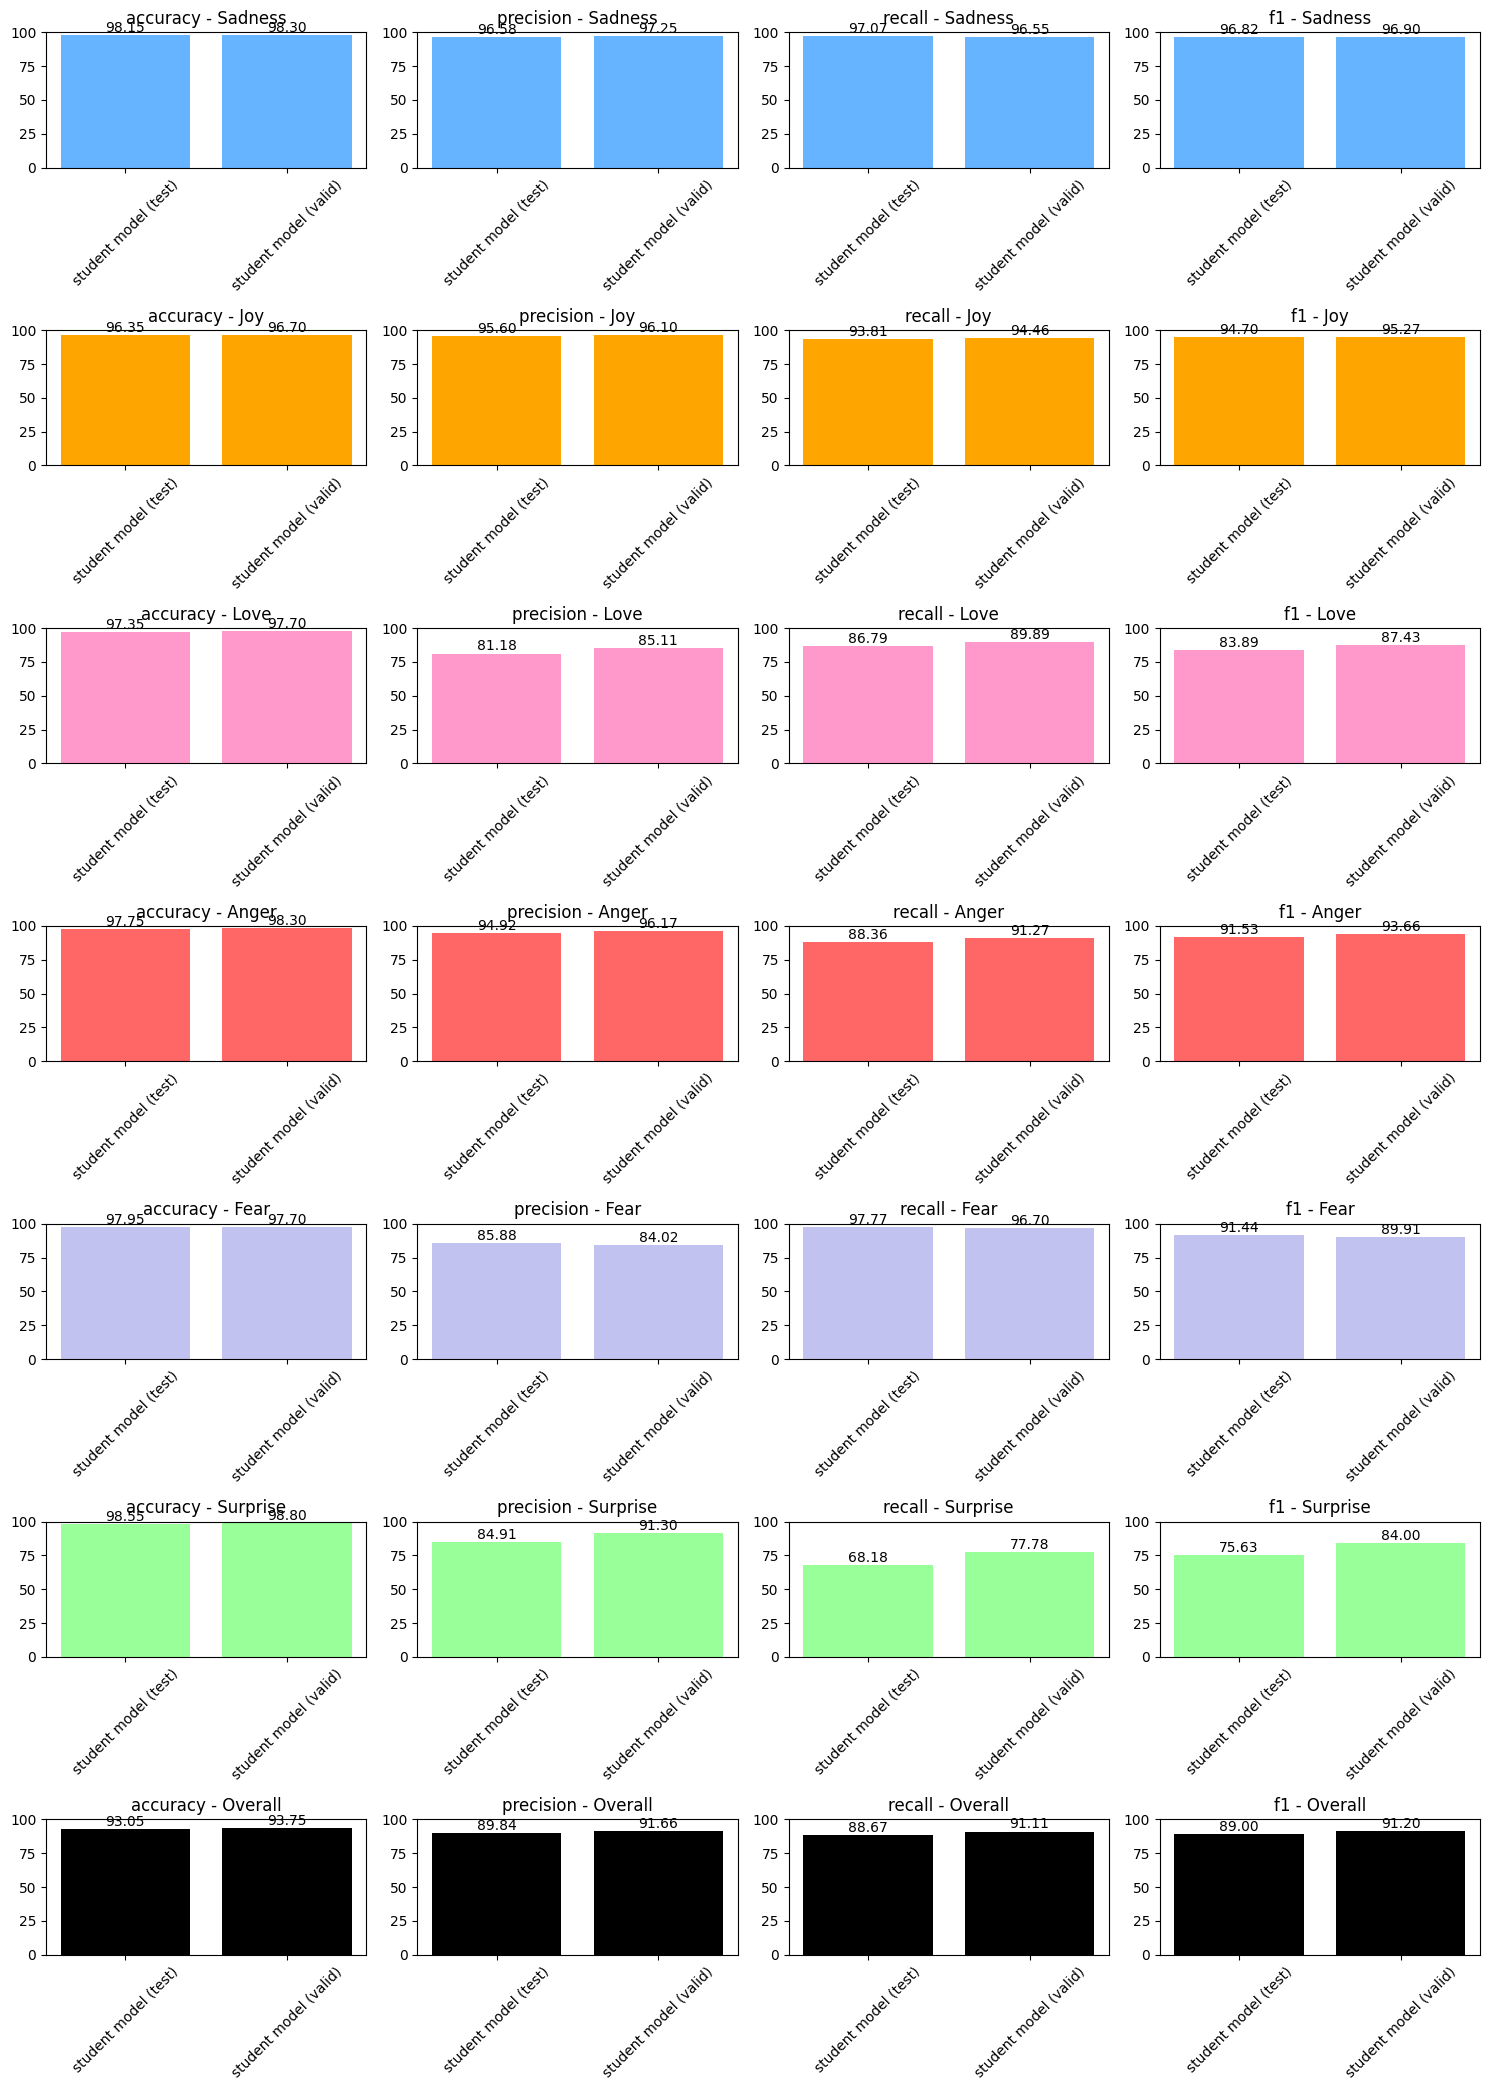

In [61]:
test_txt = df_test['text'].tolist()
valid_txt = df_val['text'].tolist()

max_length = 64

distiller = Distillation(
    teacher_checkpoint = 'bert-base-uncased', 
    student_checkpoint = 'distilbert-base-uncased', 
    num_labels=6, 
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), 
    path_to_student_weights = path_models_ + "bert_model_weights_100_student_05_10.h5"
)

test_preds = distiller.predict(test_txt, max_length)
valid_preds = distiller.predict(valid_txt, max_length)


metrics_distil = Metrics()

metrics_distil.run(df_test['label'], test_preds, "student model (test)")
metrics_distil.run(df_val['label'], valid_preds, "student model (valid)")

metrics_distil.plot_val()

Here I try predicting the validation data with the teacher model setup to compare speed. We see a prediction speed of 141 seconds.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

63/63 [==============================] - 141s 2s/step


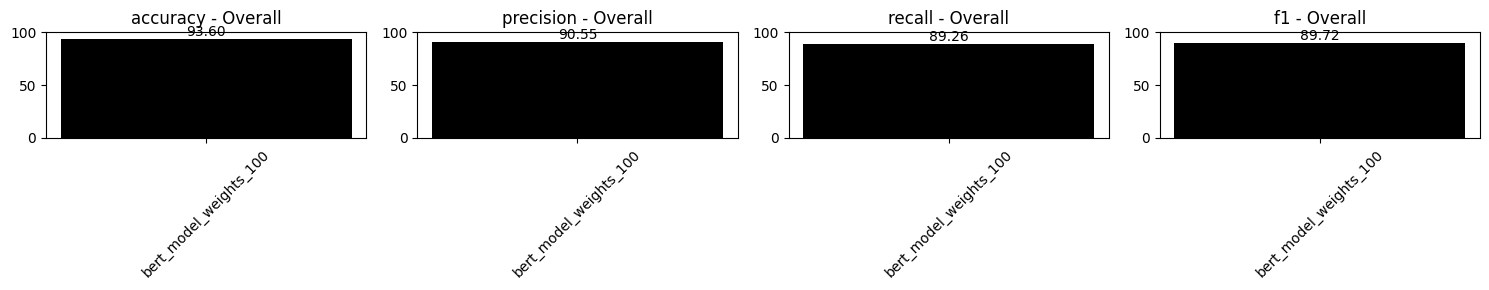

In [60]:
## test metrics
num_labels = 6
rate = 0.5
tokenizer, model = setup_bert(checkpoint="bert-base-uncased")
max_length = 64
bert_model_weights_path = path_models_ + f"bert_model_weights_100.h5"
bert_model = load_model_weights(tokenizer, model, max_length, num_labels, rate, bert_model_weights_path)
    
# Make predictions on the test set
test_preds = tokenize_and_predict(bert_model, tokenizer, df_test, max_length)
    
# Compute metrics for the incremental model
metrics_speed_comparison = Metrics()
metrics_speed_comparison.run(df_test['label'], test_preds, f"bert_model_weights_100")
    
# Plot test metrics for this incremental model   
metrics_speed_comparison.plot()

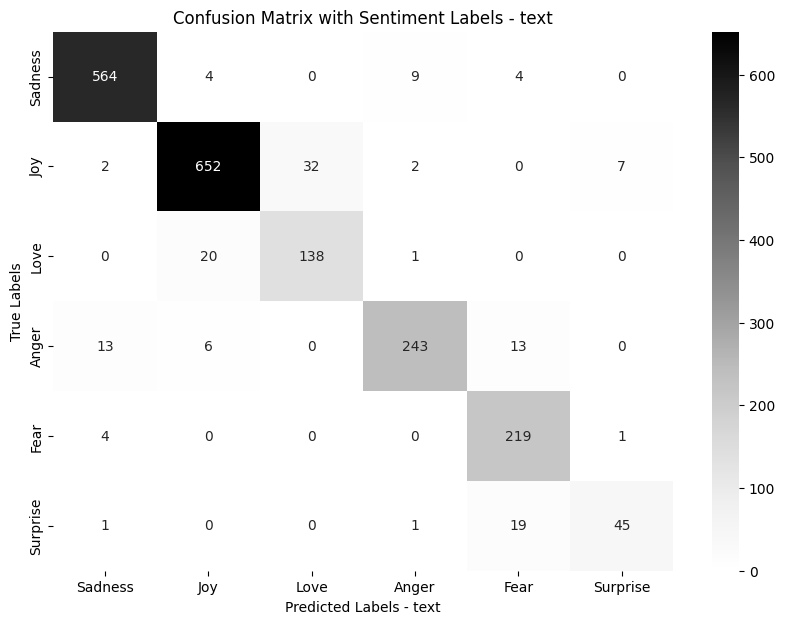

In [12]:
# Generate confusion matrix
col = 'text'
df = df_test[['label', col]].copy()
label_names = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
cm = confusion_matrix(df['label'], test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greys', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.title('Confusion Matrix with Sentiment Labels - ' + col)
plt.xlabel('Predicted Labels - ' + col)
plt.ylabel('True Labels')
plt.show()

### 4.c Analysis and Improvements
*Analyze deficiencies in the student model's learning. Suggest potential improvements or further research directions*

#### Error Analysis

The most frequent errors happen while predicting love when the real label is joy and viceversa, as well as predicting fear when it actually is surprise or anger. This makes sense as these emotions can be very similar in the way we express them in written language. We can look at these main clusters of errors and try to see patterns.

In [ ]:
predictions =pd.DataFrame({'txt': df_test['text'], 'true': df_test['label'], 'pred': valid_preds})

pred_love_true_joy = predictions[(predictions['true'] == 1) & (predictions['pred'] == 2)]

pred_joy_true_love = predictions[(predictions['true'] == 2) & (predictions['pred'] == 1)]

pred_fear_true_surprise = predictions[(predictions['true'] == 5) & (predictions['pred'] == 4)]

pred_fear_true_anger = predictions[(predictions['true'] == 3) & (predictions['pred'] == 4)]

In [35]:
for index, row in pred_love_true_joy.iterrows():
    print(f"Index {index}: {row['txt']}")

Index 86: i feel like i am in paradise kissing those sweet lips make me feel like i dive into a magical world of love
Index 262: i realized what i am passionate about helping women feel accepted and appreciated
Index 335: i believe that feeling accepted in a non judgemental way can be healing
Index 353: i could feel his breath on me and smell the sweet scent of him
Index 376: i suppose if one was feeling generous one could say i was stressed by the elevator ride
Index 413: i am and always have been a very sincere nice feeling sociable compassionate helpful girl
Index 436: i hope shes feeling generous today and treat me to japanese food or something haha have a great day
Index 531: i feel like i am not accepted here i and bucking this force that is coming from all quarters that tells me that something is wrong with me if i am not married with children
Index 540: i feel like alcoholism is something that is widely accepted as the norm in gay culture
Index 542: i also feel i have accepted 

For false predictions of **love** we see that:

- These are sentences that would be hard to classify even for a human without any context on the situation in which they were written

- The words "accepted", "passionate", "sweet", "blessed",  appear quite often:
    - "i feel so blessed to have friends i can come to"

    - "i don t know about you but i m feeling amp blessed"

    - "i don t know about you but it makes me feel generous"

    - "i am not feeling so generous and he is sent to the sofa where he glares at me for the next six hours"

    - "i like the fresh feeling of sweet he gave me"

    - "i feel accepted and loved by a community of derby girls that i helped to create"

    In fact you will find one of those words in almost every of these sentences.

In [31]:
for index, row in pred_joy_true_love.iterrows():
    print(f"Index {index}: {row['txt']}")

Index 96: i love neglecting this blog but sometimes i feel for my faithful readers
Index 131: im feeling generous today heres one more you may have already seen but is good for a chuckle
Index 183: i feel blessed to know this family
Index 303: i was so impressed with the show especially for hs and i was moved by these talented kids but then again i feel very passionate about productions and music and theatre in schools so i am always happy to endorse many hs productions throughout their seasons during this time
Index 316: i feel that i am supporting the troops by demanding that we not send our young men and women into harm s way to bear arms against a country that has done nothing to threaten us at any point
Index 466: i feel his hand on me to stay faithful
Index 520: i feel i should as a gracious gesture apologizing for my latest post about the osp and the rand license terms
Index 643: i feel most passionate about that arouse my emotions seem to be the things i need to learn something

For false predictions of **joy** we see that:

Many of these sentences are long and hard to classify into one specific sentiment.

The word passionate appers very often:

- "i also do feel passionate about teaching"

- "i ever recognized what it was to feel passionate about something was with music"

- "i guess its because i feel like if im too passionate about something it will get taken away from me"

- "i feel passionate about knitting and seeing really good films and the surprisingly awesome tv programs that are on now i cant believe i just wrote that"

In [33]:
for index, row in pred_fear_true_anger.iterrows():
    print(f"Index {index}: {row['txt']}")

Index 6: i felt anger when at the end of a telephone call
Index 94: when a friend dropped a frog down my neck
Index 98: i feel my heart is tortured by what i have done
Index 306: i took for granted a few weeks ago is really weird and makes me feel really agitated and frustrated
Index 537: i feel so damn agitated
Index 822: i wasn t sure what this gnawing feeling i was having but i was getting agitated sitting around doing nothing
Index 922: i was lying in bed last night after a day of making experiments from the usual suspects fabric plastic and feeling agitated that my issues with proper presentation had not made any headway over the course of a mere six hours
Index 1025: im not sure if its just me who feels this way or if its everyone but tortured souls dont make for the best boyfriends
Index 1113: i know how it feels to be tortured
Index 1184: i feel agitated a lot im straddling articulacy and incoherence
Index 1282: im always feeling so agitated overly excited and impatient to thos

In [34]:
for index, row in pred_fear_true_surprise.iterrows():
    print(f"Index {index}: {row['txt']}")

Index 72: i am right handed however i play billiards left handed naturally so me trying to play right handed feels weird
Index 152: i was so uncomfortable and feeling weird feelings but wasn t sure if they were contractions since i never really felt contractions with jared until they jacked me up with pitocin
Index 249: i will practice meditation if i feel overwhelmed and hopefully become successful in peaceful practice
Index 625: i am feeling overwhelmed by trying to do it all that i think on the women before me
Index 671: i feel thats just strange on wotcs behalf
Index 705: i feel overwhelmed how about you
Index 795: i feel a strange gratitude for the hated israeli occupation of sinai that lasted from to for actually recognizing the importance of sinais history
Index 820: i found myself feeling a bit overwhelmed
Index 969: i have been feeling overwhelmed with it all and needing to take time out
Index 996: i replied feeling strange at giving the orders
Index 1048: i wonder if the home

For false predictions of **fear** we see that:


In cases where the true label was anger the words agitated and tortured appear often:

- "i feel so damn agitated"

- "i wasn t sure what this gnawing feeling i was having but i was getting agitated sitting around doing nothing"

- "i know how it feels to be tortured"

- "im always feeling so agitated overly excited and impatient to those who are close to me"

Both words are hard to classify as tortured can be used in the context of sadness, anger, fear as either a fact as in someone having been tortured or a state of mind.


In cases where the true label was surprise very common words are weird, overwhelmed, strange:

- "i feel overwhelmed how about you"

- "im ok with that it feels a little weird"

- "i replied feeling strange at giving the orders"

- "i feel so weird and scattered with all wonders about a million different things"

- "i am feeling overwhelmed by trying to do it all that i think on the women before me"



##### Possible Improvements

It could be that these words are being relied on too much to make predictions and that is why they appear misclassified so often. One logical approach would be then to mask certain words and see whether there is a noticeable improvement. One problem might be that some of the sentences that are short might end up having no indication of sentiment if some words are masked. 

Example: If we mask "blessed": i just keep on feeling [MASK] would be very hard to classify as any feeling

It also happens that we find ourselves disagreeing with what is expected to be the true label of the sentence in question. This is just a problem with the dataset that we cannot do anything about.

Overall, we are quite satisfied with the performance of both the teacher and the student model. Instead of working on preventing further errors it might be more beneficial to test whether the models are biased against a certain gender, sexuality or ethnicity.